In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

import pandas as pd
import numpy as np

import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
nltk.download('stopwords')
nltk.download('punkt')

from nltk.stem import WordNetLemmatizer #this is used in lemmatization
nltk.download('wordnet') # this is required for lemmatization

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import  recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import  auc
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

from joblib import dump
from joblib import load
import plotly.graph_objects as go
from sklearn.feature_extraction.text import TfidfTransformer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [3]:
!ls "/content/drive/My Drive/Outbound/sushil.csv"

'/content/drive/My Drive/Outbound/sushil.csv'


In [4]:
#reading the file
#df_data = pd.read_csv("/content/drive/My Drive/Outbound/Copy_mbti_1 (1).csv")

df_data =  pd.read_csv("/content/drive/My Drive/Outbound/sushil.csv")

In [5]:
df_data = df_data.loc[:, ~df_data.columns.str.contains('^Unnamed')]

In [6]:
#displaying the file
df_data.head(10)

Type  ...                                               Text
0  ENTJ  ...   Notice the words you habitually use and repla...
1  ISTJ  ...   On the contrary to be descended from obscure ...
2  INTP  ...   It must be without retribution or punishment ...
3  ISFJ  ...   With practice we might do something quite cle...
4  ENFP  ...   And I had all the other corny symptoms too I ...
5  ENTP  ...   She had been bred was sensible and lively and...
6  INFP  ...   Round and round it went wobbling as it turned...
7  ESTP  ...   Okay she says hesitantly. And oh shit yeah. R...
8  ENFJ  ...   is of course understood that his neighbor loo...
9  ESTJ  ...   I trusted you to know what to do with the dat...

[10 rows x 4 columns]

In [7]:
#checking for null values
df_data.isnull().sum()

Type      0
Author    0
Book      0
Text      0
dtype: int64

In [8]:
#dropping the null values
df_data.dropna(inplace=True)
df_data.reset_index(inplace=True)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



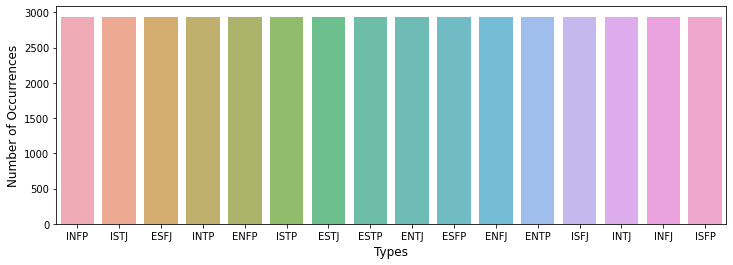

In [8]:
  cnt_types = df_data['Type'].value_counts()

  plt.figure(figsize=(12,4))
  sns.barplot(cnt_types.index, cnt_types.values, alpha=0.8)
  plt.ylabel('Number of Occurrences', fontsize=12)
  plt.xlabel('Types', fontsize=12)
  plt.show()

In [9]:
def get_types(row):
    t=row['Type']

    I = 0; N = 0
    F = 0; P = 0
    
    if t[0] == 'I': I = 1
    elif t[0] == 'E': I = 0
    else: print('I-E incorrect')
        
    if t[1] == 'N': N = 1
    elif t[1] == 'S': N = 0
    else: print('N-S incorrect')
        
    if t[2] == 'F': F = 1
    elif t[2] == 'T': F = 0
    else: print('T-F incorrect')
        
    if t[3] == 'P': P = 1
    elif t[3] == 'J': P = 0
    else: print('J-P incorrect')

    return pd.Series( {'IE':I, 'NS':N , 'FT': F, 'PJ': P }) 

df_data = df_data.join(df_data.apply (lambda row: get_types (row),axis=1))

df_data.head(5)

Type           Author          Book  ... NS  FT  PJ
0  ENTJ      TonyRobbins        Awaken  ...  1   0   0
1  ISTJ     ThomasHobbes     Leviathan  ...  0   0   0
2  INTP        JohnLocke     Governmen  ...  1   0   1
3  ISFJ  LouisaMayAlcott   LittleWomen  ...  0   1   0
4  ENFP        EricaJong  FearOfFlying  ...  1   1   1

[5 rows x 8 columns]

In [10]:
df_data['IE'].value_counts()

1    23512
0    23512
Name: IE, dtype: int64

In [11]:
df_data['NS'].value_counts()

1    23512
0    23512
Name: NS, dtype: int64

In [12]:
df_data['FT'].value_counts()

1    23512
0    23512
Name: FT, dtype: int64

In [13]:
df_data['PJ'].value_counts()

1    23512
0    23512
Name: PJ, dtype: int64

In [14]:
#cleaning the data

def text_process(df,columns):

  lamm = WordNetLemmatizer()
  tokenizer = RegexpTokenizer(r'\w+')
  corpus = []

  # We want to remove these from the psosts
  rubbish_type_list = ["lalalailailalalailailailalalailailailalalailai","raaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaawrrrrr","obsessivecompulsivemustconstantlychangemyavatar",
                         "bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb","aaaaaaaaaaaaaaaaaaaaaaaaaagggggggghhhhhhhhhhhhh","yeeeeeeeeeaaaaaaaaaaaaaaaaaaaaahhhhhhhhhhhhhhhh",
                         "anonymerautorodernichtwissenkanndeutschgrammatik","ohhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh","aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaagggghhh",
                         "ughughughughughsomeoneelsewholikesyellowbesidesme","aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaahhhhhhhhhhhhhhhh","shiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiit",
                         "weooohwaaaaeooohhhhhhhhaaaaaaoooowwwwwhhhheooowhhhh","loooooooooooooooooooooooooooooooooooooooooooooooool","hhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh",
                         "bahahahahahahahahahahahahahahahahahahahahahahahahaha","soooooooooooooooooooooooooooooooooooooooooooooooooooo","hogeiaiodaiogdsaoijhiofgashgiodhaiofhgklasjgfjisdfiohg",
                       "pleaseberightpleaseberightfuckyoudesignerspleaseberight","somanythoughtssomanythoughtssomanythoughtssomanythoughts",
                       "uaujamatgqaikjmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmghajamama","aaaaaaaaaaaaaaaaaahahahhahhahahahahahaahaahahahahhaaahha",
                       "aaaaaaaaaaarrrrrrrrrrrrrrrrrggggggggggggghhhhhhhhhhhhhhh","freeeeeeeeeeeeeeeeeeedoooooooooooooommmmmmmmmmmmmmmmmmmm",
                       "lolllllllllllllllllllllllllllllllllllllllllllllllllllllll","llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch",
                       "fuuuuuuuuuuuuuuuuuuucccccccccccccccccccccccckkkkkkkkkkkkkk","meeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee",
                       "hiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii","hhhhhhhhhhhhheeeeeeeeeeeeeeeeeelllllllllllllllllllllllllllll",
                       "hahahahahahahahahahahahahahhahahahahahhahahahahahahahahahhaha","pfwaaaaaaaaaahahahahahhahahahahahahahahahahahahahaaaaaaaaaaaaa",
                       "jjjjjjjkkkkkkkkkkkkkkllllllllllggggggggggggdddddddddddddtttttttt","hahahahhahahahahahahhahahahahahahahahahahahahahahahahahahahahahah",
                       "welllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllll","booooooooooooooooooooooooooooooooooorrrrrrrreeeeeeeeeeeedddddddddddd",
                       "nooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo","fffffffffffffffffffffffffffffffffuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu",
                       "hcjdnfbdfkgbddrixfjcbjgfufddicjshdbdhdjfbdjfbdhdvdhudbddjfhsixbdjfjdbdidh","waaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaah",
                       "fffffffffffffffuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu","aaaaaaaaaaaaaaaaaahahahahahahahahahahahahahhahahahhahahahahahahhahahahahhaha",
                       "awwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww","yeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeees",
                       "somanythoughtssomanythoughtssomanythoughtssomanythoughtssomanythoughtssomanythoughts","kreisjerkkreisjerkkreisjerkichhaettenichtsanderesdennkreisejerksmachenmichgluecklich",
                       "awwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww","aaaaaaaaaaaaagggggggggggggggggggggghhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh",
                       "reallytiredworkinghardworkingovertimestillgonnacookdinnerandcooktravelfoodfortheweekendanddrive","hahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahaha",
                       "milesandcomestraightbacktoworkandhavelotsoffunandneversleepandtotallyburnoutoneofthesedaysifidontgetso","srulesanymoreunlesssheactuallyintendedforthistobecomeanothertypetheabovepersonbasedontheiravatarthread","ahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahaahhahaha",
                       "llllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllll",
                       "noooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo",
                       "lolololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololooooooooooooooo",
                       "trolltrolltrolltrolltrolltrolltrolltrolltrolltrolltrolltrolltrolltrolltrolltrolltrolltrolltrolltrolllololololololololololololololololololololololololol",
                       "fuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu",
                       "victoryyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy",
                       "desecratedesecratedesecratedesecratedesecratedesecratedesecratedesecratedesecratedesecratedesecratedesecratedesecratedesecratedesecratedesecratedesecratedesecratedesecratedesecratedesecratedesecratede",
                       "eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee",
                       "connnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn",
                       "aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa",
                       "hippopotomonstrosesquipedaliophobia","adskjfndjkgbfjdbsjhkvbjfhkbirwlhuvj","sociallyliberalfiscallyconservative","emooooooooooooooooooooooooooooooooo",
                       "oooooooooooooooooooooooooooooooooon","prettyfreakingawesomeandmoreawesome","mehhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh",
                       "hippopotomonstrosesquippedaliophobia","gggggghhhhhhhhhooooooooooooooooooooo","extravertedsensingthinkingperceiving",
                       "weeeeeeeeeeeeeeeeeeeeeeeeeeeeeelcome","insertrandomtypeherebecausethreadisn","heeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeey",
                       "blahhhhhhhhsdfakjfhdksgdlngsngkldnskd","noooooooooooooooooooooooooooooooooooo","paaaaaaaaaaaaaaaaartyyyyyyyyyyyyyyyyyy",
                       "fuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuck","hiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii","yyyyyyyyyyyyyyyeeeeeeeeeeessssssssssss",
                       "boooooooooooooooooooooooooooooooooooob","hahahahahahahahahahahahahahaahahahahaha","hiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii",
                       "estpextravertedsensingthinkingperceiving","uasodfoajsoidfioajsiodfjaoijsdiofjasdmfl","wwwweeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeenie",
                       "bbbbbbbboooooooooorrrrrrrrreeeeeeeeddddd","aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaagh","asdfgnjaskbdfscajldfjbsjsdkffgsjfbhdsdknv",
                       "aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa","yayyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy","toooooooooyyyyyyyyyyyyyyyyyyyzzzzzzzzzzzzz",
                       "looooooooooooooooooooovvvvvvvvvvvvvvvvvvve","badboysbadboywatchagannadowhenwecomeforyou","hahahahahahahahahahahahahahahahahahahahaha",
                       "idgieyfviuefvifegedfiedgfipwgfwpifgepifgdig","weeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee","thenhowcanyouhaveanaccountifyoudidnotsignup",
                       "extravertedsensingfeelingperceivingstrength","waaaaaaaaaaaaaaaassssssssssssttteeeeeeeeeed","ppfffffffffffttttttttttttttttttttttttttttttt",
                       "pffffffffffffttttttttttttttttttttttttttttttt","nooooooooooooooooooooooooooooooooooooooooooo","whynotcapitalizeyourwordstomakeiteasiertoread",
                       "judgejudgejudgejudgejudgejudgejudgejudgejudge","ahahahahahahahahahahahahahahahahahahahahahaha","mbtiisforgettingpeoplehookedonsomethingsimple",
                       "doesntknowofabettermethodthanquotingsoimsorry","blaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaah","totallycrazyamazingsauceenergeticandambitious",
                       "bwahahahahahahahahahahahahahahahahahahahahaha","ahhhhhhhhhhhhhhhhhhhhhhhhhhhhh","nooooooooooooooooooooooooooooooooo","ooooooooooooooooooooooooooooooooo",
                       "hahahahahahahahahhahahahahahhaha","cofcofposhbeckscofcofzigicofcof","supercalifragilisticexpialidocious","oooooooooooooooooooooooooooooo",
                       "esfplolitslieksooooobviouslerl","githinkmypetcockroachdiedtoodles","lalalalalallalaololololollalalala","zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz",
                       "poetrythathappenswhenyouretipsy","arrrrrrrrrrrrrrrrrrrrgsadfghjk","ehehehehehehheheheeeeheehehehee","hahahahahahahhhaahhahapleasegodno",
                       "looooooooooooooooooooooooooool","ohmygoshohmygoshohmygoshohmygosh","hahahahahahahahahahhahahahahhahaha","goooooooooooooooooooooooooooood",
                       "dasfitfijafijsfjoaeuflhejafgsdghdg","awwwwwwwwwwwwwwwwwwwwwwwwwwwwwww","introvertedsensingfeelingjudging","niiiiiiiiiiiiiiiiiiiiiiiiiiiiiice",
                       "taaaaaaaaaaaaaxeeeeeeeesssssssss","extravertedsensingfeelingjudging","pleeeeeeeeeeeeeeeeeeeeeeaaaaase","fuuuuuuuuuuuuuuuuuuuuuuuuuuuuuck",
                       "slooooooooooooooooothhhhhhhhhhhh","aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa","yooooooooooooooooooooooooooork","gfhgioigffsfdghjgfhjgfdghjhgfdghj",
                       "looooooooooooooooooooooooooong","introvertedsensingthinkingjudging","ocmfkjdnvkjfndkjvdsonpfdvdisbvbi","freeeeeeeeeeeddddddoooooooooooom",
                       "aaaaaaaaaaaaaaaahhhhhhhhhhhhhh","spaaaaaaaaaaaaaaaaaaaaaaaaaaaam","apparentlysomeonehadthesameproblem","mooooooooooooooooooooooooooooooon",
                       "noooooooooooooooooooooooooooooo","coooooookkkkkiieeeeeeeeeeeeeee","ughhhhghghgaagahhugughhhghuhghhhhh","ddddaaaaammmmmmnnnnnnnnnnnnnnnnn",
                       "twwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww","hiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii","holycrapholycrapholycrapholycrap","aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaagh",
                       "mmmmmwwwwwwwwaaaaaahaaaahhaaaaaa","hahahhahahhahahhahahahhahahahhaha","mwahahahahahahhahahahahahahahaha","dooooooooooooooowwwwwwwwnnnnnn",
                       "beeeeeeeeeeeeeeeeeeeeeeeeeeeeeeer","wrrrrrrrrrrrrrrrrrnnnnnnnngggggg","hahahahahahahahahahahahahahaha","hahhahahhahahahahahahahahaahahhaha",
                       "nooooooooooooooooooooooooooooo","boooooorrrrrrriiiinnnnnnngggggggg","literaldefinitionofallornothing","ughhhhhhhhhhhhhhhhhhhhhhhhh","yesyesyesyesyesyesyesyesyes",
                       "mmmmmmnomnomnomnomnomnomnom","hahahahahahahahahahaahhaha","coughcoughmyistpdadcoughcough","titaaaaaniiiiiiuuuummmmmm","buttttttttttttttttttttttttt",
                       "speeeeeeeeeeeeeeeeeeeeeeddd","crumbssssssszszszszszzzzzsss","hahahahahahahahahahahahaha","lolololololololololololol","sooooooooooooooooooooooooooo",
                       "angerangerangerangerrrrrrr","meaaaaaaaaaaaaaaaannnnnnnn","ieknbsbzdxjlihrozxkgyxjlihbyb","igzhbwlsawfyihdpdgggdghpcy","ussszzsasdzsdzsdzsdzsdzsdzsd",
                       "hehehehehehehehehehhehehe","hhhhhhhhhhhhhhhhhhhhhhhhh","gaaaaaayyyyyyyyyyyyyyyyyyy","elysiacorgigirlseladeamombti","ahahhahhahahahhahahahahaha",
                       "blahahahahahahahahahahahaaa","howdoesthatmakefuckingsense","aeheauaehuaehaeuhaeueahuaeh","winfreycouldbeatupmichael","adultchildofalieninvaders",
                       "soooooooooooooooooooooooo","superspecialbirthdaystardance","veeeeeeeeeeeeeeeeeeeeeeeeery","hahhahahahahahhaahaahahaha","floccinaucinihilipilification",
                       "meowwwwwwwmeomeowwwwwwwrooof","hdjdhdbjdhdgsjdbdidhgsjddid","ooooooooooooooooooooooooo","subterraneanhomesickalien","huuuuuuuuuuuuuuuuuuuuuuge",
                       "purrrrrrrrrrrrrrrrrrrrrrrfect","weeeeeeeeeeeeeeeeeeeeeeeee","aaaaaaaarrrrggggggghhhhhh","whyischocolatesodamnaddictive","omgimsosorryiwenttoofaromg",
                       "tuhtuhtuhtuhtuhtuhtuhtuhtuh","muuuuuuusssssikmaaaaaannnn","aaaaaaaaaaaaaaaaaaaaaaaaaaaaa","huggggggggggggggggggggggggggg","nuuuuuuuuuuuuuuuuuuuuuuuuuuuu",
                       "aaaaaaaaaaaaaaaaaaaaaaaaaand","hahahahahahahahahahaahaha","thisisayoutubetypecomment","ohgodohgodohgodohgodohgod","moooooaaaaaaaaarrrrrrrrrrrrrr",
                       "barrrrrrrrrrrrrrrggggggggg","fiyeeeeeeerrrrrrrroooooooo","thefivefactorpersonalitytest","stooooooooooooooooooooooooop","yaaaaaaaaaaaaaaayyyyyyyyyy",
                       "hhhhhhhhhhnnnnnnnnggggggg","hahahahahahahahahahahahah","sensingthinkingperceiving","disorganizedconscientious","maketheentpforumgreatagain",
                       "aaaaaaahhhdeeedeeedeeehaaaaa","xddddddddddddddddddddddddd","dontdontdontdontdontdontdont","invalidoperationexception","mmmmmmmmmmmmmmmmmmmmmmmmmm",
                       "hahahahahaahahahahaahahaaaa","allllllllllllllllllllllll","thiiiiiiiiiiiiiisssssssss","ilovethemilovethemilovethem","themanwholivedunderground",
                       "intpsarealwaysboredexception","zyxwvutsrqponmlkjihgfedcba","websiteasodeamenteelsayid","jonathanlivingstonseagulll","trolololololoolollolololol",
                       "raaaaaaaaaaaaaaaaaaaaaaaaaaa","hypertrophiccardiomyopethy","prisencolinensinainciusol","antidisestabishmentarianism","hypersensitivefoolishdoomed",
                       "aaaaaaaahhhhhhhhhhhhhhhhhh","yyyyeeeeeeeeaaaaaaaaaaaaaaa","boiiiiiiiiiiiiiiiiiiiiiiiiiii","supercaliflageristic","screamofconciousness","aaaaaaaannnnnndddddd",
                       "drottningholmsmusiken","laaaaiiiiiinnnneeeyyyy","nononononononnonononono","handsheracupofcoffee","trolololololllololol","tooooooooooooooooodles",
                       "tsaisoniceohmmeegeeee","youpullmethroightime","duhhhhhhhhhhhhhhhhhhhhhh","mickelousproductions","rrrraaaaaaarrrgghhhhhh","ccccreeeersffffeeerrt",
                       "megalomaniacambitious","fuuuuuuuuuuuuuuuuuuuuck","nooooooooooooooooooooo","shhhiiiiieeeeeeeeeeeeeet","evilracistnaziskinhead","soooooooooooooooooooo",
                       "ahhhhhhhhhhhhhhhhhhhhh","geroooniiimoooooooooo","uuuuuuuuuuuuuuuuuuuuuuum","wantingtobealoneness","looooooooooooooooong","planesandtrainsandcars",
                       "enigmawrappedinbacon","bbbbbbbluuuuuuuuurhhhhm","pamyupamyurevolution","awwwwwwwwwwwwwwwwwww","bwaahahahahahahahahaha","arghfgahsjkdpkioalpsd",
                       "blahblahblahblahblah","overlooooooaaaaaaaad","supermegainfjpowerhug","ughhhhhhhhhhhhhhhhhhh","sarcasmbutpossibletrue","charrrgggggggeeeeeeee",
                       "kerrygoldgrassfedbutter","ooooooooooooooooooooooo","oooooooooooooooooooooh","guhhhhhhhhhhhhhhhhhhhhh","selchiechildofcassandra","graaahhhhhhhhrrrrghhh",
                       "ithinkyoureoverthinking","whooooooooooooooooooo","middledistancerunner","reeeeeeeeeeeeallllllllly","woooooooooooooooooooo","thissiteisdictatorship",
                       "yummmmmmmmmmmmmmmmmmmmy","nnnnnnhhhjuaaaaaaaah","sharefavoriteclipsofdata","omgomgomgomgomgomgomg","trolololololololling","hahahahahahahahahahahaha",
                       "traitscorepercentile","mischaracterizations","ahahahahahahahaahaaah","hahahahhahahhahahaha","lensflaresandloveaffairs","heauheaueaheaueaheau",
                       "willkeepaneyeoutforyou","ofwonderhowfarthisgoes","hahahahahaahahahahahah","hahahahahahshahahahahaha","sooooooooooooooooooooo","letmeknowwhenitworks",
                       "overenthusiastically","oirjiorjnjiornjinfpoujin","jooooookkkkkkkeeeeeeee","extrasensorthoughtjudged","currentlynonexistant","hahahahahahahaaaaaaaa",
                       "bwahahahahahahaahahahah","enlightenmentphilosophes","hidrawhatchamacallit","politicalllyincorrect","wooooooooooooooooooooow","bleearrroooahhglleeeargh",
                       "achievementaccomplished","baaaaaaaaaaaaaaaaaaad","pmsisawesomenotreally","fldshmdgdblfmddhbldagh","heeeheeeheeeahahahha","heeeheeeheeeheeeheee",
                       "magicthingsofallsorts","maybekindasortascience","supercalifragilistic","therandomsciencegirl","concerningyourcurtains","grrrrrrrrrrrrrrrrrrrrrrr",
                       "ooooooooooooooooooooo","fbndsfkueagbwfkhawfk","patstheinfpsontheback","gettingembarrasedasking","thisssssssssssssssssss","themaraudingtimelord",
                       "hahahahahhaahhaahahhahaa","listentothemountains","aaaaaaaaaahahahahahaha","lexifireextinguisher","secularilarilooralie","myersbriggswithintplivi",
                       "lalalalalallalallala","lorddarthmoominkirby","urgrghrghghghgggggghh","trolllollollollolllllll","lickilickilickilicki","loveeeeeeeeeeeeeeeeeeee",
                       "dreammmmmmmmmmmmmmmmmm","everrrrryyyttthinnnnggg","noooooooooooooooooooo","looooovvvvvvvvveeeeee","thezeitgeistmovement","uuuuuuuuuoooooooooooohhh",
                       "awweesssoooommmmeeeee","aaaaaaaaaaaaaaaaaaaaa","ahhhhhhhhhhhhhhhhhhhh","thankyouthankyouthankyou","extremelyaffectionate","whateverthehellyouare",
                       "haaaaaaaaaaaaaaaaaaah","ushitpipensophisticated","whateveryawannacallit","throughthelookingglass","projectvulnerability","electroencephalography",
                       "hueheuheuheuheuheuheuh","ahhhhhhhhhhhhhhhhhhhhhh","hothothothothothothothot","aintgotnoexpressions","anybodyelsethatdoesthat","themysteriousmrenter",
                       "ivedatedthatchickbefore","usethecognativefunctions","descriptionschampions","whywontgodhealamputees","nokinakikutedoarichi","ggggaaaaaaaaaaaahhhh",
                       "pscyhoooooollolgygyg","pleeeeeeeeeeeeeeease","lieeeeeeeeeessssssssss","blahblahnoisyhumanthings","eeeeeeeeeeeeeeeeeeeeeee","gennnnnnerrraaaaallllll",
                       "raaaaaaaaaaastafaaaaaari","fuuuuuuuuuuuuuuuuuuck","whooooooooooooooooooooo","introvertedextraverted","disagreeableagreeable","libertinecollectivism",
                       "lifeisgreatallthetime","mwoahahahahahaaaaawh","ssoooooooooooooooooo","aaaaawesoooooooooome","randomshadowpersonality","supershinesunglasses",
                       "ooooooooooooooooooooooh","xxxxxxxxxxxxxxxxxxxxxx","theultimatesquarepeg","altruisticmisanthropist","akdfjlgvshgblbjhkfgncv","persoonlijkheidstype",
                       "definingearlyeeriece","ohmygodstringquartet","hahahahaaahaaahahahah","bubblebooooooooooooy","happpppppppyyyyyyyyy","hahahaahahaahahahahha",
                       "careerassessmentsite","imnotgoodatusernames","catsthatlooklikehitler","tooooooooooooooooooo","ahahahahahahahahahaha","narcissisticdisorder",
                       "yeeeeeeeeeeeeeeeeeeah","produuuuuccccctsssss","ohhhhhhhhhhhhhhhhhhhh","nnuuuurrrrrgggghhhhh","niggercuntfaggotdykefag","paraskevidekatriafobia",
                       "withoutreceptionville","steffiqueenofthenerds","compassionatemisanthrope","hahahahahahaahahhahahaha","yesyesyesyesyesyesyesyes","aaaaahhhhahahahahahaha",
                       "leeeeeeerooooooooooy","topcatlsdtsubakiretsu","motherfuckersyesterday","nnneeeeeeooooooowwwwww","djfjdsbgdfhgfdsgfdsgfs","mmmmmmmmmmmmmmmmmmmmmm",
                       "jhgjhgdjhgdjhgdjhgdj","recurringthoughtofmine","mentalemotionalphysical","thankyoufortheterror","barbaraelectronicmusic","hahahahahahahahhahahaha",
                       "bahahahahahahahahahaha","privateislandsonline","biyyyyaaaatttcccchhhh","blarghezzenfidilious","muuuuulaaaaaaaannnnn","waaaaagdsgklshnsgjhsg",
                       "insertcreativeusername","teeehehehehahehehihihi","yayayayayayayayayayay","surroundedbyspaniards","ddddddddddddddddddddd","prodeductivereasoning",
                       "hahaahahahahaahahahahaah","ufizfzfizfuogougugug","professionsuddannelse","isingthebodyelectric","hahahahahahahahahaha","heartturnedtoporcelain","hahahahahahahahahahaha",
                       "thatdamnfieryseagoat","whoseeswithoutbeingseen","whoputstheirfaceonabus","mistakenforastranger","meeeeeeeeeeeeeeeeeee","aurorarogersskywalker",
                       "killingtroubleshooter","unknownobservanttortoise","distracteddaydreamer","thedarknessinthesnow","penelopethefabulousfish","entjwillruletheworld",
                        "youpullmethroughtime","rememberthisusername","motherofdragonslover","gritglossandrainbows","figuringitalloutasalways","insertcreativenamehere","xxxxxxxxxxxxxxxxxxxx",
                       "sighcantthinkofaname","benevolentbitterbleeding","gettingacrossthebridge","uniquefinallyamongpeers",]

  rubbish_type_list = [x.lower() for x in rubbish_type_list]

  # We want to remove these from the psosts
  unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
  
  unique_type_list = [x.lower() for x in unique_type_list]

  for i in df[columns]:
    
    #remove url's
    sentence = re.sub(r"http\S+", " ", i).lower()

    # #removing characters other than alphabets
    sentence = re.sub('[^a-zA-Z]',' ',sentence)

    # #removing spaces
    cleaned_sentence = re.sub(r'\s+',' ',sentence)

    #tokenize
    cleaned_sentence = tokenizer.tokenize(cleaned_sentence)

    # # remove any stopwords & lammetizatio
    cleaned_sentence = [lamm.lemmatize(word) for word in cleaned_sentence if word.lower() not in stopwords.words('english')]

    #remove rubbish word
    cleaned_sentence = [word for word in cleaned_sentence if word not in rubbish_type_list]

    #remove mbti types
    cleaned_sentence = [word for word in cleaned_sentence if word not in unique_type_list]

     # # Join the characters again to form the string.
    cleaned_sentence = ' '.join(cleaned_sentence)

    corpus.append(cleaned_sentence)

  return corpus

In [15]:
#data cleaning
Corpus = text_process(df_data,columns='Text')

In [16]:
df_data['Clean_Text'] = Corpus
df_data['Length'] = df_data['Clean_Text'].apply(len)

In [19]:
df_data[df_data['Length']==25]

index  Type  Author  ... PJ                 Clean_Text  Length
11357  11357  ENTJ  AlGore  ...  0  wake chance hear question      25

[1 rows x 11 columns]

In [ ]:
indexNames = df_data[df_data['Length'] <=10 ].index #do this 
indexNames

Int64Index([], dtype='int64')

In [ ]:
df_data.drop(indexNames , inplace=True) #do this

In [ ]:
filter_corpus = filter (lambda text: len (text) > 10, Corpus)

In [ ]:
filter_corpus = [text for text in Corpus if len(text) > 10 ]

In [17]:
df_data.head()

Type  ... Length
0  ENTJ  ...    476
1  ISTJ  ...    594
2  INTP  ...    515
3  ISFJ  ...    169
4  ENFP  ...    246

[5 rows x 10 columns]

In [18]:
def evaluate_model(y_test, predicted, predicted_prob, show_thresholds=True, figsize=(25,5)):
    classes = np.unique(y_test)
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    
    ## Accuray e AUC
    accuracy = metrics.accuracy_score(y_test, predicted)
    auc = metrics.roc_auc_score(y_test, predicted_prob)
    print("Accuracy (overall correct predictions):",  round(accuracy,2))
    print("Auc:", round(auc,2))
    
    ## Precision e Recall
    recall = metrics.recall_score(y_test, predicted)  #= true 1s / all 1s in test (got and missed)
    precision = metrics.precision_score(y_test, predicted)  #= true 1s / all 1s predicted (true 1s + false 1s)
    f1 = metrics.f1_score(y_test, predicted)  #=2 * (precision * recall) / (precision + recall)
    print("Recall (all 1s predicted right):", round(recall,2))  #true positive rate, how many 1s I got
    print("Precision (confidence when predicting a 1):", round(precision,2))  #how many 1s were really 1s
    print("F1 score:", round(f1,2))
    print("Detail:")
    print(metrics.classification_report(y_test, predicted, target_names=[str(i) for i in classes]))
       
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(y_test, predicted, labels=classes)
    sns.heatmap(cm, annot=True, annot_kws={"size":15}, fmt='d', ax=ax[0], cmap=plt.cm.Blues, cbar=False)
    ax[0].set(xlabel="Pred", ylabel="True", title="Confusion matrix")
    ax[0].set_yticklabels(labels=classes, rotation=0)
 
    ## Plot roc
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_prob)    
    ax[1].plot(fpr, tpr, color='darkorange', lw=3, label='area = %0.2f' % metrics.auc(fpr, tpr))
    ax[1].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[1].hlines(y=recall, xmin=-0.05, xmax=1-cm[0,0]/(cm[0,0]+cm[0,1]), color='red', linestyle='--', alpha=0.7, label="chosen threshold")
    ax[1].vlines(x=1-cm[0,0]/(cm[0,0]+cm[0,1]), ymin=0, ymax=recall, color='red', linestyle='--', alpha=0.7)
    ax[1].set(xlim=[-0.05,1], ylim=[0.0,1.05], xlabel='False Positive Rate', ylabel="True Positive Rate (Recall)", title="ROC Curve")     
    ax[1].legend(loc="lower right")
    ax[1].grid(True)
    if show_thresholds is True:
        thres_in_plot = []
        for i,t in enumerate(thresholds):
            t = np.round(t,1)
            if t not in thres_in_plot:
                ax[1].annotate(t, xy=(fpr[i],tpr[i]), xytext=(fpr[i],tpr[i]), textcoords='offset points', ha='left', va='bottom')
                thres_in_plot.append(t)
            else:
                next
    
    ## Plot precision-recall curve
    precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, predicted_prob)
    ax[2].plot(recalls, precisions, color='darkorange', lw=3, label='area = %0.2f' % metrics.auc(recalls, precisions))
    ax[2].plot([0,1], [(cm[1,0]+cm[1,0])/len(y_test), (cm[1,0]+cm[1,0])/len(y_test)], linestyle='--', color='navy', lw=3)
    ax[2].hlines(y=precision, xmin=0, xmax=recall, color='red', linestyle='--', alpha=0.7, label="chosen threshold")
    ax[2].vlines(x=recall, ymin=0, ymax=precision, color='red', linestyle='--', alpha=0.7)
    ax[2].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
    ax[2].legend(loc="lower left")
    ax[2].grid(True)
    if show_thresholds is True:
        thres_in_plot = []
        for i,t in enumerate(thresholds):
            t = np.round(t,1)
            if t not in thres_in_plot:
                ax[2].annotate(np.round(t,1), xy=(recalls[i],precisions[i]), xytext=(recalls[i],precisions[i]), textcoords='offset points', ha='right', va='bottom')
                thres_in_plot.append(t)
            else:
                next
    plt.show()

In [19]:
def transform_feature(data,tech):

  if tech == 'bow':
    bow = CountVectorizer(max_features=5000,ngram_range=(1,3))
    x = bow.fit_transform(data).toarray()

    tfidf_transformer = TfidfTransformer()
    X_trans = tfidf_transformer.fit_transform(x)

    #model_name = '/content/drive/My Drive/LinkedIn/Model/bow.joblib.dat'
    #dump(bow, model_name)
  elif tech == 'tfidf':
    tfidf = TfidfVectorizer(max_features=5000,ngram_range=(1,3))
    X_trans = tfidf.fit_transform(data).toarray()
  
  return X_trans

In [20]:
def translate_data_back(personality):


    # transform binary vector to mbti personality
    Personality_list = [{1:'I', 0:'E'}, {1:'N', 0:'S'}, {1:'F', 0:'T'}, {1:'P', 0:'J' }]
    s = ""
    t = ""

    for i, l in enumerate(personality):
        s += Personality_list[i][l]
        if Personality_list[i][l] == 'I':
          t += 'Introversion,'
        elif Personality_list[i][l] == 'N':
          t += ' Intuition,'
        elif Personality_list[i][l] == 'F':
          t += ' Feeling,'
        elif Personality_list[i][l] == 'P':
          t += ' Perceiving'
        elif Personality_list[i][l] == 'E':
          t += ' Extroversion,'
        elif Personality_list[i][l] == 'S':
          t += ' Sensing,'
        elif Personality_list[i][l] == 'T':
          t += ' Thinking,'
        else:
          t += ' Judging'
    
    t = 'Person possesses following personality :- ' + t
            
    return s,t

In [21]:
def draw_graph(prob_IE,prob_NS,prob_FT,prob_PJ,s):

  df_prob = pd.DataFrame()
  Personality = []
  Score = []

  for i in list(s):

    if i == 'I' or i == 'E':
      Personality.append('Introversion')
      Score.append(np.around(prob_IE[:,1],2)[0] * 100)
      Personality.append('Extroversion')
      Score.append(np.around(prob_IE[:,0],2)[0] * 100)
    # elif i == 'E':
    #   Personality.append('Extroversion')
    #   Score.append(np.around(prob_IE[:,0],2)[0] * 100)
    #   Personality.append('Introversion')
    #   Score.append(np.around(prob_IE[:,1],2)[0] * 100)
    elif i == 'N' or i == 'S':
      Personality.append('Intuition')
      Score.append(np.around(prob_NS[:,1],2)[0] * 100)
      Personality.append('Sensing')
      Score.append(np.around(prob_NS[:,0],2)[0] * 100)
    # elif i == 'S':
    #   Personality.append('Sensing')
    #   Score.append(np.around(prob_NS[:,0],2)[0] * 100)
    #   Personality.append('Intuition')
    #   Score.append(np.around(prob_NS[:,1],2)[0] * 100)
    elif i == 'F' or i == 'T':
      Personality.append('Feeling')
      Score.append(np.around(prob_FT[:,1],2)[0] * 100)
      Personality.append('Thinking')
      Score.append(np.around(prob_FT[:,0],2)[0] * 100)
    # elif i == 'T':
    #   Personality.append('Thinking')
    #   Score.append(np.around(prob_FT[:,0],2)[0] * 100)
    #   Personality.append('Feeling')
    #   Score.append(np.around(prob_FT[:,1],2)[0] * 100)
    elif i == 'P' or i == 'J':
      Personality.append('Perceiving')
      Score.append(np.around(prob_PJ[:,1],2)[0] * 100)
      Personality.append('Judging')
      Score.append(np.around(prob_PJ[:,0],2)[0] * 100)
    # else:
    #   Personality.append('Judging')
    #   Score.append(np.around(prob_PJ[:,0],2)[0] * 100)
    #   Personality.append('Perceiving')
    #   Score.append(np.around(prob_PJ[:,1],2)[0] * 100)
    
  df_prob['Personality'] = Personality
  df_prob['Score'] = Score

  plt.figure(figsize=(10,8))
  fig = px.line_polar(df_prob,r=df_prob.columns[1],theta=df_prob.columns[0],line_close=True,title='Personality Type')
  fig.update_traces(fill='toself')
  fig.show()


  import seaborn as sns
  sns.set_theme(style="whitegrid")
  tips = sns.load_dataset("tips")
  ax = sns.barplot(x=df_prob.columns[0], y=df_prob.columns[1], data=df_prob)
  for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

In [ ]:
#transforming the feature

#x = transform_feature(Corpus,tech='bow')
x = transform_feature(Corpus,tech='bow')

In [22]:
#split the data
def split_data(x,y):
  
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=100)

  return X_train, X_test, y_train, y_test

In [ ]:
x.shape,df_data.shape

((47024, 5000), (47024, 10))

## **Using Bow**

## XGB Classifier

Introvert / Extrovert

In [ ]:
#getting splited data
X_train, X_test, y_train, y_test = split_data(x,df_data['IE'])

Accuracy (overall correct predictions): 0.8
Auc: 0.85
Recall (all 1s predicted right): 0.92
Precision (confidence when predicting a 1): 0.8
F1 score: 0.86
Detail:
              precision    recall  f1-score   support

           0       0.80      0.57      0.67       756
           1       0.80      0.92      0.86      1389

    accuracy                           0.80      2145
   macro avg       0.80      0.75      0.76      2145
weighted avg       0.80      0.80      0.79      2145



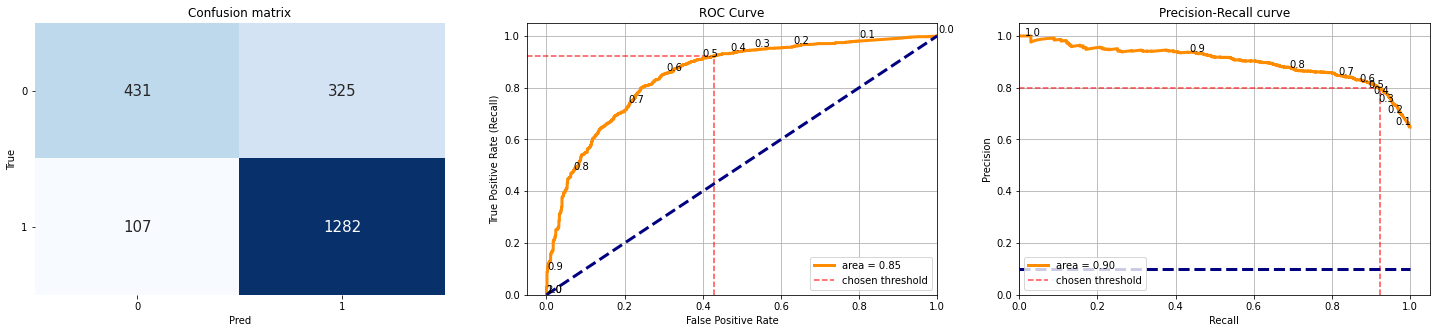

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier(learning_rate=0.2, n_estimators = 200,nthread=8,max_depth = 2)
model.fit(X_train, y_train)
predict_xgb = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_xgb, predicted_prob, figsize=(25,5))

Accuracy (overall correct predictions): 0.75
Auc: 0.84
Recall (all 1s predicted right): 0.74
Precision (confidence when predicting a 1): 0.75
F1 score: 0.75
Detail:
              precision    recall  f1-score   support

           0       0.75      0.76      0.76      4738
           1       0.75      0.74      0.75      4667

    accuracy                           0.75      9405
   macro avg       0.75      0.75      0.75      9405
weighted avg       0.75      0.75      0.75      9405



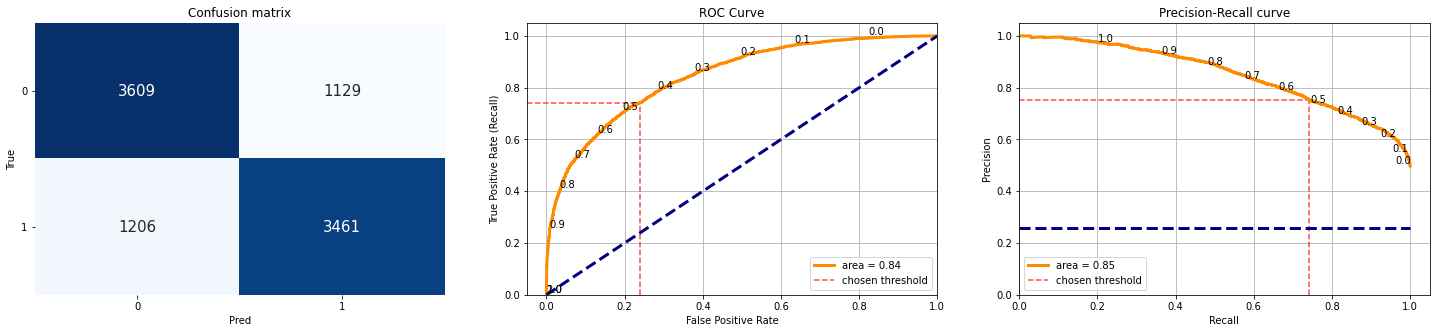

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier(learning_rate=0.2, n_estimators = 1000,nthread=8,max_depth = 10)
model.fit(X_train, y_train)
predict_xgb = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_xgb, predicted_prob, figsize=(25,5))

Intuitive / Sensing

In [ ]:
#getting splited data
X_train, X_test, y_train, y_test = split_data(x,df_data['NS'])

Accuracy (overall correct predictions): 0.88
Auc: 0.91
Recall (all 1s predicted right): 0.98
Precision (confidence when predicting a 1): 0.86
F1 score: 0.91
Detail:
              precision    recall  f1-score   support

           0       0.93      0.66      0.77       680
           1       0.86      0.98      0.91      1465

    accuracy                           0.88      2145
   macro avg       0.89      0.82      0.84      2145
weighted avg       0.88      0.88      0.87      2145



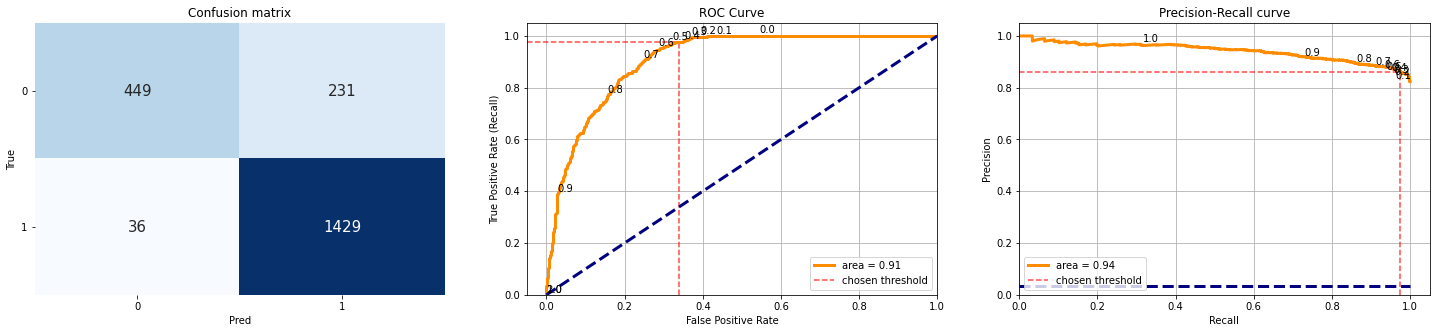

In [ ]:
from xgboost import XGBClassifier

model_ns = XGBClassifier(learning_rate=0.2, n_estimators = 200,nthread=8,max_depth = 2)
model_ns.fit(X_train, y_train)
predict_xgb = model_ns.predict(X_test)
predicted_prob = model_ns.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_xgb, predicted_prob, figsize=(25,5))

feeling / thinking

In [ ]:
#getting splited data
X_train, X_test, y_train, y_test = split_data(x,df_data['FT'])

Accuracy (overall correct predictions): 0.74
Auc: 0.83
Recall (all 1s predicted right): 0.82
Precision (confidence when predicting a 1): 0.73
F1 score: 0.77
Detail:
              precision    recall  f1-score   support

           0       0.77      0.65      0.70      1007
           1       0.73      0.82      0.77      1138

    accuracy                           0.74      2145
   macro avg       0.75      0.74      0.74      2145
weighted avg       0.74      0.74      0.74      2145



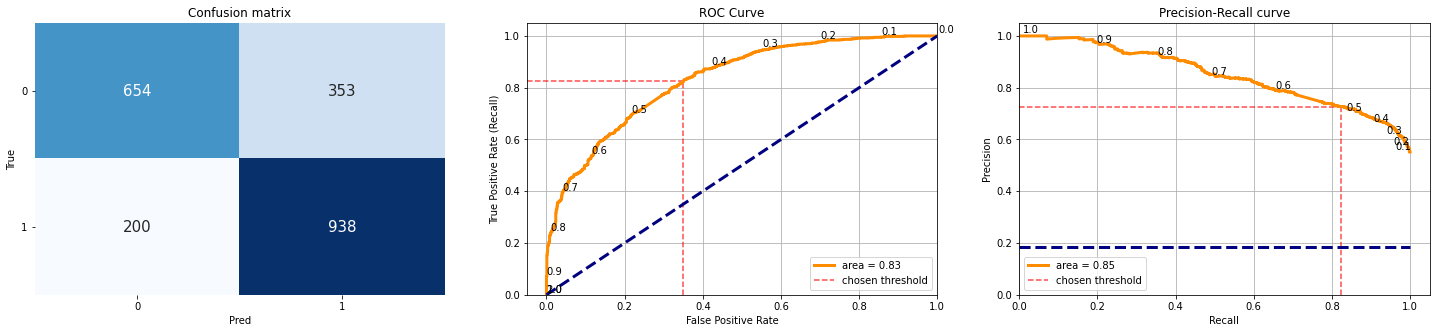

In [ ]:
from xgboost import XGBClassifier

model_ft = XGBClassifier(learning_rate=0.2, n_estimators = 200,nthread=8,max_depth = 2)
model_ft.fit(X_train, y_train)
predict_xgb = model_ft.predict(X_test)
predicted_prob = model_ft.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_xgb, predicted_prob, figsize=(25,5))

perceiving and judgemental

In [ ]:
#getting splited data
X_train, X_test, y_train, y_test = split_data(x,df_data['PJ'])

Accuracy (overall correct predictions): 0.7
Auc: 0.77
Recall (all 1s predicted right): 0.77
Precision (confidence when predicting a 1): 0.71
F1 score: 0.74
Detail:
              precision    recall  f1-score   support

           0       0.69      0.62      0.65       965
           1       0.71      0.77      0.74      1180

    accuracy                           0.70      2145
   macro avg       0.70      0.70      0.70      2145
weighted avg       0.70      0.70      0.70      2145



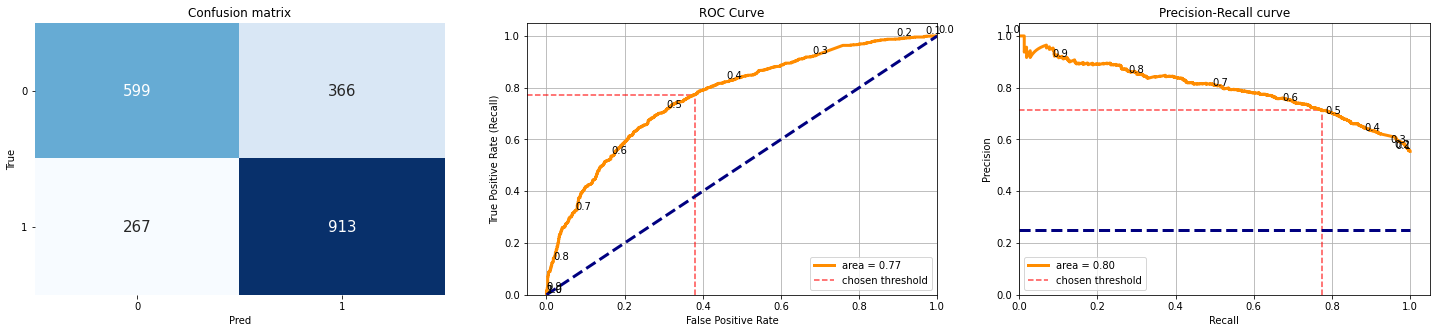

In [ ]:
from xgboost import XGBClassifier

model_pj = XGBClassifier(learning_rate=0.2, n_estimators = 200,nthread=8,max_depth = 2)
model_pj.fit(X_train, y_train)
predict_xgb = model_pj.predict(X_test)
predicted_prob = model_pj.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_xgb, predicted_prob, figsize=(25,5))

In [ ]:
def predict1(posts):

  #for storing the output
  result = []
  text_do = []
  text_donts = []
  text_ib = []

  #creating the data frame
  df_text = pd.DataFrame(data={'Text': [posts]})

  #data cleaning
  Corpus = text_process(df_text,columns='Text')

  #transforming the feature
  load_bow = load("/content/drive/My Drive/Outbound/bow.joblib.dat")
  x_trans = load_bow.transform(Corpus).toarray()

  tfidf_transformer = TfidfTransformer()
  x = tfidf_transformer.fit_transform(x_trans)

  #predicting the value Introvert / extrovert
  predictions = model.predict(x)
  prob_IE = model.predict_proba(x)
  result.append(predictions[0])

  #predicting the value Introvert / extrovert
  predictions_ns = model_ns.predict(x)
  prob_NS = model_ns.predict_proba(x)
  result.append(predictions_ns[0])

  #predicting the value Introvert / extrovert
  predictions_ft = model_ft.predict(x)
  prob_FT = model_ft.predict_proba(x)
  result.append(predictions_ft[0])

  #predicting the value Introvert / extrovert
  predictions_pj = model_pj.predict(x)
  prob_PJ = model_pj.predict_proba(x)
  result.append(predictions_pj[0])
  
  s,t = translate_data_back(result)
   
  if s=='INTP':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ENTP':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='INFJ':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='INTJ':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ENTJ':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ENFJ':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='INFP':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ENFP':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ISFP':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ISTP':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ISFJ':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ISTJ':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ESTP':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ESFP':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ESTJ':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  else:
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')

  draw_graph(prob_IE=prob_IE,prob_NS=prob_NS,prob_FT=prob_FT,prob_PJ=prob_PJ,s=s)
  #print(translate_data_back(result))
  print(s,t)

  return text_do,text_donts,text_ib,prob_IE,prob_NS,prob_FT,prob_PJ,result

ESTJ Person possesses following personality :-  Extroversion, Sensing, Thinking, Judging


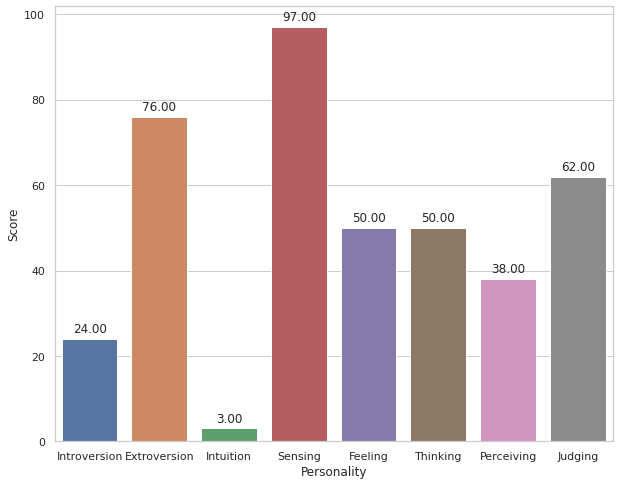

In [ ]:
my_posts  = """Getting started with data science and applying machine learning has never been as simple as it is now. There are many free and paid online tutorials and courses out there to help you to get started. I’ve recently started to learn, play, and work on Data Science & Machine Learning on Kaggle.com. In this brief post, I’d like to share my experience with the Kaggle Python Docker image, which simplifies the Data Scientist’s life.
Awesome #AWS monitoring introduction.
HPE Software (now @MicroFocusSW) won the platinum reader's choice #ITAWARDS 2017 in the new category #CloudMonitoring
Certified as AWS Certified Solutions Architect 
Hi, please have a look at my Udacity interview about online learning and machine learning,
Very interesting to see the  lessons learnt during the HP Operations Orchestration to CloudSlang journey. http://bit.ly/1Xo41ci 
I came across a post on devopsdigest.com and need your input: “70% DevOps organizations Unhappy with DevOps Monitoring Tools”
In a similar investigation I found out that many DevOps organizations use several monitoring tools in parallel. Senu, Nagios, LogStach and SaaS offerings such as DataDog or SignalFX to name a few. However, one element is missing: Consolidation of alerts and status in a single pane of glass, which enables fast remediation of application and infrastructure uptime and performance issues.
Sure, there are commercial tools on the market for exactly this use case but these tools are not necessarily optimized for DevOps.
So, here my question to you: In your DevOps project, have you encountered that the lack of consolidation of alerts and status is a real issue? If yes, how did you approach the problem? Or is an ChatOps approach just right?
You will probably hear more and more about ChatOps - at conferences, DevOps meet-ups or simply from your co-worker at the coffee station. ChatOps is a term and concept coined by GitHub. It's about the conversation-driven development, automation, and operations.
Now the question is: why and how would I, as an ops-focused engineer, implement and use ChatOps in my organization? The next question then is: How to include my tools into the chat conversation?
Let’s begin by having a look at a use case. The Closed Looped Incidents Process (CLIP) can be rejuvenated with ChatOps. The work from the incident detection runs through monitoring until the resolution of issues in your application or infrastructure can be accelerated with improved, cross-team communication and collaboration.
In this blog post, I am going to describe and share my experience with deploying HP Operations Manager i 10.0 (OMi) on HP Helion Public Cloud. An Infrastructure as a Service platform such as HP Helion Public Cloud Compute is a great place to quickly spin-up a Linux server and install HP Operations Manager i for various use scenarios. An example of a good use case is monitoring workloads across public clouds such as AWS and Azure."""

a,b,c,d,e,f,g = predict1(my_posts)

ESTJ Person possesses following personality :-  Extroversion, Sensing, Thinking, Judging


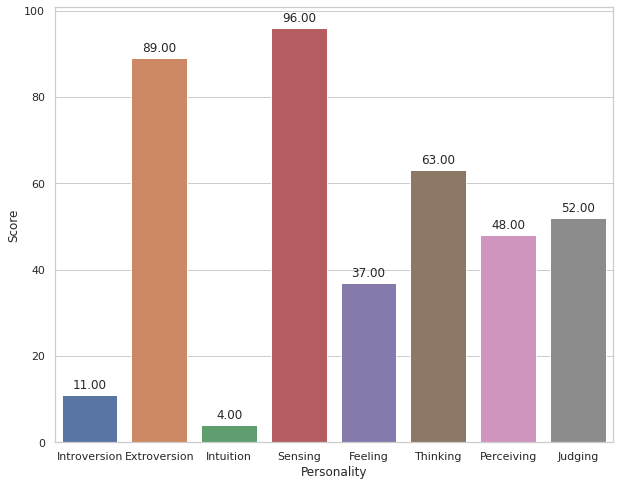

In [ ]:
my_posts  = """Getting started with data science and applying machine learning has never been as simple as it is now. There are many free and paid online tutorials and courses out there to help you to get started. I’ve recently started to learn, play, and work on Data Science & Machine Learning on Kaggle.com. In this brief post, I’d like to share my experience with the Kaggle Python Docker image, which simplifies the Data Scientist’s life.
Awesome #AWS monitoring introduction.
HPE Software (now @MicroFocusSW) won the platinum reader's choice #ITAWARDS 2017 in the new category #CloudMonitoring
Certified as AWS Certified Solutions Architect 
Hi, please have a look at my Udacity interview about online learning and machine learning,
Very interesting to see the  lessons learnt during the HP Operations Orchestration to CloudSlang journey. http://bit.ly/1Xo41ci 
I came across a post on devopsdigest.com and need your input: “70% DevOps organizations Unhappy with DevOps Monitoring Tools”
In a similar investigation I found out that many DevOps organizations use several monitoring tools in parallel. Senu, Nagios, LogStach and SaaS offerings such as DataDog or SignalFX to name a few. However, one element is missing: Consolidation of alerts and status in a single pane of glass, which enables fast remediation of application and infrastructure uptime and performance issues.
Sure, there are commercial tools on the market for exactly this use case but these tools are not necessarily optimized for DevOps.
So, here my question to you: In your DevOps project, have you encountered that the lack of consolidation of alerts and status is a real issue? If yes, how did you approach the problem? Or is an ChatOps approach just right?
You will probably hear more and more about ChatOps - at conferences, DevOps meet-ups or simply from your co-worker at the coffee station. ChatOps is a term and concept coined by GitHub. It's about the conversation-driven development, automation, and operations.
Now the question is: why and how would I, as an ops-focused engineer, implement and use ChatOps in my organization? The next question then is: How to include my tools into the chat conversation?
Let’s begin by having a look at a use case. The Closed Looped Incidents Process (CLIP) can be rejuvenated with ChatOps. The work from the incident detection runs through monitoring until the resolution of issues in your application or infrastructure can be accelerated with improved, cross-team communication and collaboration.
In this blog post, I am going to describe and share my experience with deploying HP Operations Manager i 10.0 (OMi) on HP Helion Public Cloud. An Infrastructure as a Service platform such as HP Helion Public Cloud Compute is a great place to quickly spin-up a Linux server and install HP Operations Manager i for various use scenarios. An example of a good use case is monitoring workloads across public clouds such as AWS and Azure."""

a,b,c,d,e,f,g,h = predict1(my_posts)

ESFJ Person possesses following personality :-  Extroversion, Sensing, Feeling, Judging


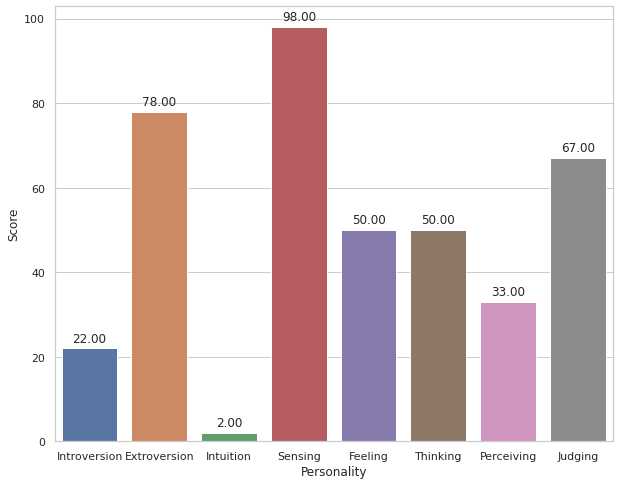

In [ ]:
my_posts  = """Getting started with data science and applying machine learning has never been as simple as it is now. There are many free and paid online tutorials and courses out there to help you to get started. I’ve recently started to learn, play, and work on Data Science & Machine Learning on Kaggle.com. In this brief post, I’d like to share my experience with the Kaggle Python Docker image, which simplifies the Data Scientist’s life.
Awesome #AWS monitoring introduction.
HPE Software (now @MicroFocusSW) won the platinum reader's choice #ITAWARDS 2017 in the new category #CloudMonitoring
Certified as AWS Certified Solutions Architect 
Hi, please have a look at my Udacity interview about online learning and machine learning,
Very interesting to see the  lessons learnt during the HP Operations Orchestration to CloudSlang journey. http://bit.ly/1Xo41ci 
I came across a post on devopsdigest.com and need your input: “70% DevOps organizations Unhappy with DevOps Monitoring Tools”
In a similar investigation I found out that many DevOps organizations use several monitoring tools in parallel. Senu, Nagios, LogStach and SaaS offerings such as DataDog or SignalFX to name a few. However, one element is missing: Consolidation of alerts and status in a single pane of glass, which enables fast remediation of application and infrastructure uptime and performance issues.
Sure, there are commercial tools on the market for exactly this use case but these tools are not necessarily optimized for DevOps.
So, here my question to you: In your DevOps project, have you encountered that the lack of consolidation of alerts and status is a real issue? If yes, how did you approach the problem? Or is an ChatOps approach just right?
You will probably hear more and more about ChatOps - at conferences, DevOps meet-ups or simply from your co-worker at the coffee station. ChatOps is a term and concept coined by GitHub. It's about the conversation-driven development, automation, and operations.
Now the question is: why and how would I, as an ops-focused engineer, implement and use ChatOps in my organization? The next question then is: How to include my tools into the chat conversation?
Let’s begin by having a look at a use case. The Closed Looped Incidents Process (CLIP) can be rejuvenated with ChatOps. The work from the incident detection runs through monitoring until the resolution of issues in your application or infrastructure can be accelerated with improved, cross-team communication and collaboration.
In this blog post, I am going to describe and share my experience with deploying HP Operations Manager i 10.0 (OMi) on HP Helion Public Cloud. An Infrastructure as a Service platform such as HP Helion Public Cloud Compute is a great place to quickly spin-up a Linux server and install HP Operations Manager i for various use scenarios. An example of a good use case is monitoring workloads across public clouds such as AWS and Azure."""

a,b,c,d,e,f,g,h = predict1(my_posts)

ESTJ Person possesses following personality :-  Extroversion, Sensing, Thinking, Judging


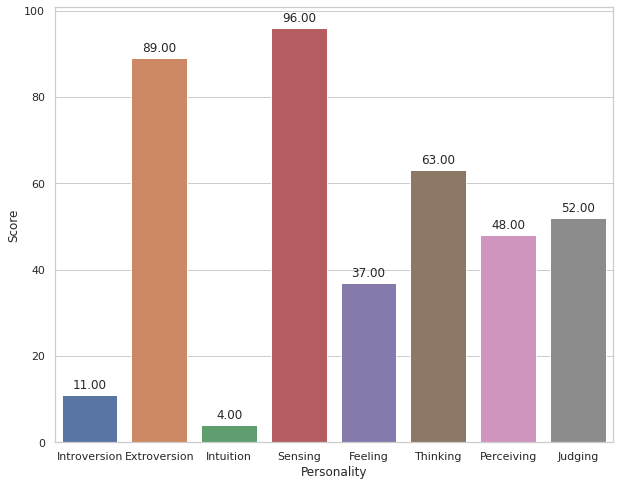

In [ ]:
my_posts  = """Getting started with data science and applying machine learning has never been as simple as it is now. There are many free and paid online tutorials and courses out there to help you to get started. I’ve recently started to learn, play, and work on Data Science & Machine Learning on Kaggle.com. In this brief post, I’d like to share my experience with the Kaggle Python Docker image, which simplifies the Data Scientist’s life.
Awesome #AWS monitoring introduction.
HPE Software (now @MicroFocusSW) won the platinum reader's choice #ITAWARDS 2017 in the new category #CloudMonitoring
Certified as AWS Certified Solutions Architect 
Hi, please have a look at my Udacity interview about online learning and machine learning,
Very interesting to see the  lessons learnt during the HP Operations Orchestration to CloudSlang journey. http://bit.ly/1Xo41ci 
I came across a post on devopsdigest.com and need your input: “70% DevOps organizations Unhappy with DevOps Monitoring Tools”
In a similar investigation I found out that many DevOps organizations use several monitoring tools in parallel. Senu, Nagios, LogStach and SaaS offerings such as DataDog or SignalFX to name a few. However, one element is missing: Consolidation of alerts and status in a single pane of glass, which enables fast remediation of application and infrastructure uptime and performance issues.
Sure, there are commercial tools on the market for exactly this use case but these tools are not necessarily optimized for DevOps.
So, here my question to you: In your DevOps project, have you encountered that the lack of consolidation of alerts and status is a real issue? If yes, how did you approach the problem? Or is an ChatOps approach just right?
You will probably hear more and more about ChatOps - at conferences, DevOps meet-ups or simply from your co-worker at the coffee station. ChatOps is a term and concept coined by GitHub. It's about the conversation-driven development, automation, and operations.
Now the question is: why and how would I, as an ops-focused engineer, implement and use ChatOps in my organization? The next question then is: How to include my tools into the chat conversation?
Let’s begin by having a look at a use case. The Closed Looped Incidents Process (CLIP) can be rejuvenated with ChatOps. The work from the incident detection runs through monitoring until the resolution of issues in your application or infrastructure can be accelerated with improved, cross-team communication and collaboration.
In this blog post, I am going to describe and share my experience with deploying HP Operations Manager i 10.0 (OMi) on HP Helion Public Cloud. An Infrastructure as a Service platform such as HP Helion Public Cloud Compute is a great place to quickly spin-up a Linux server and install HP Operations Manager i for various use scenarios. An example of a good use case is monitoring workloads across public clouds such as AWS and Azure."""

a,b,c,d,e,f,g,h = predict1(my_posts)

ESTJ Person possesses following personality :-  Extroversion, Sensing, Thinking, Judging


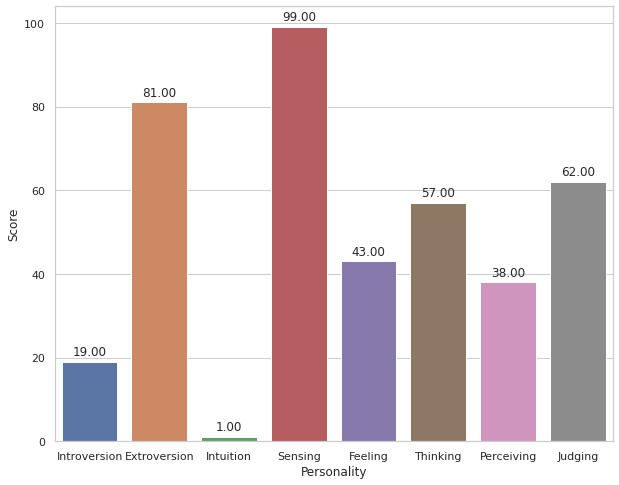

In [ ]:
my_posts = """SALES MANAGEMENT / BUSINESS DEVELOPMENT / PROJECT MANAGEMENTDOMESTIC & INTERNATIONAL KEY ACCOUNT MANAGEMENTBusiness and Sales Executive with 20 years of accomplished career track, reflecting extensive experience and dynamic record-breaking performance in the Medical Industry markets. Exceptional communicator, strong team player, flexible self-starter with consultative sales style, strong negotiations skills, exceptional problem solving abilities, and accurate customer assessment aptitude. Manage and lead teams to success, drive new business through key accounts management, establish partnerships, manage solid distributor relationship for increased profitability and sales volumes. Very well organized, accurate and on-time administrative work, with a track record that demonstrates self-motivation, creativity, sales team leadership, initiative to achieve corporate, team and personal goals. Experience in the following markets: Medical Devices, Medical Disposables, Capital Equipment, Pharmaceuticals."""
#data cleaningre
a,b,c,d,e,f,g = predict1(my_posts)

ESFJ Person possesses following personality :-  Extroversion, Sensing, Feeling, Judging


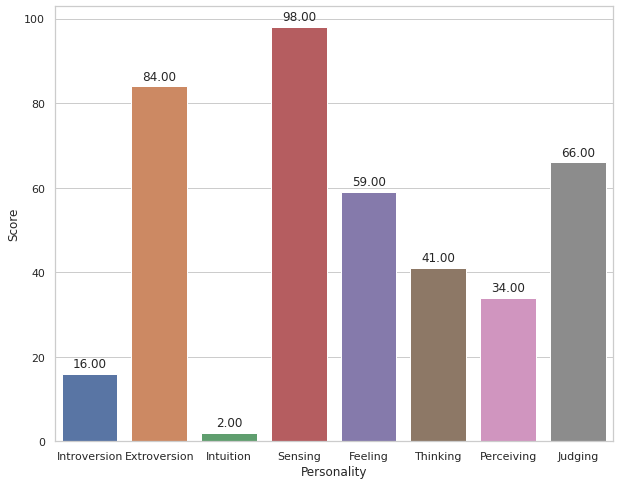

In [ ]:
my_posts = """SALES MANAGEMENT / BUSINESS DEVELOPMENT / PROJECT MANAGEMENTDOMESTIC & INTERNATIONAL KEY ACCOUNT MANAGEMENTBusiness and Sales Executive with 20 years of accomplished career track, reflecting extensive experience and dynamic record-breaking performance in the Medical Industry markets. Exceptional communicator, strong team player, flexible self-starter with consultative sales style, strong negotiations skills, exceptional problem solving abilities, and accurate customer assessment aptitude. Manage and lead teams to success, drive new business through key accounts management, establish partnerships, manage solid distributor relationship for increased profitability and sales volumes. Very well organized, accurate and on-time administrative work, with a track record that demonstrates self-motivation, creativity, sales team leadership, initiative to achieve corporate, team and personal goals. Experience in the following markets: Medical Devices, Medical Disposables, Capital Equipment, Pharmaceuticals."""
#data cleaningre
a,b,c,d,e,f,g,h = predict1(my_posts)

ESTJ Person possesses following personality :-  Extroversion, Sensing, Thinking, Judging


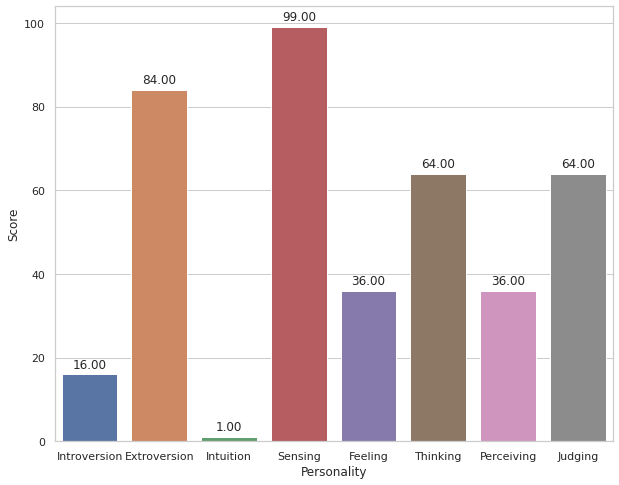

In [ ]:
my_posts = """SALES MANAGEMENT / BUSINESS DEVELOPMENT / PROJECT MANAGEMENTDOMESTIC & INTERNATIONAL KEY ACCOUNT MANAGEMENTBusiness and Sales Executive with 20 years of accomplished career track, reflecting extensive experience and dynamic record-breaking performance in the Medical Industry markets. Exceptional communicator, strong team player, flexible self-starter with consultative sales style, strong negotiations skills, exceptional problem solving abilities, and accurate customer assessment aptitude. Manage and lead teams to success, drive new business through key accounts management, establish partnerships, manage solid distributor relationship for increased profitability and sales volumes. Very well organized, accurate and on-time administrative work, with a track record that demonstrates self-motivation, creativity, sales team leadership, initiative to achieve corporate, team and personal goals. Experience in the following markets: Medical Devices, Medical Disposables, Capital Equipment, Pharmaceuticals."""
#data cleaningre
a,b,c,d,e,f,g,h = predict1(my_posts)

In [ ]:
h

[0, 0, 0, 0]

ESFJ Person possesses following personality :-  Extroversion, Sensing, Feeling, Judging


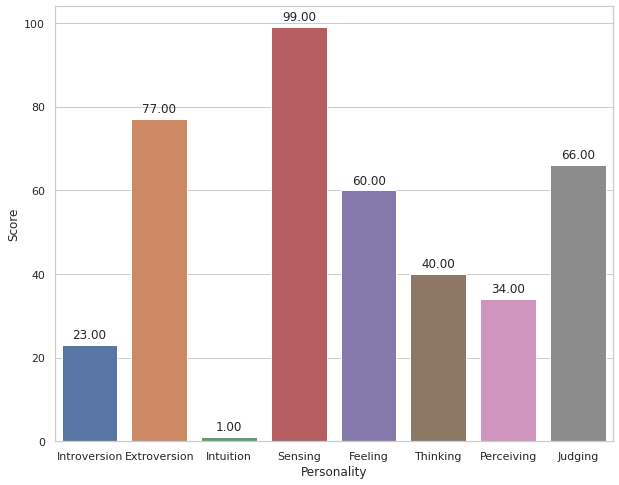

In [ ]:
my_posts  = """â€¢Having 12 Yrs of Experience in Marketing & International Business Development in Pharmaceutical sector.â€¢Experienced in managing operations in large business area, formulating and implementing strategies, developing new markets for business excellence.â€¢Adept at developing the distribution network infrastructure and channel management.â€¢Proven track record acquiring product registrations for several products in ASEAN Region.â€¢An effective communicator with abilities in implementing various sales promotional activities and escalating business turnovers during carrier span.â€¢Excellent logical, Analytical skills and an articulate with very good communication skills.â€¢In the total experience profile, managed and achieved targets in the segments of Cardiovascular, Respiratory care, Antibiotics, Multivitamins,Neutracuticals and wide range OTC products.â€¢Traveled extensively in the above mentioned countries to explore the markets and taken in-depth market survey to identify the distributor with a good margin which is profitable for the company.â€¢Wide experience across emerging markets of Asia, Latam countries . From business start ups to sustainable business with adaptability to different cultures and markets, successfully led change management.â€¢Experience in business feasibility, business planning, entry strategy, right product selection and portfolio development.â€¢Set up overseas office with minimum guidance, operations management, problem solving, crisis management.â€¢5 years overseas stay and travel to different countries gave a very good exposure and confidence to do business and deal people overseas.â€¢Product identification,ideation, launch plan, successful launches and making Mega Brands, Portfolio Management, KoL identification, CRM, Key Account Management.â€¢Exposure to many segments of pharmaceutical business, Passion for International Marketing, Business Development.Achieved targets with innovative idea"""

a,b,c,d,e,f,g = predict1(my_posts)

ESTJ Person possesses following personality :-  Extroversion, Sensing, Thinking, Judging


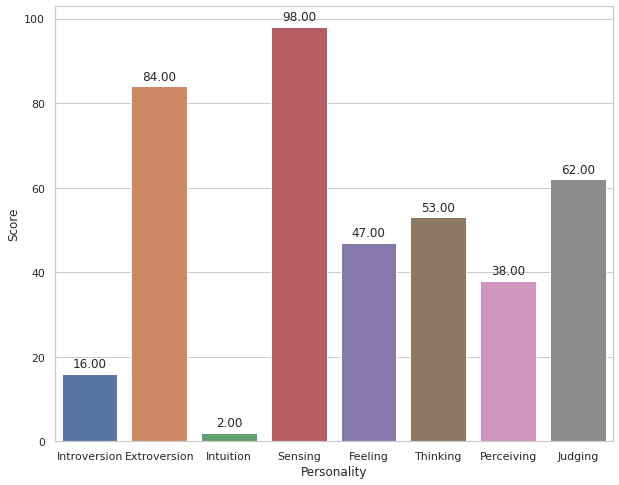

In [ ]:
my_posts  = """â€¢Having 12 Yrs of Experience in Marketing & International Business Development in Pharmaceutical sector.â€¢Experienced in managing operations in large business area, formulating and implementing strategies, developing new markets for business excellence.â€¢Adept at developing the distribution network infrastructure and channel management.â€¢Proven track record acquiring product registrations for several products in ASEAN Region.â€¢An effective communicator with abilities in implementing various sales promotional activities and escalating business turnovers during carrier span.â€¢Excellent logical, Analytical skills and an articulate with very good communication skills.â€¢In the total experience profile, managed and achieved targets in the segments of Cardiovascular, Respiratory care, Antibiotics, Multivitamins,Neutracuticals and wide range OTC products.â€¢Traveled extensively in the above mentioned countries to explore the markets and taken in-depth market survey to identify the distributor with a good margin which is profitable for the company.â€¢Wide experience across emerging markets of Asia, Latam countries . From business start ups to sustainable business with adaptability to different cultures and markets, successfully led change management.â€¢Experience in business feasibility, business planning, entry strategy, right product selection and portfolio development.â€¢Set up overseas office with minimum guidance, operations management, problem solving, crisis management.â€¢5 years overseas stay and travel to different countries gave a very good exposure and confidence to do business and deal people overseas.â€¢Product identification,ideation, launch plan, successful launches and making Mega Brands, Portfolio Management, KoL identification, CRM, Key Account Management.â€¢Exposure to many segments of pharmaceutical business, Passion for International Marketing, Business Development.Achieved targets with innovative idea"""

a,b,c,d,e,f,g,h = predict1(my_posts)

ESFJ Person possesses following personality :-  Extroversion, Sensing, Feeling, Judging


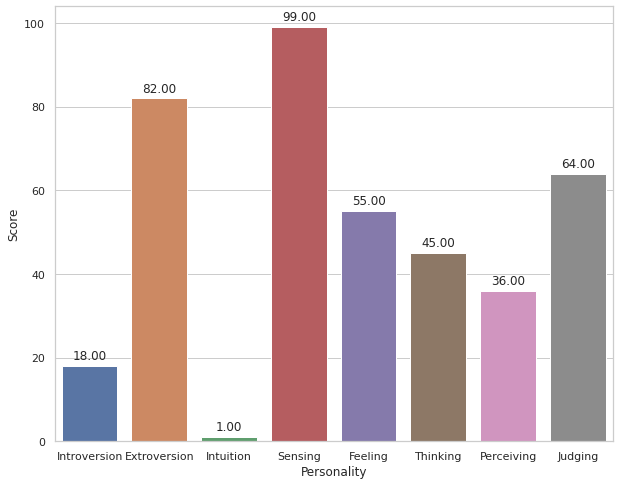

In [ ]:
my_posts  = """â€¢Having 12 Yrs of Experience in Marketing & International Business Development in Pharmaceutical sector.â€¢Experienced in managing operations in large business area, formulating and implementing strategies, developing new markets for business excellence.â€¢Adept at developing the distribution network infrastructure and channel management.â€¢Proven track record acquiring product registrations for several products in ASEAN Region.â€¢An effective communicator with abilities in implementing various sales promotional activities and escalating business turnovers during carrier span.â€¢Excellent logical, Analytical skills and an articulate with very good communication skills.â€¢In the total experience profile, managed and achieved targets in the segments of Cardiovascular, Respiratory care, Antibiotics, Multivitamins,Neutracuticals and wide range OTC products.â€¢Traveled extensively in the above mentioned countries to explore the markets and taken in-depth market survey to identify the distributor with a good margin which is profitable for the company.â€¢Wide experience across emerging markets of Asia, Latam countries . From business start ups to sustainable business with adaptability to different cultures and markets, successfully led change management.â€¢Experience in business feasibility, business planning, entry strategy, right product selection and portfolio development.â€¢Set up overseas office with minimum guidance, operations management, problem solving, crisis management.â€¢5 years overseas stay and travel to different countries gave a very good exposure and confidence to do business and deal people overseas.â€¢Product identification,ideation, launch plan, successful launches and making Mega Brands, Portfolio Management, KoL identification, CRM, Key Account Management.â€¢Exposure to many segments of pharmaceutical business, Passion for International Marketing, Business Development.Achieved targets with innovative idea"""

a,b,c,d,e,f,g,h = predict1(my_posts)

ESFJ Person possesses following personality :-  Extroversion, Sensing, Feeling, Judging


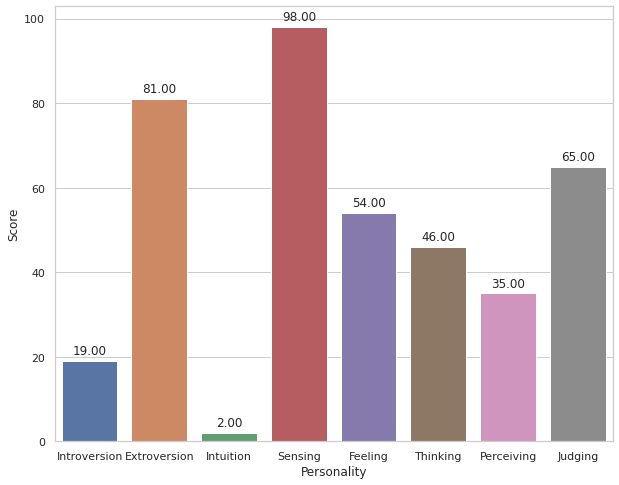

In [ ]:
my_posts  = """Operations Management Specialist and Consultant, 22 + years of experience in leading Wall Street firms supporting small, medium and large trading desks in front, middle and back office environments. Wide range of experience, managing MBS allocations, trade support, settlements, client relationship management and software support across a broad spectrum of Fixed Income productsAvailable for Consulting, Permanent or Consult to Perm opportunities"""

a,b,c,d,e,f,g,h = predict1(my_posts)

ESFJ Person possesses following personality :-  Extroversion, Sensing, Feeling, Judging


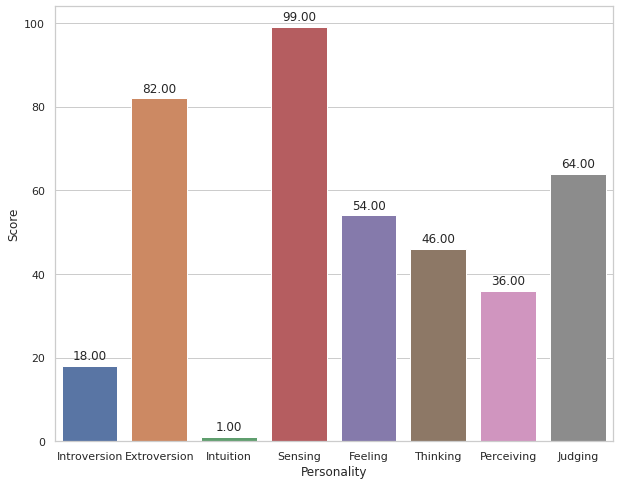

In [ ]:
my_posts  = """Operations Management Specialist and Consultant, 22 + years of experience in leading Wall Street firms supporting small, medium and large trading desks in front, middle and back office environments. Wide range of experience, managing MBS allocations, trade support, settlements, client relationship management and software support across a broad spectrum of Fixed Income productsAvailable for Consulting, Permanent or Consult to Perm opportunities"""

a,b,c,d,e,f,g,h = predict1(my_posts)

ESFJ Person possesses following personality :-  Extroversion, Sensing, Feeling, Judging


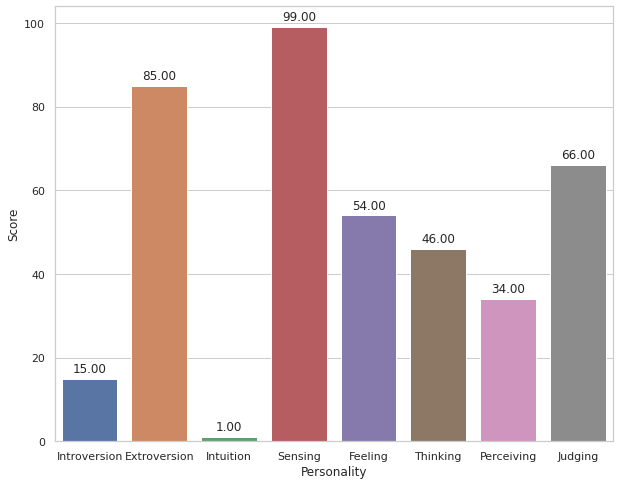

In [ ]:
my_posts  = """It requires belief that is outside of a logical framework and isnâ€™t worth positing because itâ€™s just you affirming your own beliefs which means nothing to anyone."""
a,b,c,d,e,f,g,h = predict1(my_posts)

ESFJ Person possesses following personality :-  Extroversion, Sensing, Feeling, Judging


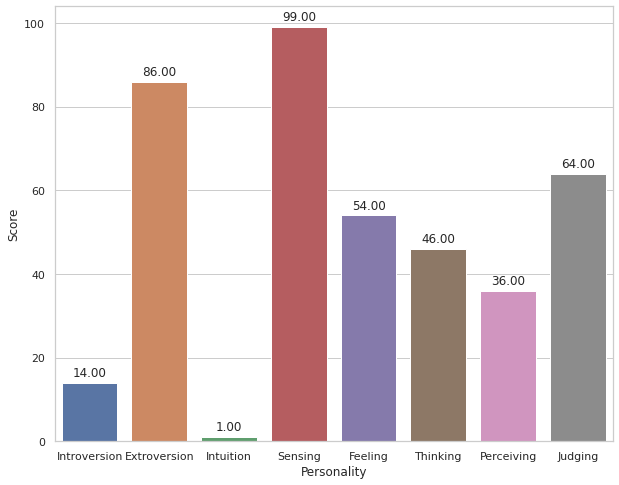

In [ ]:
my_posts  = """It requires belief that is outside of a logical framework and isnâ€™t worth positing because itâ€™s just you affirming your own beliefs which means nothing to anyone."""
a,b,c,d,e,f,g,h = predict1(my_posts)

ESTJ Person possesses following personality :-  Extroversion, Sensing, Thinking, Judging


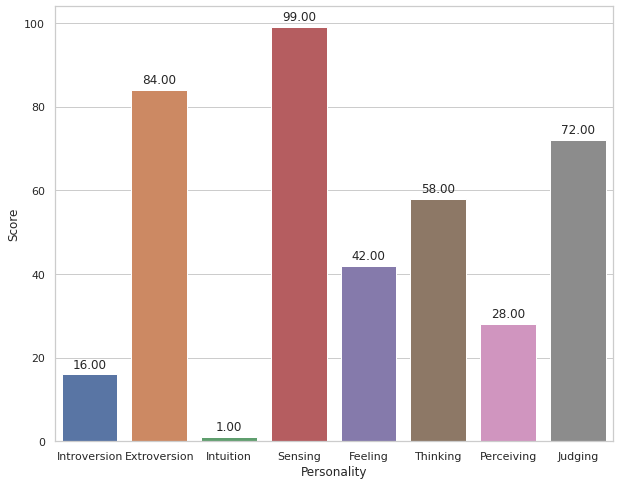

In [ ]:
my_posts  = """OBJECTIVE<Primary> Work on an interesting and challenging Silverlight 4.0 Application Development Project<Secondary> Serve as an on-call resource for remote Internet or Client/Server application development projectsPROFILE<Experience> Senior Application Development: 17+ yr developing, 12+ yr contracting, Microsoft centric<Status> Available for onsite or remote development. Travel under certain circumstances<Studying> OData, Ninject, Guidance Automation Extensions & Toolkit, MS Blueprints, MS Sync Framework, Enterprise Library 5.0<Resume> Resume has been condensed and optimized for faster reading and automatic processingOlder experience and contract information has been removed to focus on current relevant technologiesSKILLS HIGHLIGHT<MS .NET> C#, VB.NET, VS.NET, ADO.NET, ASP.NET, XML, XSD, Win Forms, Web Server/User Controls, Namespaces, Mail,Web Forms, Collections, Threading, Remoting, IO, Security, Mail, HTTP Classes, Serialization, Regex, Debugging, Interfaces, Events, Delegation, Streams, Windows Services, Exceptions, Deployment, Obfuscation, Caching, Custom Session Objects, BLOB, Impersonation, Assemblies, GAC, GUID, Providers, Membership, GUI Form Design, Class Objects, Data Access, Win32 API, DLL Creation, Third Party Objects, Iprincipal, Reflection, POCO, Generics, LINQ, Lambda Expressions<Silverlight> XAML, XAML Power Tools, SL Toolkit, Blend , Local Isolated Storage, Out Of Browser, WCF RIA, Blend, Data Binding, Embedded Database<Frameworks/Patterns> Caliburn, T4 Templates, Sculpture & Molds, Enterprise Library, MVVM, Dependency Injection, CRUD<MS SQL Server> SQL, T-SQL, PK-FK, Triggers, Views, Stored Procedures, Cursors, @variables, @@functions, SQL-Mail, Functions, DBA (65%)<Internet> DOM, ASP, HTML, DHTML, XML, XSTL, CSS, JavaScript, VBScript, Active-X, SSL, IIS, Database<Database Design> Needs assessment, conceptual design, complex RDBMS architectures, normalization"""


a,b,c,d,e,f,g,h = predict1(my_posts)

ESFJ Person possesses following personality :-  Extroversion, Sensing, Feeling, Judging


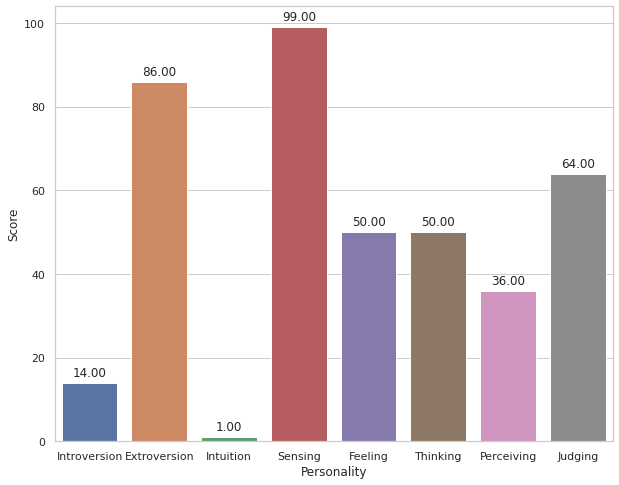

In [ ]:
my_posts  = """Integrating creative design with commercial manufacturing and sound business practises to produce innovative product / communications. Experience of brand direction / project and design management within a variety of sectors, including the FMCG market. A desire and flair for creative design, coupled with the experience to implement and deliver strategic, commercial change for the client."""

a,b,c,d,e,f,g,h = predict1(my_posts)

ESFJ Person possesses following personality :-  Extroversion, Sensing, Feeling, Judging


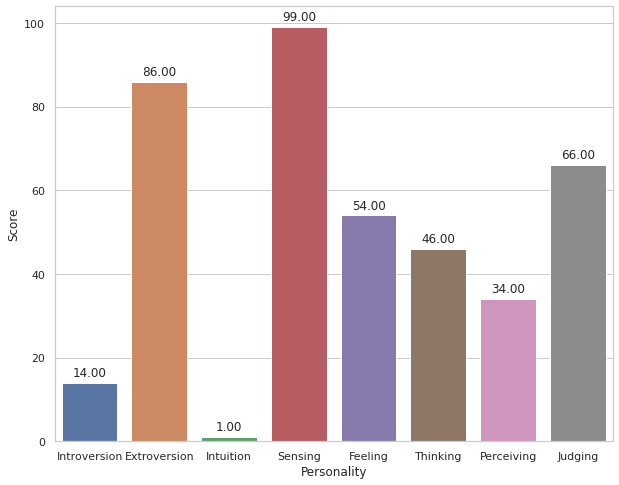

In [ ]:
my_posts  = """Integrating creative design with commercial manufacturing and sound business practises to produce innovative product / communications. Experience of brand direction / project and design management within a variety of sectors, including the FMCG market. A desire and flair for creative design, coupled with the experience to implement and deliver strategic, commercial change for the client."""

a,b,c,d,e,f,g,h = predict1(my_posts)

ESFJ Person possesses following personality :-  Extroversion, Sensing, Feeling, Judging


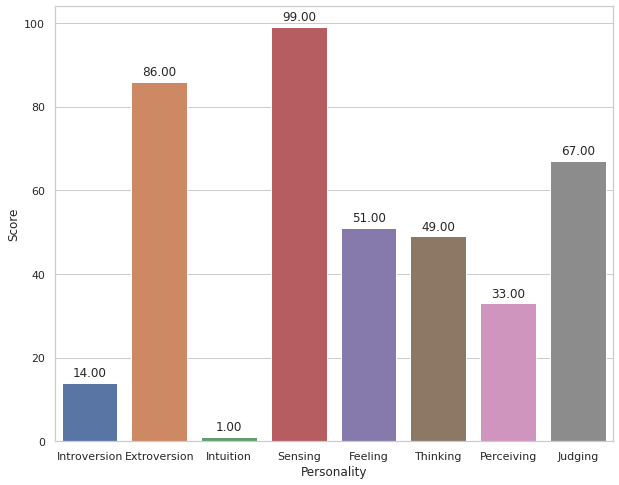

In [ ]:
my_posts  = """Love to work on deadline & data-driven, dynamic teams with a sense of fun and a sense of commitment. Attracted to projects centered on customer benefits that integrate e-commerce and social platforms, building infrastructure, and a focus on testing, learning, and measurement."""
a,b,c,d,e,f,g,h = predict1(my_posts)

ESFJ Person possesses following personality :-  Extroversion, Sensing, Feeling, Judging


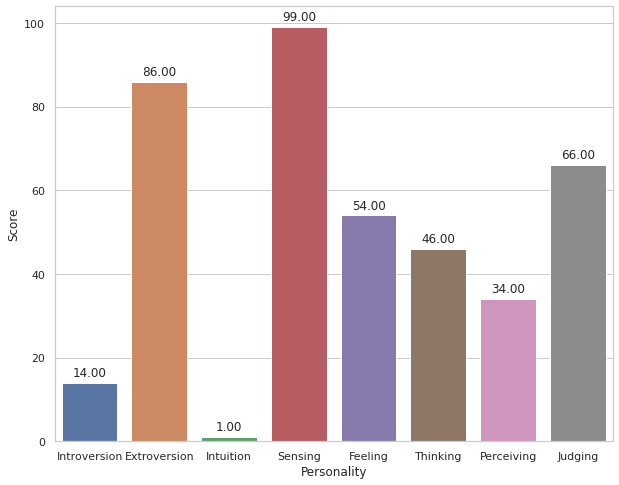

In [ ]:
my_posts  = """Love to work on deadline & data-driven, dynamic teams with a sense of fun and a sense of commitment. Attracted to projects centered on customer benefits that integrate e-commerce and social platforms, building infrastructure, and a focus on testing, learning, and measurement."""
a,b,c,d,e,f,g,h = predict1(my_posts)

ESTJ Person possesses following personality :-  Extroversion, Sensing, Thinking, Judging


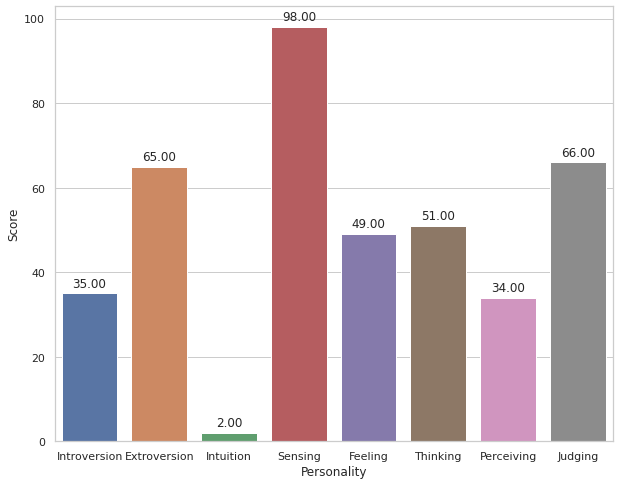

In [ ]:
my_posts  = """'18/37 @.@|||Science  is not perfect. No scientist claims that it is, or that scientific  information will not be revised as we discover new things.  Rational  thinking has been very useful to our society....|||INFP- Edgar Allen Poe was an INFP and he's in your siggy.|||People see the obvious Fi and are quick to put her as INFP. I agree that she has no Ne. I see her as an ISFP. Compare her to Haku (definite INFP). She is flat through most of Naruto.. but I don't...|||Lets get this party started  66314|||I did not say it disproved God. I merely said that I found such methods disturbing. Although, it does bring up certain questions. God is in control of the universe, and the governments of the world,...|||Surprisingly, I could not find a thread about this on perc even with Google. So, here you go.  Watch Jesus Camp online - Watch Movies Online, Full Movies, Download  I was disturbed watching this...|||A metaphysical gun (Hell) held to someone's head can be just as effective as an actual gun.  Do you not find these methods disturbing? Watch Jesus Camp online - Watch Movies Online, Full Movies,...|||Unstable is not the right word. We are usually pretty emotionally flat-lined. But, when we do have to deal with our own emotions we can be very bad at it. In high school my feelings of attraction...|||Well, I went to someone's wedding and dipped everything in the chocolate fountain and ate it. I dipped the fruit, the fish, and even the Hershey's kisses. And I drank two little jars of honey they...|||That post you  quoted was from two and a half years ago. Since then, I've come to a better explanation.  INTPs may not be as externally certain as INTJs, but they are more certain internally. They...|||This is how I deal with the INFP I'm in a relationship with.  I am often tempted to avoid hurting them even if it means fudging the truth, telling them only what they want to hear. If I do that, it...|||Never heard of it till now. I watch a loooot of anime, but I get it from animedreaming.tv mostly; I am not a member of any anime board.|||The legs are nice, but her expression is all wrong. That is not her private sad face; I don't know what it is. See, I have her evil grin <B|||Kokiri Connect. Becuase I couldn't rememeber how to spell Kokoro Connect so I let Google do it.|||Inaba from Kokoro Connect. Because I relate to her and I enjoy looking at her (I have to look at my avatar alot).|||I'd like to see someone react when they are told they have   hippopotomonstrosesquipedaliophobia.|||She doesn't trust you or respect you. A break would be good to test if she will change. If she doesn't, you have to think about what will make you happy in the long term. Next time, establish ground...|||I don't think any INTJ is not going to do this if they have a choice. Though, until I got the internet in my late teens I didn't explore many subjects I was interested in in depth. Of course, it...|||No, I don't smoke. I have an addictive personality, and I don't think I would be able to stop if I started.|||Destroying his reputation by revealing what he has done could cause him to lose a lot of power... but if people knew things he had done, a certain person would kill him and end up in jail.   There...|||People like people like themselves; this is the number 1 indicator of attraction. Seeing as most people are sensors it is not surprising that they do not care for my personality.  Woman have...|||My best friend is an INTJ. We have so much in common even for two INTJs; she understands me better than anyone. It took a loooong time for us to become close. We put up a lot of barriers.  I get...|||I can tell you about a sociopath I know in real life. Not an INTJ, an ENTP or INTP.  -Tells all his problems to people shortly after meeting them to attempt to gain their sympathy so they can be...|||Light (at least in the beggning) and Lelouch did ultimately have good goals, even if their methods were evil.  Lelouch did seem to feel remorse at times; a sociopath would never consider taking...|||Nobody panics when things go  according to plan. Even if the plan is horrifying. If tomorrow I tell  the press that like a gang banger, will get shot, or a truckload of  soldiers will be blown up,...|||1. Code Geass  2. Steins; Gate (It was hardest to pick between this and Geass, but I  think Geass just barely beats it. I will say it is very slow in the  beginning, but everything that happens in...|||Looking back at this post from 2.5 years ago... Emil, Asahina, and Hinata are actually ISFPs. Maybe Kimmimaro and Alphonse as well.  I really don't know Li Xingke's type... its been awhile since I...|||Focus on learning the system, and the details should fall into place as you go along. For example, learning C++, I read about how it worked, then wrote some programs and only bothered figuring out...|||glad you recognize my username.   Yes, until you said INFJ (that type uses Fe/Ti). The four types that use (Fi&Te)/(Te&Fi) are in my previous post.|||INFP- Going out with one now. We don't understand each other in some ways (though understanding is a lot better than most type matches), but we challenge each other and help each other grow. We have...|||Welcome. Now bring me some Pizza.   Actually, that could happen to me after I'm done with my English degree XD|||You need to think about the reasons for what you want and about how realistic each of your goals are. Maybe one is more of a fantasy and one is actually worthwhile? That's what I would do anyway,...|||What my previous post said was: you seem like a dominant Fi. Do you do all this Ne thing or this FiNe thing. Put into terms that the OP understands.   The 8 letters are intended to be shorthand for...|||You seem like an obvious I, F, and P. INFP is the strongest possibility. Possibly ISFP, though. How do you brainstorm? Do you overthink things?|||Combining your anxiety and avoidance scores, you fall      into the secure quadrant.  Previous research on attachment styles indicates that     secure people tend to have relatively enduring and...|||I don't think you can simply reach into your mind anytime to tell if you love someone.   Perhaps you have fantasized for a long time and expect a real relationship to be like that in some ways. But...|||I don't think its impossible to doublethink, only impossible to remain in that state (which could explain why oceania fell after the end).  The hard atheists I do not disagree with. Anyway,...|||Cows are a religious subject (Hindu) XD   If the denial of a religion is a religion, then most or all of us here are ascientologists, for example. Most everyone would have, what? at least thousands...|||By that definition anything could be defined as a religion by attaching the suffix -ism... and then the word religion loses its meaning. I would say that religion has both a precise and general...|||There are no practices required to be an atheist. All that is required is a disbelief in deities. Other than that, atheists can have widely different beliefs. It is too general a term to be called a...|||My guess is ENTP, though it is hard to say just from this.  Have you studied up on cognitive functions? If not, learning how each works and identifying which ones you use would be very helpful.|||I believe it has gone  through too many human hands to be thought of wholly as the word of God  (or to be followed unquestionably). Yes, most useful when thought of as  a text by man about God.  ...|||Apparently, you need to pose as a gay guy to pick up women.  But, seriously. Its 2012. You have a world of media at your fingertips. In a poll that appears to be from eHarmony (though it is...|||We are playing a game called Mafia. We have to vote on who to kill for this round, who we think is part of the Mafia. Rob (names made up) says, kill Joe.  I suggest killing Rob. Rob says, Don't...|||what you need to know as an INTJ fiction writer: http://phantomshine.blogspot.com/2012/05/writer-analysis-through-mbti.html   I grow tedious of gratuitous visual details... though, images are...|||Bolded are ones I actually live with.  Mother- ISFJ Father- ISTJ Sister- ISTP Half-Sister- ESFJ? Grand-mother (mother's side)- ENFP Step-brother-ESFP Step-father- ESFP?|||Very interesting. Explains why these two types often see each other as close-minded or arrogant.|||There are as many INTJs as there needs to be. If everyone is a leader, who is going to follow? And who is going to take the jobs that no intuitive would want? There is a part in Brave New World where...|||Mm, probably INTP now that I have become more familiar with that type.'"""
a,b,c,d,e,f,g,h = predict1(my_posts)

ESTP Person possesses following personality :-  Extroversion, Sensing, Thinking, Perceiving


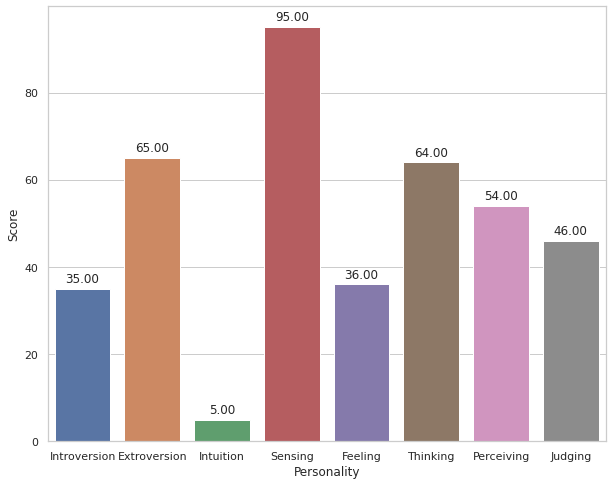

In [ ]:
my_posts  = """'18/37 @.@|||Science  is not perfect. No scientist claims that it is, or that scientific  information will not be revised as we discover new things.  Rational  thinking has been very useful to our society....|||INFP- Edgar Allen Poe was an INFP and he's in your siggy.|||People see the obvious Fi and are quick to put her as INFP. I agree that she has no Ne. I see her as an ISFP. Compare her to Haku (definite INFP). She is flat through most of Naruto.. but I don't...|||Lets get this party started  66314|||I did not say it disproved God. I merely said that I found such methods disturbing. Although, it does bring up certain questions. God is in control of the universe, and the governments of the world,...|||Surprisingly, I could not find a thread about this on perc even with Google. So, here you go.  Watch Jesus Camp online - Watch Movies Online, Full Movies, Download  I was disturbed watching this...|||A metaphysical gun (Hell) held to someone's head can be just as effective as an actual gun.  Do you not find these methods disturbing? Watch Jesus Camp online - Watch Movies Online, Full Movies,...|||Unstable is not the right word. We are usually pretty emotionally flat-lined. But, when we do have to deal with our own emotions we can be very bad at it. In high school my feelings of attraction...|||Well, I went to someone's wedding and dipped everything in the chocolate fountain and ate it. I dipped the fruit, the fish, and even the Hershey's kisses. And I drank two little jars of honey they...|||That post you  quoted was from two and a half years ago. Since then, I've come to a better explanation.  INTPs may not be as externally certain as INTJs, but they are more certain internally. They...|||This is how I deal with the INFP I'm in a relationship with.  I am often tempted to avoid hurting them even if it means fudging the truth, telling them only what they want to hear. If I do that, it...|||Never heard of it till now. I watch a loooot of anime, but I get it from animedreaming.tv mostly; I am not a member of any anime board.|||The legs are nice, but her expression is all wrong. That is not her private sad face; I don't know what it is. See, I have her evil grin <B|||Kokiri Connect. Becuase I couldn't rememeber how to spell Kokoro Connect so I let Google do it.|||Inaba from Kokoro Connect. Because I relate to her and I enjoy looking at her (I have to look at my avatar alot).|||I'd like to see someone react when they are told they have   hippopotomonstrosesquipedaliophobia.|||She doesn't trust you or respect you. A break would be good to test if she will change. If she doesn't, you have to think about what will make you happy in the long term. Next time, establish ground...|||I don't think any INTJ is not going to do this if they have a choice. Though, until I got the internet in my late teens I didn't explore many subjects I was interested in in depth. Of course, it...|||No, I don't smoke. I have an addictive personality, and I don't think I would be able to stop if I started.|||Destroying his reputation by revealing what he has done could cause him to lose a lot of power... but if people knew things he had done, a certain person would kill him and end up in jail.   There...|||People like people like themselves; this is the number 1 indicator of attraction. Seeing as most people are sensors it is not surprising that they do not care for my personality.  Woman have...|||My best friend is an INTJ. We have so much in common even for two INTJs; she understands me better than anyone. It took a loooong time for us to become close. We put up a lot of barriers.  I get...|||I can tell you about a sociopath I know in real life. Not an INTJ, an ENTP or INTP.  -Tells all his problems to people shortly after meeting them to attempt to gain their sympathy so they can be...|||Light (at least in the beggning) and Lelouch did ultimately have good goals, even if their methods were evil.  Lelouch did seem to feel remorse at times; a sociopath would never consider taking...|||Nobody panics when things go  according to plan. Even if the plan is horrifying. If tomorrow I tell  the press that like a gang banger, will get shot, or a truckload of  soldiers will be blown up,...|||1. Code Geass  2. Steins; Gate (It was hardest to pick between this and Geass, but I  think Geass just barely beats it. I will say it is very slow in the  beginning, but everything that happens in...|||Looking back at this post from 2.5 years ago... Emil, Asahina, and Hinata are actually ISFPs. Maybe Kimmimaro and Alphonse as well.  I really don't know Li Xingke's type... its been awhile since I...|||Focus on learning the system, and the details should fall into place as you go along. For example, learning C++, I read about how it worked, then wrote some programs and only bothered figuring out...|||glad you recognize my username.   Yes, until you said INFJ (that type uses Fe/Ti). The four types that use (Fi&Te)/(Te&Fi) are in my previous post.|||INFP- Going out with one now. We don't understand each other in some ways (though understanding is a lot better than most type matches), but we challenge each other and help each other grow. We have...|||Welcome. Now bring me some Pizza.   Actually, that could happen to me after I'm done with my English degree XD|||You need to think about the reasons for what you want and about how realistic each of your goals are. Maybe one is more of a fantasy and one is actually worthwhile? That's what I would do anyway,...|||What my previous post said was: you seem like a dominant Fi. Do you do all this Ne thing or this FiNe thing. Put into terms that the OP understands.   The 8 letters are intended to be shorthand for...|||You seem like an obvious I, F, and P. INFP is the strongest possibility. Possibly ISFP, though. How do you brainstorm? Do you overthink things?|||Combining your anxiety and avoidance scores, you fall      into the secure quadrant.  Previous research on attachment styles indicates that     secure people tend to have relatively enduring and...|||I don't think you can simply reach into your mind anytime to tell if you love someone.   Perhaps you have fantasized for a long time and expect a real relationship to be like that in some ways. But...|||I don't think its impossible to doublethink, only impossible to remain in that state (which could explain why oceania fell after the end).  The hard atheists I do not disagree with. Anyway,...|||Cows are a religious subject (Hindu) XD   If the denial of a religion is a religion, then most or all of us here are ascientologists, for example. Most everyone would have, what? at least thousands...|||By that definition anything could be defined as a religion by attaching the suffix -ism... and then the word religion loses its meaning. I would say that religion has both a precise and general...|||There are no practices required to be an atheist. All that is required is a disbelief in deities. Other than that, atheists can have widely different beliefs. It is too general a term to be called a...|||My guess is ENTP, though it is hard to say just from this.  Have you studied up on cognitive functions? If not, learning how each works and identifying which ones you use would be very helpful.|||I believe it has gone  through too many human hands to be thought of wholly as the word of God  (or to be followed unquestionably). Yes, most useful when thought of as  a text by man about God.  ...|||Apparently, you need to pose as a gay guy to pick up women.  But, seriously. Its 2012. You have a world of media at your fingertips. In a poll that appears to be from eHarmony (though it is...|||We are playing a game called Mafia. We have to vote on who to kill for this round, who we think is part of the Mafia. Rob (names made up) says, kill Joe.  I suggest killing Rob. Rob says, Don't...|||what you need to know as an INTJ fiction writer: http://phantomshine.blogspot.com/2012/05/writer-analysis-through-mbti.html   I grow tedious of gratuitous visual details... though, images are...|||Bolded are ones I actually live with.  Mother- ISFJ Father- ISTJ Sister- ISTP Half-Sister- ESFJ? Grand-mother (mother's side)- ENFP Step-brother-ESFP Step-father- ESFP?|||Very interesting. Explains why these two types often see each other as close-minded or arrogant.|||There are as many INTJs as there needs to be. If everyone is a leader, who is going to follow? And who is going to take the jobs that no intuitive would want? There is a part in Brave New World where...|||Mm, probably INTP now that I have become more familiar with that type.'"""
a,b,c,d,e,f,g,h = predict1(my_posts)

**for introvert / Extrovert**

## **MultinomialNB**

In [ ]:
#getting splited data
X_train, X_test, y_train, y_test = split_data(x,df_data['IE'])

Accuracy (overall correct predictions): 0.72
Auc: 0.81
Recall (all 1s predicted right): 0.72
Precision (confidence when predicting a 1): 0.72
F1 score: 0.72
Detail:
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      4738
           1       0.72      0.72      0.72      4667

    accuracy                           0.72      9405
   macro avg       0.72      0.72      0.72      9405
weighted avg       0.72      0.72      0.72      9405



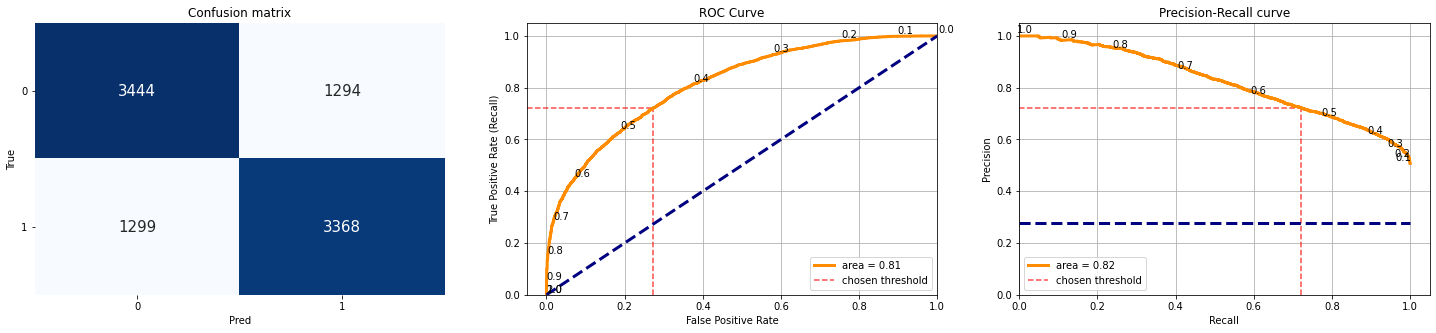

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb=MultinomialNB(alpha=0.1)
nb.fit(X_train,y_train)
predict_MNB = nb.predict(X_test)
predicted_prob = nb.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_MNB, predicted_prob, figsize=(25,5))

for Intuitve / sensing

In [ ]:
#getting splited data
X_train, X_test, y_train, y_test = split_data(x,df_data['NS'])

Accuracy (overall correct predictions): 0.7
Auc: 0.83
Recall (all 1s predicted right): 0.99
Precision (confidence when predicting a 1): 0.7
F1 score: 0.82
Detail:
              precision    recall  f1-score   support

           0       0.76      0.10      0.17       680
           1       0.70      0.99      0.82      1465

    accuracy                           0.70      2145
   macro avg       0.73      0.54      0.49      2145
weighted avg       0.72      0.70      0.61      2145



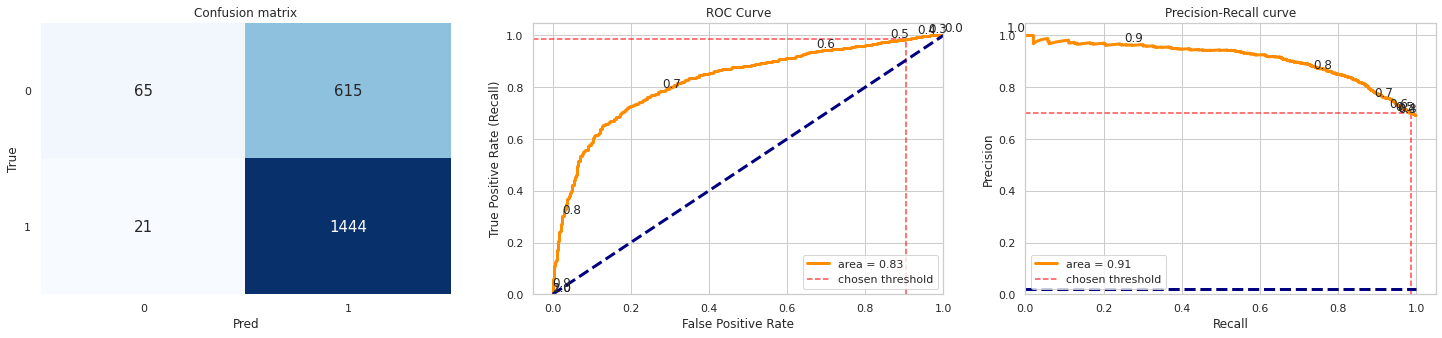

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb_ns=MultinomialNB(alpha=0.1)
nb_ns.fit(X_train,y_train)
predict_MNB = nb_ns.predict(X_test)
predicted_prob = nb_ns.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_MNB, predicted_prob, figsize=(25,5))

for feeling and thinking

In [ ]:
#getting splited data
X_train, X_test, y_train, y_test = split_data(x,df_data['FT'])

Accuracy (overall correct predictions): 0.73
Auc: 0.82
Recall (all 1s predicted right): 0.82
Precision (confidence when predicting a 1): 0.71
F1 score: 0.76
Detail:
              precision    recall  f1-score   support

           0       0.75      0.62      0.68      1007
           1       0.71      0.82      0.76      1138

    accuracy                           0.73      2145
   macro avg       0.73      0.72      0.72      2145
weighted avg       0.73      0.73      0.72      2145



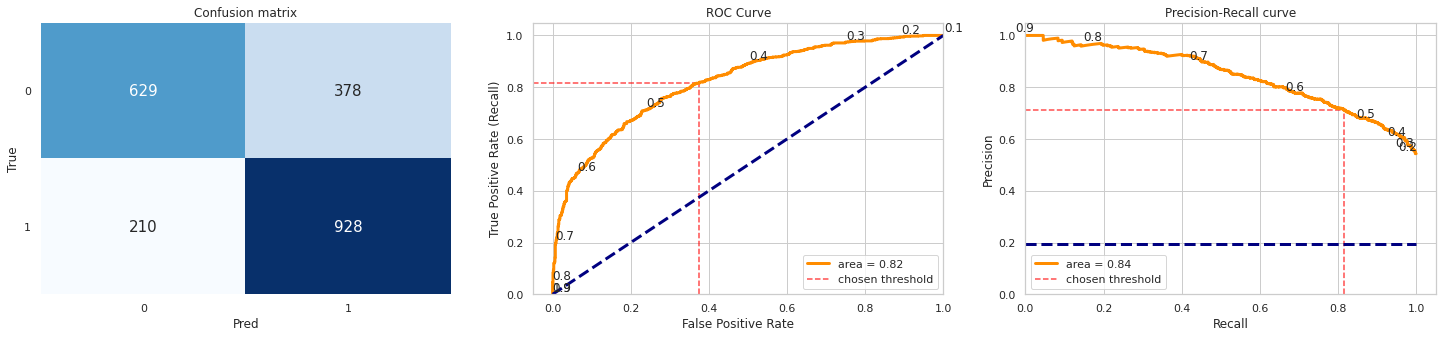

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb_ft=MultinomialNB(alpha=0.1)
nb_ft.fit(X_train,y_train)
predict_MNB = nb_ft.predict(X_test)
predicted_prob = nb_ft.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_MNB, predicted_prob, figsize=(25,5))

for perceiving and judgemental

In [ ]:
#getting splited data
X_train, X_test, y_train, y_test = split_data(x,df_data['PJ'])

Accuracy (overall correct predictions): 0.61
Auc: 0.68
Recall (all 1s predicted right): 0.86
Precision (confidence when predicting a 1): 0.6
F1 score: 0.71
Detail:
              precision    recall  f1-score   support

           0       0.64      0.31      0.42       965
           1       0.60      0.86      0.71      1180

    accuracy                           0.61      2145
   macro avg       0.62      0.58      0.56      2145
weighted avg       0.62      0.61      0.58      2145



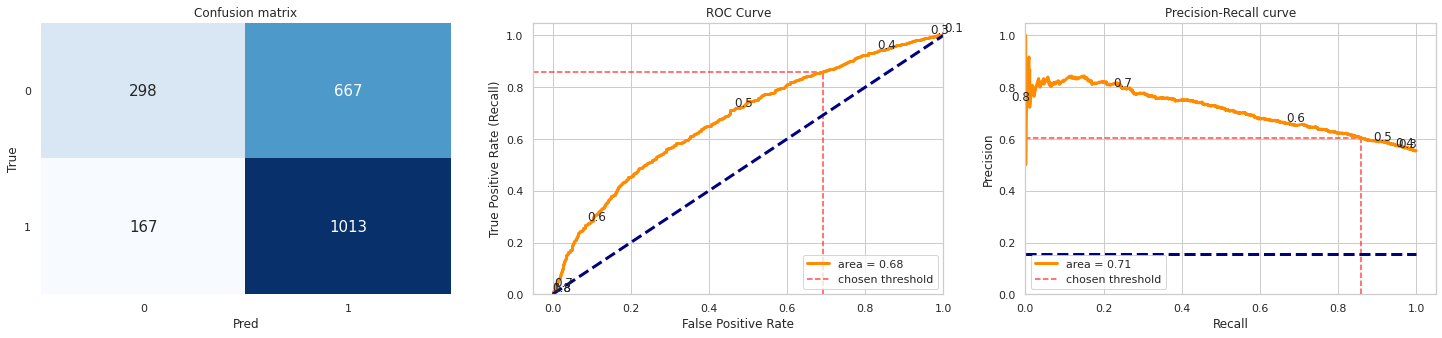

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb_pj=MultinomialNB(alpha=0.1)
nb_pj.fit(X_train,y_train)
predict_MNB = nb_pj.predict(X_test)
predicted_prob = nb_pj.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_MNB, predicted_prob, figsize=(25,5))

## **Random Forest**

for introvert / Extrovert

In [ ]:
X_train, X_test, y_train, y_test = split_data(x,df_data['IE'])

Accuracy (overall correct predictions): 0.76
Auc: 0.83
Recall (all 1s predicted right): 0.94
Precision (confidence when predicting a 1): 0.76
F1 score: 0.84
Detail:
              precision    recall  f1-score   support

           0       0.80      0.45      0.57       756
           1       0.76      0.94      0.84      1389

    accuracy                           0.76      2145
   macro avg       0.78      0.69      0.70      2145
weighted avg       0.77      0.76      0.74      2145



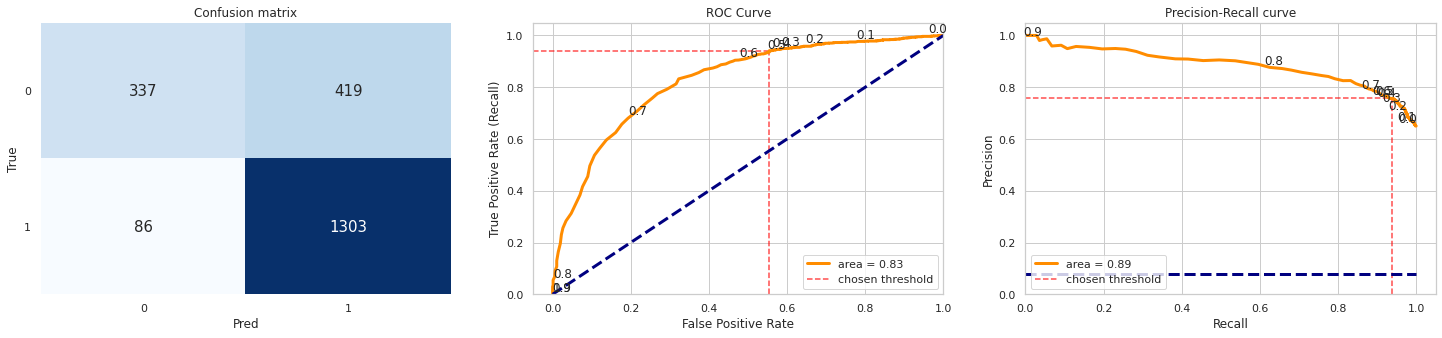

In [ ]:
# implement RandomForest Classifier
from sklearn.ensemble import RandomForestClassifier
randomclassifier=RandomForestClassifier(n_estimators=200,criterion='entropy')
randomclassifier.fit(X_train,y_train)
predict_rf = randomclassifier.predict(X_test)
predicted_prob_rf = randomclassifier.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_rf, predicted_prob_rf, figsize=(25,5))

Accuracy (overall correct predictions): 0.74
Auc: 0.83
Recall (all 1s predicted right): 0.73
Precision (confidence when predicting a 1): 0.75
F1 score: 0.74
Detail:
              precision    recall  f1-score   support

           0       0.74      0.76      0.75      4738
           1       0.75      0.73      0.74      4667

    accuracy                           0.74      9405
   macro avg       0.74      0.74      0.74      9405
weighted avg       0.74      0.74      0.74      9405



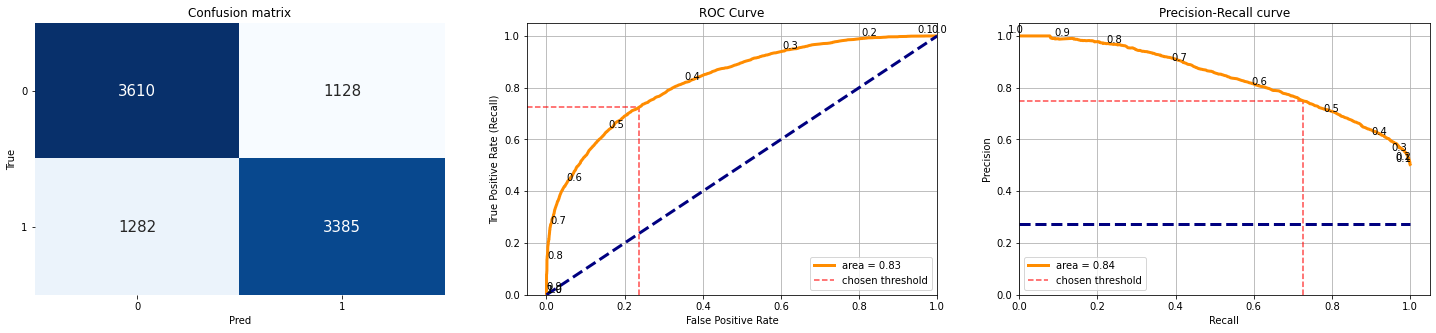

In [ ]:
# implement RandomForest Classifier
from sklearn.ensemble import RandomForestClassifier
randomclassifier=RandomForestClassifier(n_estimators=800,criterion='entropy')
randomclassifier.fit(X_train,y_train)
predict_rf = randomclassifier.predict(X_test)
predicted_prob_rf = randomclassifier.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_rf, predicted_prob_rf, figsize=(25,5))

for intuitive and sensing

In [ ]:
#getting splited data
X_train, X_test, y_train, y_test = split_data(x,df_data['NS'])

Accuracy (overall correct predictions): 0.87
Auc: 0.88
Recall (all 1s predicted right): 0.99
Precision (confidence when predicting a 1): 0.85
F1 score: 0.91
Detail:
              precision    recall  f1-score   support

           0       0.97      0.62      0.75       680
           1       0.85      0.99      0.91      1465

    accuracy                           0.87      2145
   macro avg       0.91      0.80      0.83      2145
weighted avg       0.88      0.87      0.86      2145



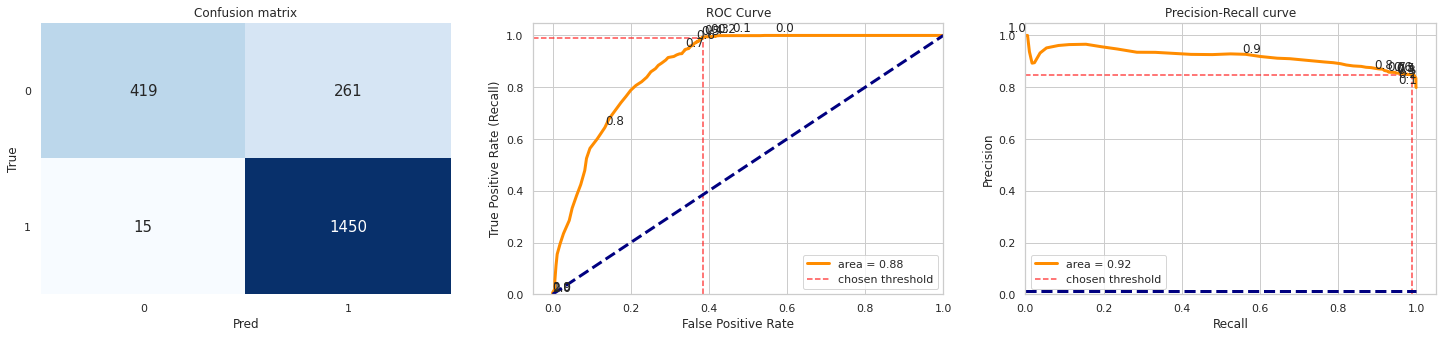

In [ ]:
# implement RandomForest Classifier
from sklearn.ensemble import RandomForestClassifier
randomclassifier_ns=RandomForestClassifier(n_estimators=200,criterion='entropy')
randomclassifier_ns.fit(X_train,y_train)
predict_rf = randomclassifier_ns.predict(X_test)
predicted_prob_rf = randomclassifier_ns.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_rf, predicted_prob_rf, figsize=(25,5))

for feeling and thinking

In [ ]:
#getting splited data
X_train, X_test, y_train, y_test = split_data(x,df_data['FT'])

Accuracy (overall correct predictions): 0.73
Auc: 0.8
Recall (all 1s predicted right): 0.81
Precision (confidence when predicting a 1): 0.72
F1 score: 0.76
Detail:
              precision    recall  f1-score   support

           0       0.75      0.64      0.69      1007
           1       0.72      0.81      0.76      1138

    accuracy                           0.73      2145
   macro avg       0.73      0.73      0.73      2145
weighted avg       0.73      0.73      0.73      2145



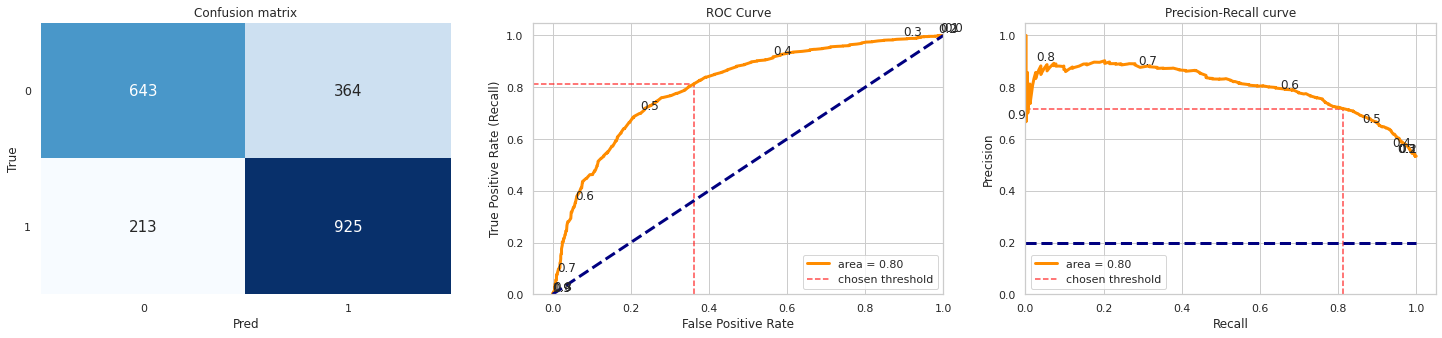

In [ ]:
# implement RandomForest Classifier
from sklearn.ensemble import RandomForestClassifier
randomclassifier_ft=RandomForestClassifier(n_estimators=200,criterion='entropy')
randomclassifier_ft.fit(X_train,y_train)
predict_rf = randomclassifier_ft.predict(X_test)
predicted_prob_rf = randomclassifier_ft.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_rf, predicted_prob_rf, figsize=(25,5))

for perceiving and judgemental

In [ ]:
#getting splited data
X_train, X_test, y_train, y_test = split_data(x,df_data['PJ'])

Accuracy (overall correct predictions): 0.64
Auc: 0.72
Recall (all 1s predicted right): 0.85
Precision (confidence when predicting a 1): 0.63
F1 score: 0.72
Detail:
              precision    recall  f1-score   support

           0       0.67      0.38      0.48       965
           1       0.63      0.85      0.72      1180

    accuracy                           0.64      2145
   macro avg       0.65      0.61      0.60      2145
weighted avg       0.64      0.64      0.61      2145



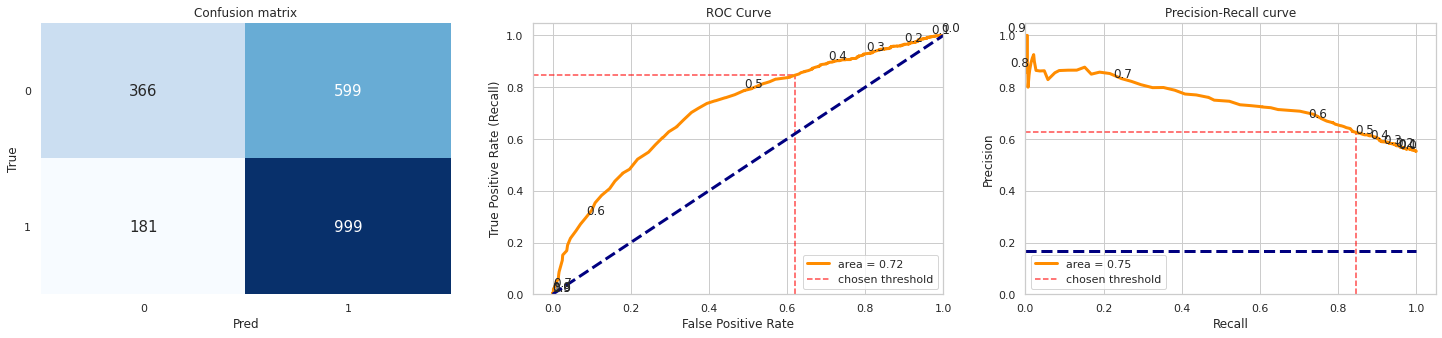

In [ ]:
# implement RandomForest Classifier
from sklearn.ensemble import RandomForestClassifier
randomclassifier_pj=RandomForestClassifier(n_estimators=200,criterion='entropy')
randomclassifier_pj.fit(X_train,y_train)
predict_rf = randomclassifier_pj.predict(X_test)
predicted_prob_rf = randomclassifier_pj.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_rf, predicted_prob_rf, figsize=(25,5))

## **SVM**

for introvert / extrovert

In [ ]:
X_train, X_test, y_train, y_test = split_data(x,df_data['IE'])

Accuracy (overall correct predictions): 0.85
Auc: 0.91
Recall (all 1s predicted right): 0.91
Precision (confidence when predicting a 1): 0.87
F1 score: 0.89
Detail:
              precision    recall  f1-score   support

           0       0.81      0.74      0.78       772
           1       0.87      0.91      0.89      1412

    accuracy                           0.85      2184
   macro avg       0.84      0.82      0.83      2184
weighted avg       0.85      0.85      0.85      2184



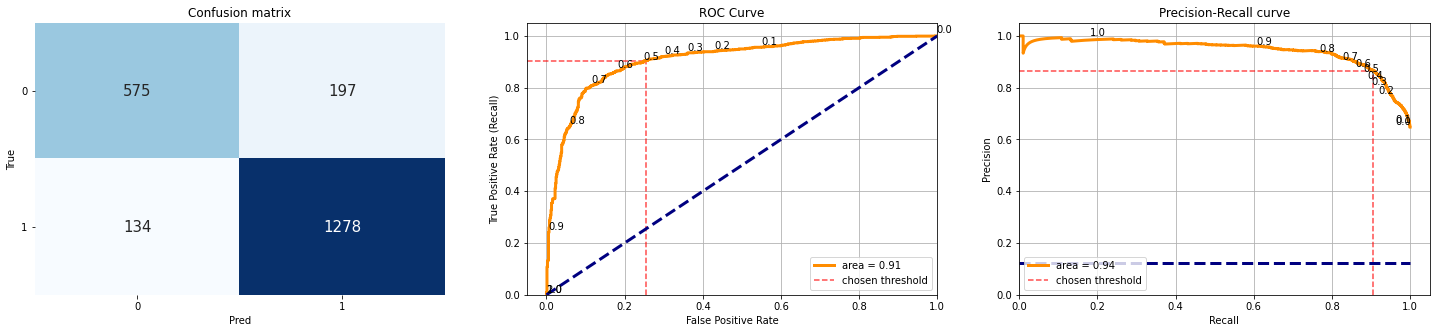

['/content/drive/My Drive/LinkedIn/Models/mbti_IE.joblib.dat']

In [ ]:
# implement SVC Classifier
from sklearn.svm import SVC
svc=SVC(probability=True)
svc.fit(X_train,y_train)
predict_svc = svc.predict(X_test)
predicted_prob_svc = svc.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_svc, predicted_prob_svc, figsize=(25,5))
model_name = '/content/drive/My Drive/LinkedIn/Models/mbti_IE.joblib.dat'
dump(svc, model_name)

Accuracy (overall correct predictions): 0.76
Auc: 0.85
Recall (all 1s predicted right): 0.75
Precision (confidence when predicting a 1): 0.77
F1 score: 0.76
Detail:
              precision    recall  f1-score   support

           0       0.76      0.77      0.77      4738
           1       0.77      0.75      0.76      4667

    accuracy                           0.76      9405
   macro avg       0.76      0.76      0.76      9405
weighted avg       0.76      0.76      0.76      9405



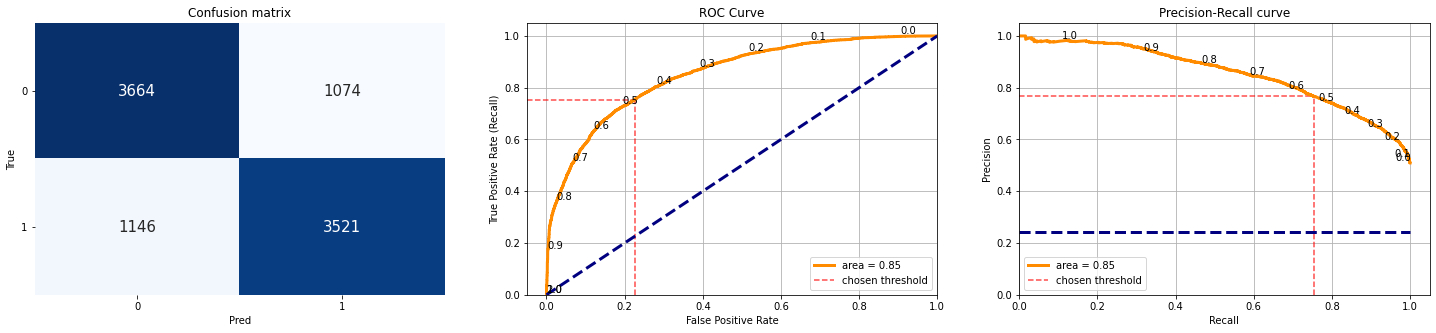

In [ ]:
# implement SVC Classifier
from sklearn.svm import SVC
svc=SVC(probability=True)
svc.fit(X_train,y_train)
predict_svc = svc.predict(X_test)
predicted_prob_svc = svc.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_svc, predicted_prob_svc, figsize=(25,5))

Accuracy (overall correct predictions): 0.8
Auc: 0.87
Recall (all 1s predicted right): 0.93
Precision (confidence when predicting a 1): 0.8
F1 score: 0.86
Detail:
              precision    recall  f1-score   support

           0       0.82      0.57      0.67       756
           1       0.80      0.93      0.86      1389

    accuracy                           0.80      2145
   macro avg       0.81      0.75      0.77      2145
weighted avg       0.81      0.80      0.79      2145



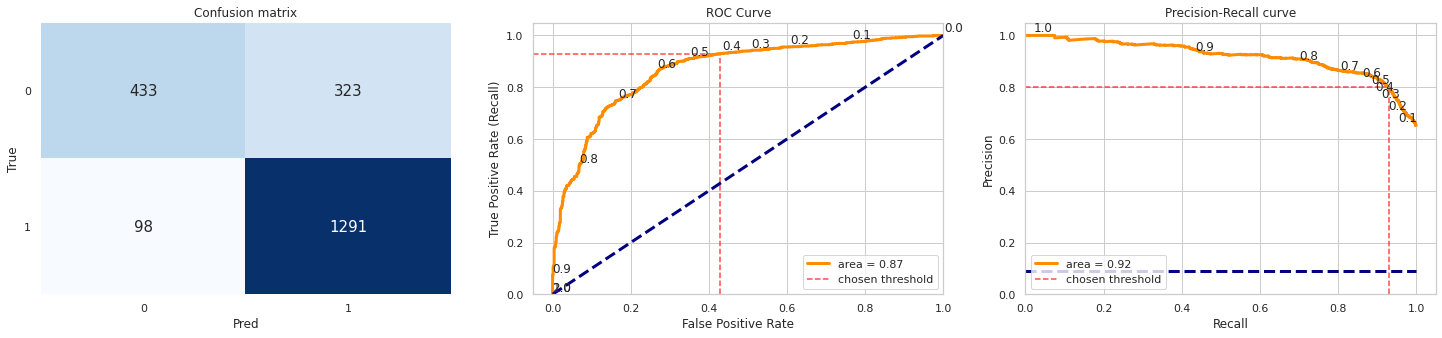

In [ ]:
# implement SVC Classifier
from sklearn.svm import SVC
svc=SVC(probability=True)
svc.fit(X_train,y_train)
predict_svc = svc.predict(X_test)
predicted_prob_svc = svc.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_svc, predicted_prob_svc, figsize=(25,5))

Accuracy (overall correct predictions): 0.95
Auc: 0.99
Recall (all 1s predicted right): 0.99
Precision (confidence when predicting a 1): 0.94
F1 score: 0.96
Detail:
              precision    recall  f1-score   support

           0       0.97      0.88      0.92      2931
           1       0.94      0.99      0.96      5647

    accuracy                           0.95      8578
   macro avg       0.95      0.93      0.94      8578
weighted avg       0.95      0.95      0.95      8578



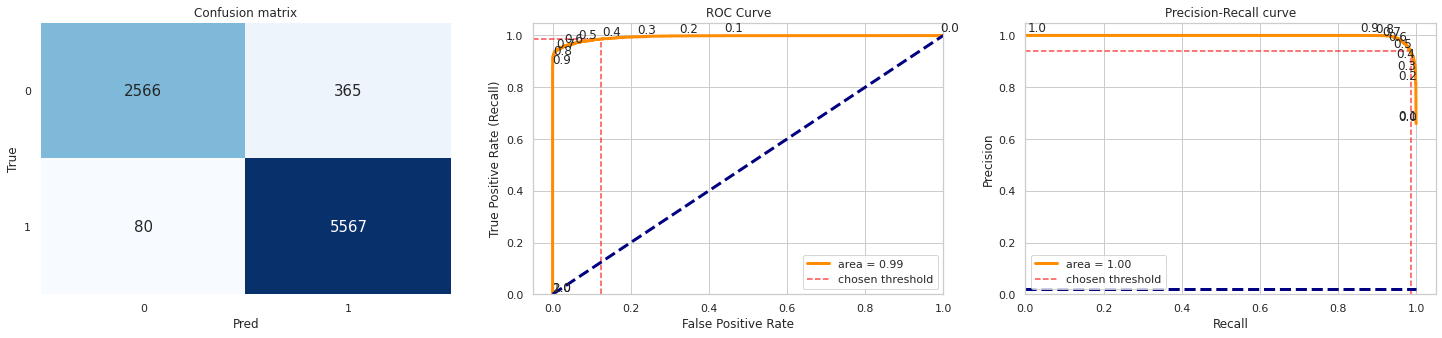

In [ ]:
#testing on training data
predict_svc = svc.predict(X_train)
predicted_prob_svc = svc.predict_proba(X_train)[:,1]
evaluate_model(y_train,predict_svc, predicted_prob_svc, figsize=(25,5))

for intuitive and sensing

In [ ]:
#getting splited data
X_train, X_test, y_train, y_test = split_data(x,df_data['NS'])

Accuracy (overall correct predictions): 0.9
Auc: 0.95
Recall (all 1s predicted right): 0.98
Precision (confidence when predicting a 1): 0.88
F1 score: 0.93
Detail:
              precision    recall  f1-score   support

           0       0.94      0.74      0.83       720
           1       0.88      0.98      0.93      1464

    accuracy                           0.90      2184
   macro avg       0.91      0.86      0.88      2184
weighted avg       0.90      0.90      0.89      2184



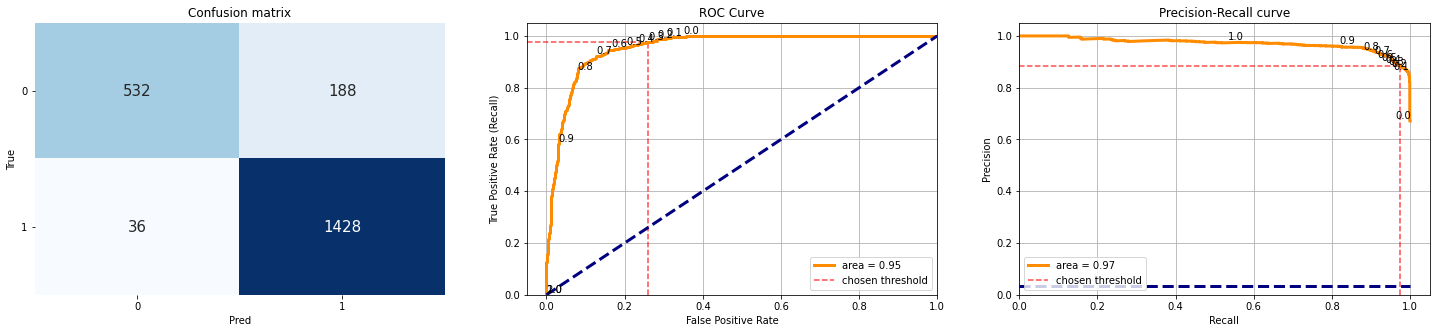

['/content/drive/My Drive/LinkedIn/Models/mbti_NS.joblib.dat']

In [ ]:
# implement SVC Classifier
from sklearn.svm import SVC
svc_ns=SVC(probability=True)
svc_ns.fit(X_train,y_train)
predict_svc = svc_ns.predict(X_test)
predicted_prob_svc = svc_ns.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_svc, predicted_prob_svc, figsize=(25,5))
model_name = '/content/drive/My Drive/LinkedIn/Models/mbti_NS.joblib.dat'
dump(svc_ns, model_name)

Accuracy (overall correct predictions): 0.91
Auc: 0.95
Recall (all 1s predicted right): 0.98
Precision (confidence when predicting a 1): 0.9
F1 score: 0.94
Detail:
              precision    recall  f1-score   support

           0       0.93      0.75      0.83       656
           1       0.90      0.98      0.94      1493

    accuracy                           0.91      2149
   macro avg       0.92      0.86      0.88      2149
weighted avg       0.91      0.91      0.90      2149



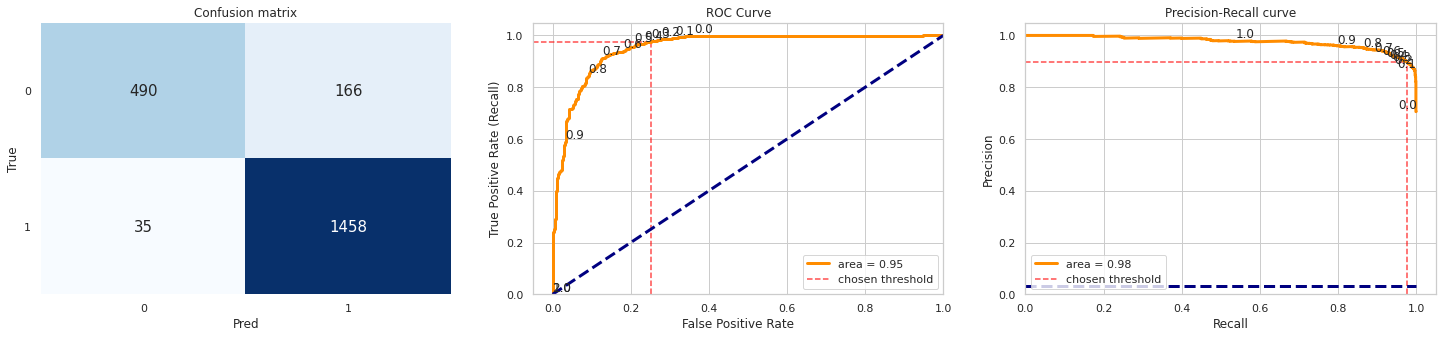

In [ ]:
# implement SVC Classifier
from sklearn.svm import SVC
svc_ns=SVC(probability=True)
svc_ns.fit(X_train,y_train)
predict_svc = svc_ns.predict(X_test)
predicted_prob_svc = svc_ns.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_svc, predicted_prob_svc, figsize=(25,5))

For feeling and thinking

In [ ]:
#getting splited data
X_train, X_test, y_train, y_test = split_data(x,df_data['FT'])

Accuracy (overall correct predictions): 0.78
Auc: 0.85
Recall (all 1s predicted right): 0.89
Precision (confidence when predicting a 1): 0.75
F1 score: 0.81
Detail:
              precision    recall  f1-score   support

           0       0.84      0.66      0.74      1028
           1       0.75      0.89      0.81      1156

    accuracy                           0.78      2184
   macro avg       0.79      0.78      0.78      2184
weighted avg       0.79      0.78      0.78      2184



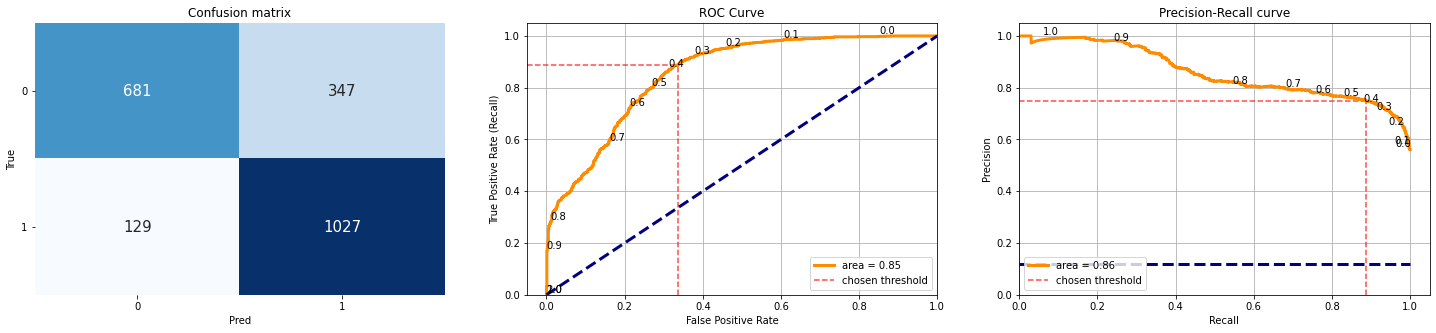

['/content/drive/My Drive/LinkedIn/Models/mbti_FT.joblib.dat']

In [ ]:
# implement SVC Classifier
from sklearn.svm import SVC
svc_ft=SVC(probability=True)
svc_ft.fit(X_train,y_train)
predict_svc = svc_ft.predict(X_test)
predicted_prob_svc = svc_ft.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_svc, predicted_prob_svc, figsize=(25,5))
model_name = '/content/drive/My Drive/LinkedIn/Models/mbti_FT.joblib.dat'
dump(svc_ft, model_name)

Accuracy (overall correct predictions): 0.8
Auc: 0.87
Recall (all 1s predicted right): 0.89
Precision (confidence when predicting a 1): 0.77
F1 score: 0.83
Detail:
              precision    recall  f1-score   support

           0       0.85      0.70      0.77      1002
           1       0.77      0.89      0.83      1147

    accuracy                           0.80      2149
   macro avg       0.81      0.79      0.80      2149
weighted avg       0.81      0.80      0.80      2149



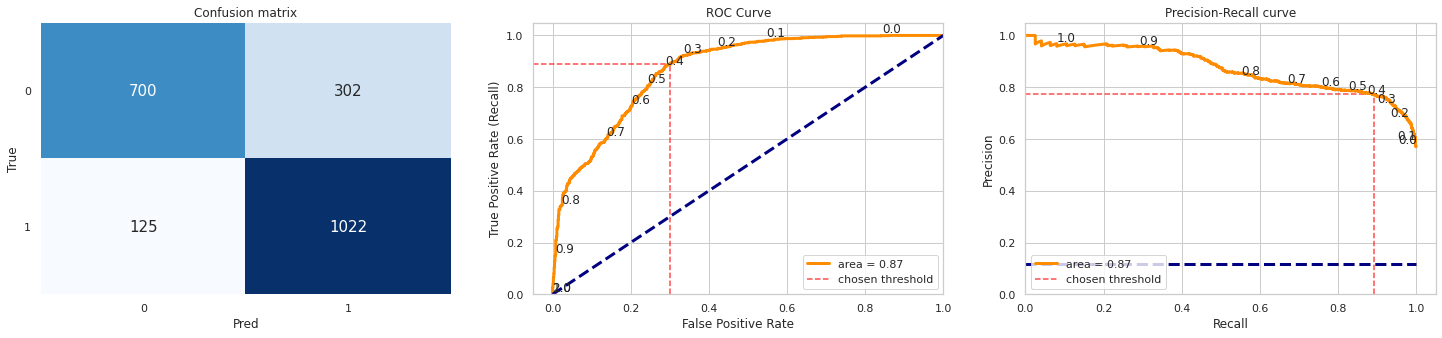

In [ ]:
# implement SVC Classifier
from sklearn.svm import SVC
svc_ft=SVC(probability=True)
svc_ft.fit(X_train,y_train)
predict_svc = svc_ft.predict(X_test)
predicted_prob_svc = svc_ft.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_svc, predicted_prob_svc, figsize=(25,5))

**For perveiving and judging**

In [ ]:
#getting splited data
X_train, X_test, y_train, y_test = split_data(x,df_data['PJ'])

Accuracy (overall correct predictions): 0.76
Auc: 0.81
Recall (all 1s predicted right): 0.76
Precision (confidence when predicting a 1): 0.8
F1 score: 0.78
Detail:
              precision    recall  f1-score   support

           0       0.71      0.76      0.74       963
           1       0.80      0.76      0.78      1221

    accuracy                           0.76      2184
   macro avg       0.76      0.76      0.76      2184
weighted avg       0.76      0.76      0.76      2184



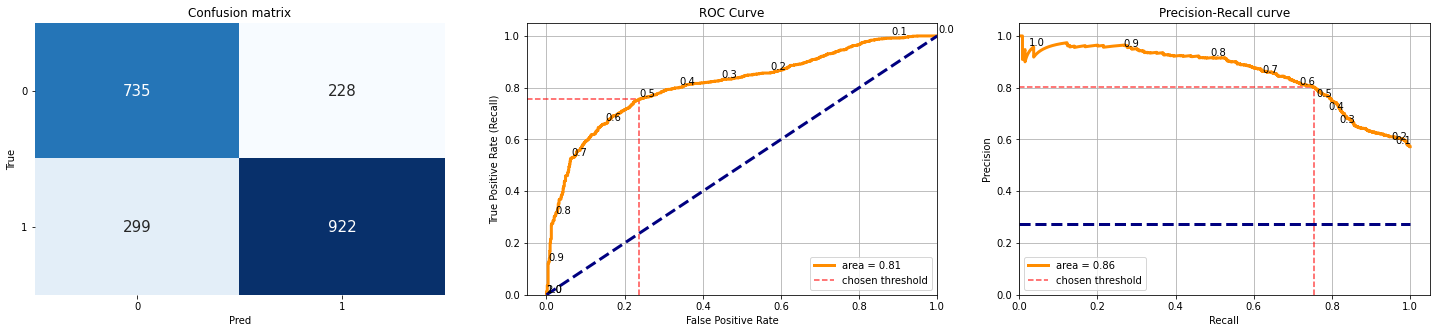

['/content/drive/My Drive/LinkedIn/Models/mbti_PJ.joblib.dat']

In [ ]:
# implement SVC Classifier
from sklearn.svm import SVC
svc_pj=SVC(probability=True)
svc_pj.fit(X_train,y_train)
predict_svc = svc_pj.predict(X_test)
predicted_prob_svc = svc_pj.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_svc, predicted_prob_svc, figsize=(25,5))
model_name = '/content/drive/My Drive/LinkedIn/Models/mbti_PJ.joblib.dat'
dump(svc_pj, model_name)

Accuracy (overall correct predictions): 0.76
Auc: 0.83
Recall (all 1s predicted right): 0.77
Precision (confidence when predicting a 1): 0.79
F1 score: 0.78
Detail:
              precision    recall  f1-score   support

           0       0.72      0.74      0.73       948
           1       0.79      0.77      0.78      1201

    accuracy                           0.76      2149
   macro avg       0.75      0.76      0.75      2149
weighted avg       0.76      0.76      0.76      2149



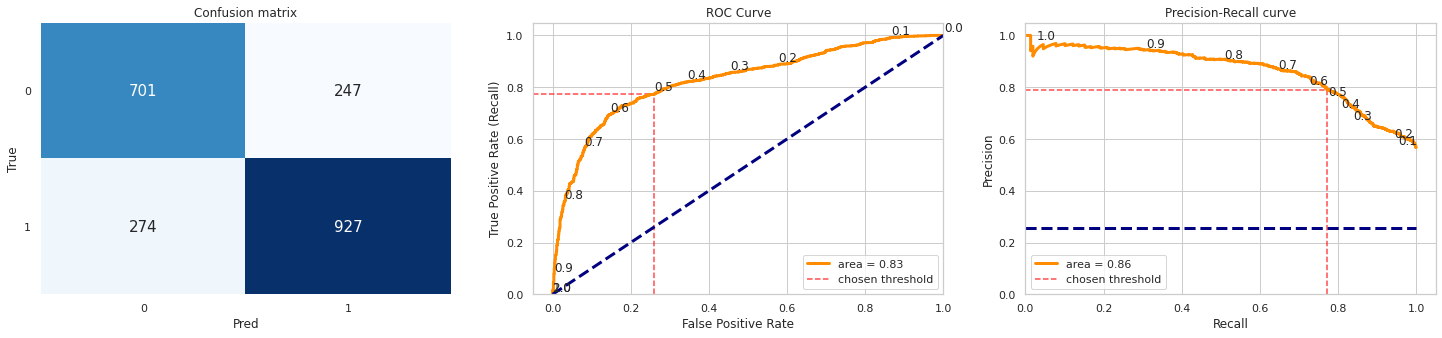

In [ ]:
# implement SVC Classifier
from sklearn.svm import SVC
svc_pj=SVC(probability=True)
svc_pj.fit(X_train,y_train)
predict_svc = svc_pj.predict(X_test)
predicted_prob_svc = svc_pj.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_svc, predicted_prob_svc, figsize=(25,5))

In [ ]:
def predict2(posts):

  #for storing the output
  result = []
  text_do = []
  text_donts = []
  text_ib = []

  #creating the data frame
  df_text = pd.DataFrame(data={'Text': [posts]})

  #data cleaning
  Corpus = text_process(df_text,columns='Text')

  #transforming the feature
  load_bow = load("/content/drive/My Drive/LinkedIn/Models/bow.joblib.dat")
  x = load_bow.transform(Corpus).toarray()

  #predicting the value Introvert / extrovert
  predictions = svc.predict(x)
  prob_IE = svc.predict_proba(x)
  result.append(predictions[0])

  #predicting the value Introvert / extrovert
  predictions_ns = svc_ns.predict(x)
  prob_NS = svc_ns.predict_proba(x)
  result.append(predictions_ns[0])

  #predicting the value Introvert / extrovert
  predictions_ft = svc_ft.predict(x)
  prob_FT = svc_ft.predict_proba(x)
  result.append(predictions_ft[0])

  #predicting the value Introvert / extrovert
  predictions_pj = svc_pj.predict(x)
  prob_PJ = svc_pj.predict_proba(x)
  result.append(predictions_pj[0])
  
  s,t = translate_data_back(result)
   
  if s=='INTP':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ENTP':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='INFJ':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='INTJ':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ENTJ':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ENFJ':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='INFP':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ENFP':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ISFP':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ISTP':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ISFJ':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ISTJ':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ESTP':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ESFP':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ESTJ':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  else:
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')

  draw_graph(prob_IE=prob_IE,prob_NS=prob_NS,prob_FT=prob_FT,prob_PJ=prob_PJ,s=s)
  #print(translate_data_back(result))
  print(s,t)

  return text_do,text_donts,text_ib,prob_IE,prob_NS,prob_FT,prob_PJ

ESFJ Person possesses following personality :-  Extroversion, Sensing, Feeling, Judging


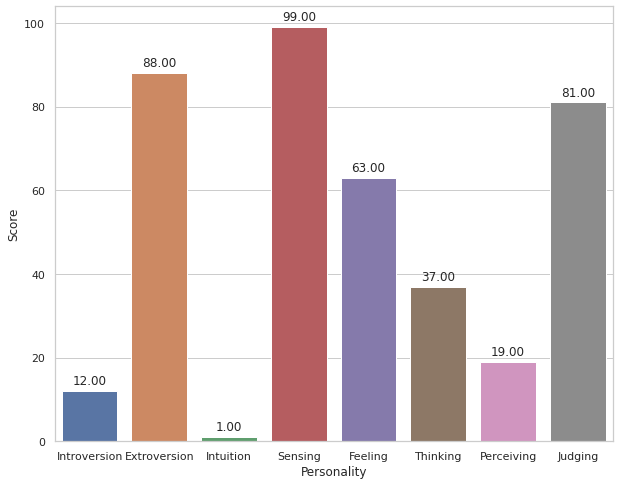

In [ ]:

my_posts  = """SALES MANAGEMENT / BUSINESS DEVELOPMENT / PROJECT MANAGEMENTDOMESTIC & INTERNATIONAL KEY ACCOUNT MANAGEMENTBusiness and Sales Executive with 20 years of accomplished career track, reflecting extensive experience and dynamic record-breaking performance in the Medical Industry markets. Exceptional communicator, strong team player, flexible self-starter with consultative sales style, strong negotiations skills, exceptional problem solving abilities, and accurate customer assessment aptitude. Manage and lead teams to success, drive new business through key accounts management, establish partnerships, manage solid distributor relationship for increased profitability and sales volumes. Very well organized, accurate and on-time administrative work, with a track record that demonstrates self-motivation, creativity, sales team leadership, initiative to achieve corporate, team and personal goals. Experience in the following markets: Medical Devices, Medical Disposables, Capital Equipment, Pharmaceuticals."""

a,b,c,d,e,f,g = predict2(my_posts)

ESFJ Person possesses following personality :-  Extroversion, Sensing, Feeling, Judging


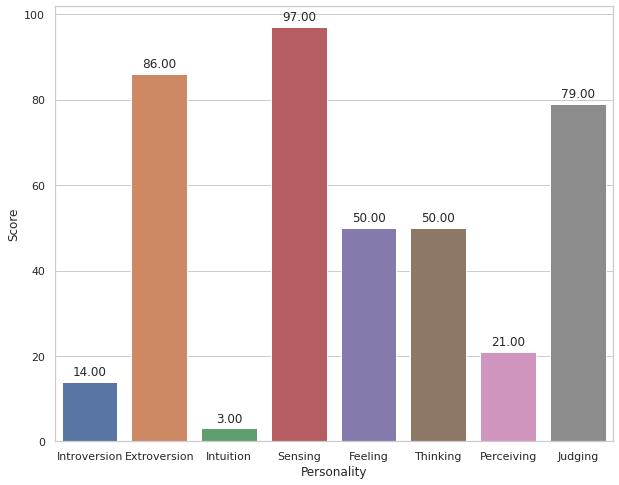

In [ ]:
my_posts  = """â€¢Having 12 Yrs of Experience in Marketing & International Business Development in Pharmaceutical sector.â€¢Experienced in managing operations in large business area, formulating and implementing strategies, developing new markets for business excellence.â€¢Adept at developing the distribution network infrastructure and channel management.â€¢Proven track record acquiring product registrations for several products in ASEAN Region.â€¢An effective communicator with abilities in implementing various sales promotional activities and escalating business turnovers during carrier span.â€¢Excellent logical, Analytical skills and an articulate with very good communication skills.â€¢In the total experience profile, managed and achieved targets in the segments of Cardiovascular, Respiratory care, Antibiotics, Multivitamins,Neutracuticals and wide range OTC products.â€¢Traveled extensively in the above mentioned countries to explore the markets and taken in-depth market survey to identify the distributor with a good margin which is profitable for the company.â€¢Wide experience across emerging markets of Asia, Latam countries . From business start ups to sustainable business with adaptability to different cultures and markets, successfully led change management.â€¢Experience in business feasibility, business planning, entry strategy, right product selection and portfolio development.â€¢Set up overseas office with minimum guidance, operations management, problem solving, crisis management.â€¢5 years overseas stay and travel to different countries gave a very good exposure and confidence to do business and deal people overseas.â€¢Product identification,ideation, launch plan, successful launches and making Mega Brands, Portfolio Management, KoL identification, CRM, Key Account Management.â€¢Exposure to many segments of pharmaceutical business, Passion for International Marketing, Business Development.Achieved targets with innovative idea"""

a,b,c,d,e,f,g = predict2(my_posts)

ESFJ Person possesses following personality :-  Extroversion, Sensing, Feeling, Judging


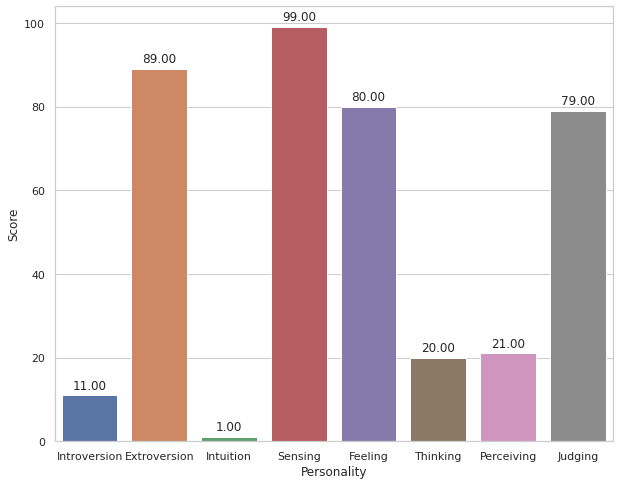

In [ ]:
my_posts  = """Operations Management Specialist and Consultant, 22 + years of experience in leading Wall Street firms supporting small, medium and large trading desks in front, middle and back office environments. Wide range of experience, managing MBS allocations, trade support, settlements, client relationship management and software support across a broad spectrum of Fixed Income productsAvailable for Consulting, Permanent or Consult to Perm opportunities"""

a,b,c,d,e,f,g = predict2(my_posts)

ESFJ Person possesses following personality :-  Extroversion, Sensing, Feeling, Judging


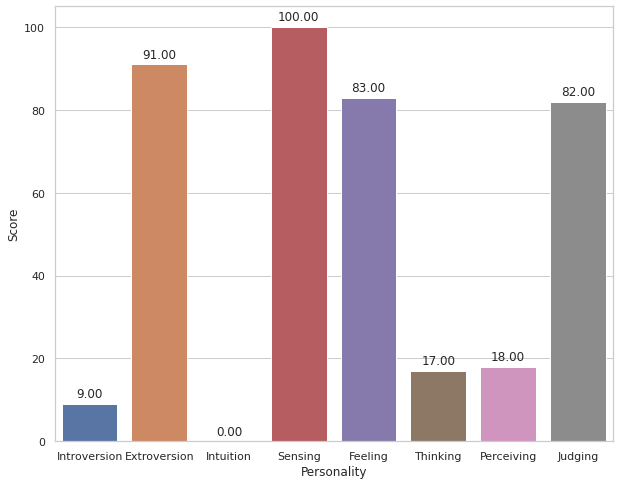

In [ ]:
my_posts  = """It requires belief that is outside of a logical framework and isnâ€™t worth positing because itâ€™s just you affirming your own beliefs which means nothing to anyone."""
a,b,c,d,e,f,g = predict2(my_posts)

## **PassiveAggressiveClassifier**

In [ ]:
X_train, X_test, y_train, y_test = split_data(x,df_data['IE'])

Accuracy (overall correct predictions): 0.74
Recall (all 1s predicted right): 0.78
Precision (confidence when predicting a 1): 0.81
F1 score: 0.8
Detail:
              precision    recall  f1-score   support

           0       0.62      0.65      0.64       756
           1       0.81      0.78      0.80      1393

    accuracy                           0.74      2149
   macro avg       0.71      0.72      0.72      2149
weighted avg       0.74      0.74      0.74      2149



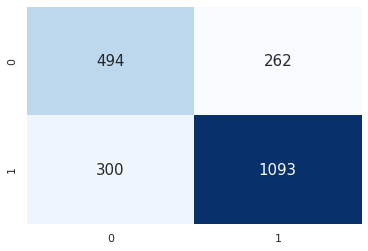

In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier

pac = PassiveAggressiveClassifier()
pac.fit(X_train,y_train)
predict_pac = pac.predict(X_test)

## Accuray e AUC
accuracy = metrics.accuracy_score(y_test, predict_pac)
print("Accuracy (overall correct predictions):",  round(accuracy,2))

recall = metrics.recall_score(y_test, predict_pac)  #= true 1s / all 1s in test (got and missed)
precision = metrics.precision_score(y_test, predict_pac)  #= true 1s / all 1s predicted (true 1s + false 1s)
f1 = metrics.f1_score(y_test, predict_pac)  #=2 * (precision * recall) / (precision + recall)
print("Recall (all 1s predicted right):", round(recall,2))  #true positive rate, how many 1s I got
print("Precision (confidence when predicting a 1):", round(precision,2))  #how many 1s were really 1s
print("F1 score:", round(f1,2))
print("Detail:")
classes = np.unique(y_test)
print(metrics.classification_report(y_test, predict_pac, target_names=[str(i) for i in classes]))

## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predict_pac, labels=classes)
sns.heatmap(cm, annot=True, annot_kws={"size":15}, fmt='d',cmap=plt.cm.Blues, cbar=False)

In [ ]:
#getting splited data
X_train, X_test, y_train, y_test = split_data(x,df_data['NS'])

Accuracy (overall correct predictions): 0.87
Recall (all 1s predicted right): 0.9
Precision (confidence when predicting a 1): 0.91
F1 score: 0.91
Detail:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       656
           1       0.91      0.90      0.91      1493

    accuracy                           0.87      2149
   macro avg       0.85      0.85      0.85      2149
weighted avg       0.87      0.87      0.87      2149



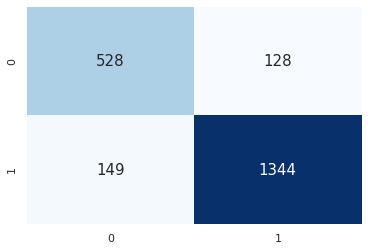

In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier

pac_ns = PassiveAggressiveClassifier()
pac_ns.fit(X_train,y_train)
predict_pac = pac_ns.predict(X_test)

## Accuray e AUC
accuracy = metrics.accuracy_score(y_test, predict_pac)
print("Accuracy (overall correct predictions):",  round(accuracy,2))

recall = metrics.recall_score(y_test, predict_pac)  #= true 1s / all 1s in test (got and missed)
precision = metrics.precision_score(y_test, predict_pac)  #= true 1s / all 1s predicted (true 1s + false 1s)
f1 = metrics.f1_score(y_test, predict_pac)  #=2 * (precision * recall) / (precision + recall)
print("Recall (all 1s predicted right):", round(recall,2))  #true positive rate, how many 1s I got
print("Precision (confidence when predicting a 1):", round(precision,2))  #how many 1s were really 1s
print("F1 score:", round(f1,2))
print("Detail:")
classes = np.unique(y_test)
print(metrics.classification_report(y_test, predict_pac, target_names=[str(i) for i in classes]))

## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predict_pac, labels=classes)
sns.heatmap(cm, annot=True, annot_kws={"size":15}, fmt='d',cmap=plt.cm.Blues, cbar=False)

In [ ]:
#getting splited data
X_train, X_test, y_train, y_test = split_data(x,df_data['FT'])

Accuracy (overall correct predictions): 0.69
Recall (all 1s predicted right): 0.7
Precision (confidence when predicting a 1): 0.71
F1 score: 0.71
Detail:
              precision    recall  f1-score   support

           0       0.66      0.67      0.67      1002
           1       0.71      0.70      0.71      1147

    accuracy                           0.69      2149
   macro avg       0.69      0.69      0.69      2149
weighted avg       0.69      0.69      0.69      2149



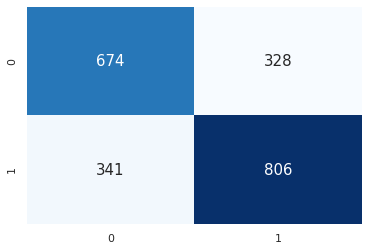

In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier

pac_ft = PassiveAggressiveClassifier()
pac_ft.fit(X_train,y_train)
predict_pac = pac_ft.predict(X_test)

## Accuray e AUC
accuracy = metrics.accuracy_score(y_test, predict_pac)
print("Accuracy (overall correct predictions):",  round(accuracy,2))

recall = metrics.recall_score(y_test, predict_pac)  #= true 1s / all 1s in test (got and missed)
precision = metrics.precision_score(y_test, predict_pac)  #= true 1s / all 1s predicted (true 1s + false 1s)
f1 = metrics.f1_score(y_test, predict_pac)  #=2 * (precision * recall) / (precision + recall)
print("Recall (all 1s predicted right):", round(recall,2))  #true positive rate, how many 1s I got
print("Precision (confidence when predicting a 1):", round(precision,2))  #how many 1s were really 1s
print("F1 score:", round(f1,2))
print("Detail:")
classes = np.unique(y_test)
print(metrics.classification_report(y_test, predict_pac, target_names=[str(i) for i in classes]))

## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predict_pac, labels=classes)
sns.heatmap(cm, annot=True, annot_kws={"size":15}, fmt='d',cmap=plt.cm.Blues, cbar=False)

In [ ]:
#getting splited data
X_train, X_test, y_train, y_test = split_data(x,df_data['PJ'])

Accuracy (overall correct predictions): 0.63
Recall (all 1s predicted right): 0.61
Precision (confidence when predicting a 1): 0.7
F1 score: 0.65
Detail:
              precision    recall  f1-score   support

           0       0.57      0.67      0.62       948
           1       0.70      0.61      0.65      1201

    accuracy                           0.63      2149
   macro avg       0.63      0.64      0.63      2149
weighted avg       0.64      0.63      0.63      2149



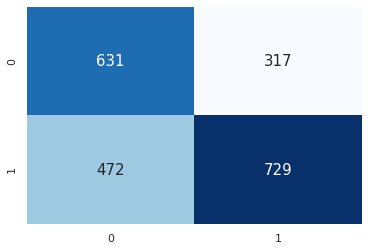

In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier

pac_pj = PassiveAggressiveClassifier()
pac_pj.fit(X_train,y_train)
predict_pac = pac_pj.predict(X_test)

## Accuray e AUC
accuracy = metrics.accuracy_score(y_test, predict_pac)
print("Accuracy (overall correct predictions):",  round(accuracy,2))

recall = metrics.recall_score(y_test, predict_pac)  #= true 1s / all 1s in test (got and missed)
precision = metrics.precision_score(y_test, predict_pac)  #= true 1s / all 1s predicted (true 1s + false 1s)
f1 = metrics.f1_score(y_test, predict_pac)  #=2 * (precision * recall) / (precision + recall)
print("Recall (all 1s predicted right):", round(recall,2))  #true positive rate, how many 1s I got
print("Precision (confidence when predicting a 1):", round(precision,2))  #how many 1s were really 1s
print("F1 score:", round(f1,2))
print("Detail:")
classes = np.unique(y_test)
print(metrics.classification_report(y_test, predict_pac, target_names=[str(i) for i in classes]))

## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predict_pac, labels=classes)
sns.heatmap(cm, annot=True, annot_kws={"size":15}, fmt='d',cmap=plt.cm.Blues, cbar=False)

## **Using TF-IDF Vectorizer**

**MultiNomial NB**

In [24]:
#transforming the feature

x_tfidf = transform_feature(Corpus,tech='tfidf')
#x_tfidf = transform_feature(filter_corpus,tech='tfidf')

In [35]:
X_train, X_test, y_train, y_test = split_data(x_tfidf,df_data['IE'])

Accuracy (overall correct predictions): 0.67
Auc: 0.78
Recall (all 1s predicted right): 0.97
Precision (confidence when predicting a 1): 0.67
F1 score: 0.79
Detail:
              precision    recall  f1-score   support

           0       0.66      0.12      0.21       756
           1       0.67      0.97      0.79      1389

    accuracy                           0.67      2145
   macro avg       0.67      0.54      0.50      2145
weighted avg       0.67      0.67      0.59      2145



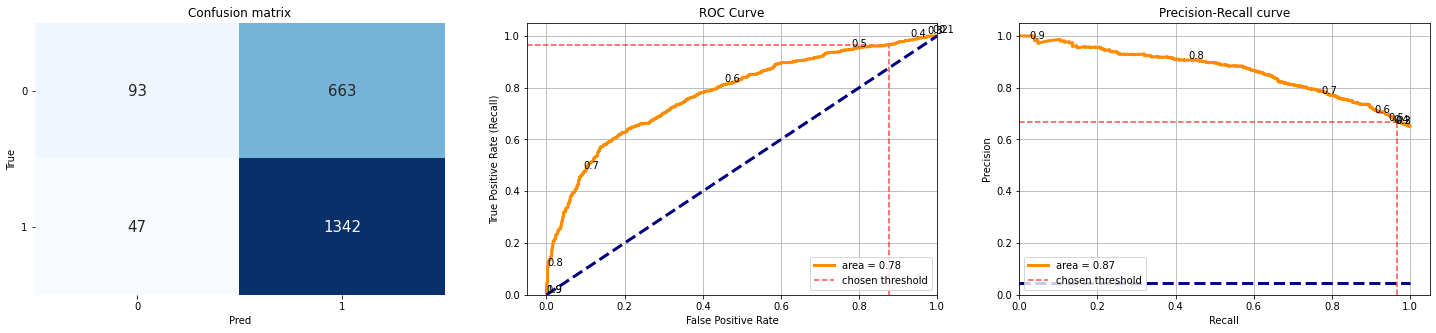

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb_tf=MultinomialNB(alpha=0.1)
nb_tf.fit(X_train,y_train)
predict_MNB = nb_tf.predict(X_test)
predicted_prob = nb_tf.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_MNB, predicted_prob, figsize=(25,5))

In [ ]:
X_train, X_test, y_train, y_test = split_data(x_tfidf,df_data['NS'])

Accuracy (overall correct predictions): 0.7
Auc: 0.83
Recall (all 1s predicted right): 0.99
Precision (confidence when predicting a 1): 0.7
F1 score: 0.82
Detail:
              precision    recall  f1-score   support

           0       0.76      0.10      0.17       680
           1       0.70      0.99      0.82      1465

    accuracy                           0.70      2145
   macro avg       0.73      0.54      0.49      2145
weighted avg       0.72      0.70      0.61      2145



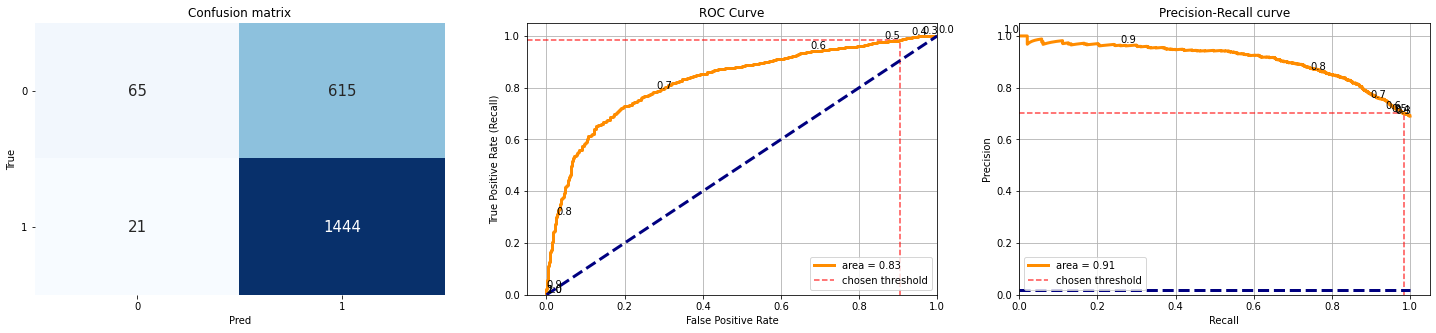

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb_tf_ns=MultinomialNB(alpha=0.1)
nb_tf_ns.fit(X_train,y_train)
predict_MNB = nb_tf_ns.predict(X_test)
predicted_prob = nb_tf_ns.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_MNB, predicted_prob, figsize=(25,5))

In [ ]:
#getting splited data
X_train, X_test, y_train, y_test = split_data(x_tfidf,df_data['FT'])

Accuracy (overall correct predictions): 0.73
Auc: 0.82
Recall (all 1s predicted right): 0.82
Precision (confidence when predicting a 1): 0.71
F1 score: 0.76
Detail:
              precision    recall  f1-score   support

           0       0.75      0.62      0.68      1007
           1       0.71      0.82      0.76      1138

    accuracy                           0.73      2145
   macro avg       0.73      0.72      0.72      2145
weighted avg       0.73      0.73      0.72      2145



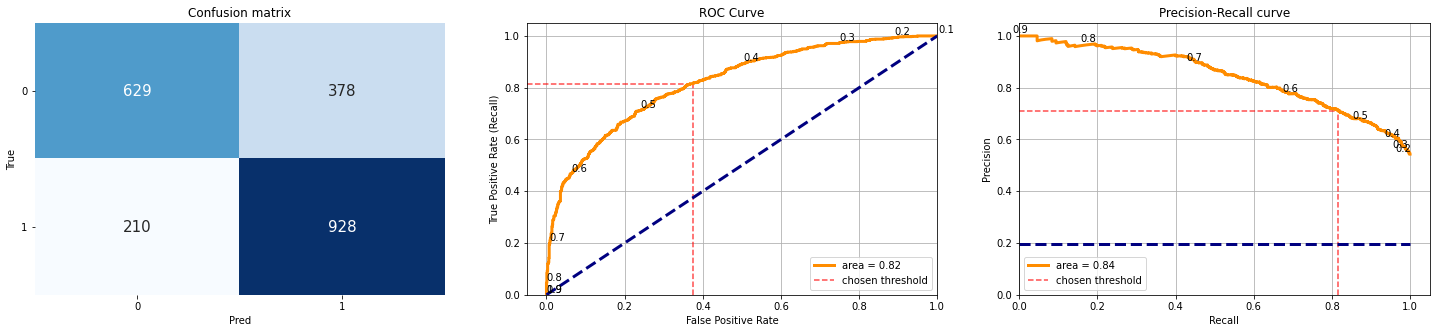

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb_tf_ft=MultinomialNB(alpha=0.1)
nb_tf_ft.fit(X_train,y_train)
predict_MNB = nb_tf_ft.predict(X_test)
predicted_prob = nb_tf_ft.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_MNB, predicted_prob, figsize=(25,5))

In [ ]:
#getting splited data
X_train, X_test, y_train, y_test = split_data(x_tfidf,df_data['PJ'])

Accuracy (overall correct predictions): 0.61
Auc: 0.68
Recall (all 1s predicted right): 0.86
Precision (confidence when predicting a 1): 0.6
F1 score: 0.71
Detail:
              precision    recall  f1-score   support

           0       0.64      0.31      0.42       965
           1       0.60      0.86      0.71      1180

    accuracy                           0.61      2145
   macro avg       0.62      0.58      0.56      2145
weighted avg       0.62      0.61      0.58      2145



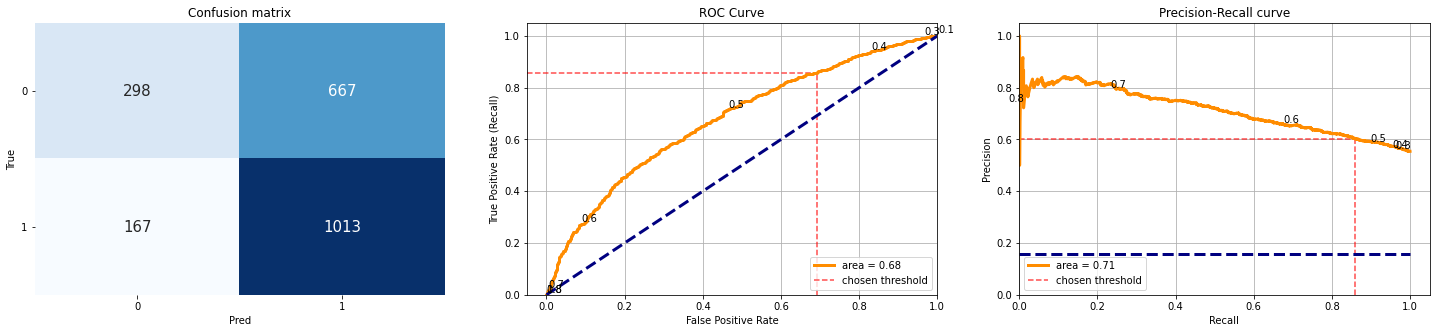

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb_tf_pj=MultinomialNB(alpha=0.1)
nb_tf_pj.fit(X_train,y_train)
predict_MNB = nb_tf_pj.predict(X_test)
predicted_prob = nb_tf_pj.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_MNB, predicted_prob, figsize=(25,5))

RandomForest

In [ ]:
X_train, X_test, y_train, y_test = split_data(x_tfidf,df_data['IE'])

Accuracy (overall correct predictions): 0.76
Auc: 0.82
Recall (all 1s predicted right): 0.94
Precision (confidence when predicting a 1): 0.76
F1 score: 0.84
Detail:
              precision    recall  f1-score   support

           0       0.79      0.45      0.57       756
           1       0.76      0.94      0.84      1389

    accuracy                           0.76      2145
   macro avg       0.77      0.69      0.70      2145
weighted avg       0.77      0.76      0.74      2145



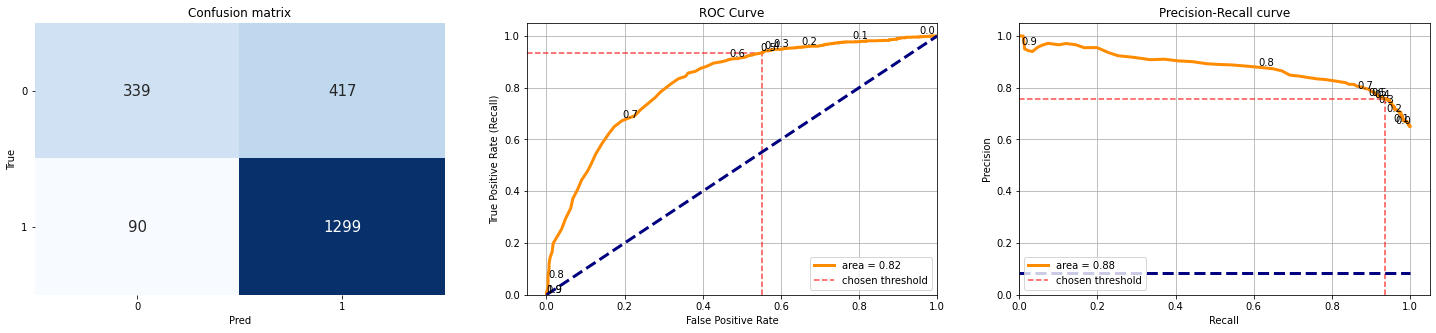

In [ ]:
# implement RandomForest Classifier
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(n_estimators=200,criterion='entropy')
rf.fit(X_train,y_train)
predict_rf = rf.predict(X_test)
predicted_prob_rf = rf.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_rf, predicted_prob_rf, figsize=(25,5))

In [ ]:
X_train, X_test, y_train, y_test = split_data(x_tfidf,df_data['NS'])

Accuracy (overall correct predictions): 0.87
Auc: 0.88
Recall (all 1s predicted right): 0.99
Precision (confidence when predicting a 1): 0.85
F1 score: 0.91
Detail:
              precision    recall  f1-score   support

           0       0.97      0.62      0.75       680
           1       0.85      0.99      0.91      1465

    accuracy                           0.87      2145
   macro avg       0.91      0.80      0.83      2145
weighted avg       0.89      0.87      0.86      2145



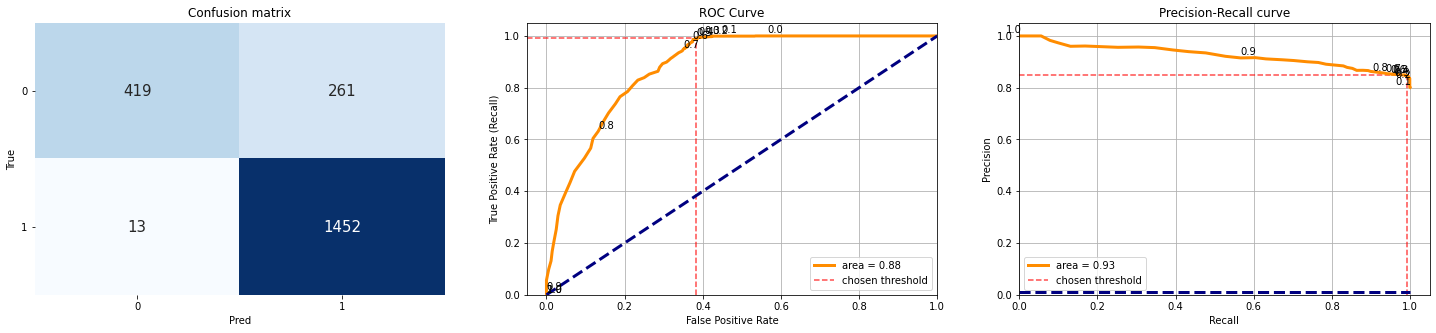

In [ ]:
# implement RandomForest Classifier
from sklearn.ensemble import RandomForestClassifier
rf_ns=RandomForestClassifier(n_estimators=200,criterion='entropy')
rf_ns.fit(X_train,y_train)
predict_rf = rf_ns.predict(X_test)
predicted_prob_rf = rf_ns.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_rf, predicted_prob_rf, figsize=(25,5))

In [ ]:
#getting splited data
X_train, X_test, y_train, y_test = split_data(x_tfidf,df_data['FT'])

Accuracy (overall correct predictions): 0.72
Auc: 0.8
Recall (all 1s predicted right): 0.81
Precision (confidence when predicting a 1): 0.71
F1 score: 0.76
Detail:
              precision    recall  f1-score   support

           0       0.75      0.63      0.68      1007
           1       0.71      0.81      0.76      1138

    accuracy                           0.72      2145
   macro avg       0.73      0.72      0.72      2145
weighted avg       0.73      0.72      0.72      2145



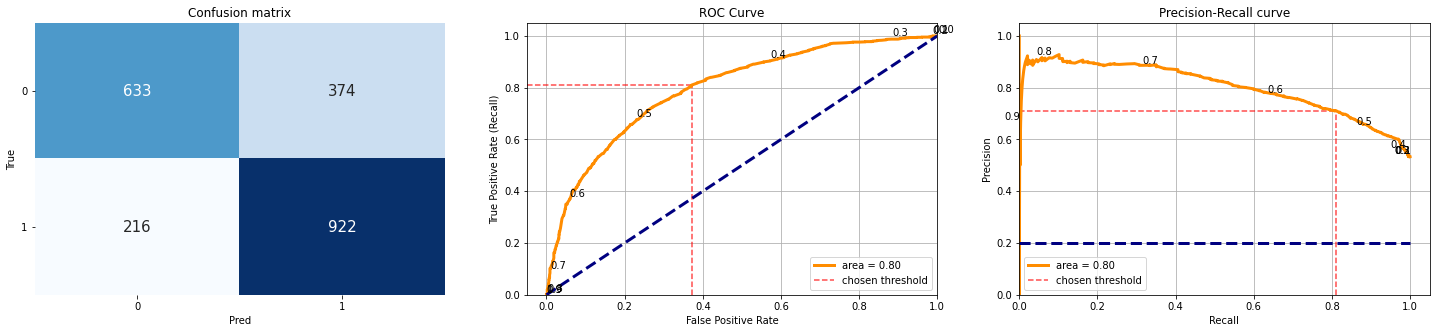

In [ ]:
# implement RandomForest Classifier
from sklearn.ensemble import RandomForestClassifier
rf_ft=RandomForestClassifier(n_estimators=200,criterion='entropy')
rf_ft.fit(X_train,y_train)
predict_rf = rf_ft.predict(X_test)
predicted_prob_rf = rf_ft.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_rf, predicted_prob_rf, figsize=(25,5))

In [ ]:
#getting splited data
X_train, X_test, y_train, y_test = split_data(x_tfidf,df_data['PJ'])

Accuracy (overall correct predictions): 0.65
Auc: 0.73
Recall (all 1s predicted right): 0.86
Precision (confidence when predicting a 1): 0.63
F1 score: 0.73
Detail:
              precision    recall  f1-score   support

           0       0.69      0.39      0.50       965
           1       0.63      0.86      0.73      1180

    accuracy                           0.65      2145
   macro avg       0.66      0.62      0.61      2145
weighted avg       0.66      0.65      0.63      2145



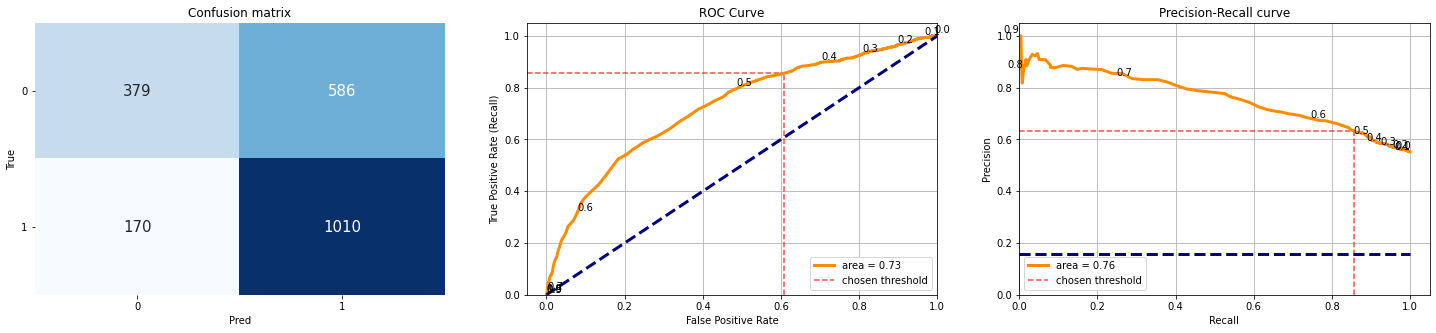

In [ ]:
# implement RandomForest Classifier
from sklearn.ensemble import RandomForestClassifier
rf_pj=RandomForestClassifier(n_estimators=200,criterion='entropy')
rf_pj.fit(X_train,y_train)
predict_rf = rf_pj.predict(X_test)
predicted_prob_rf = rf_pj.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_rf, predicted_prob_rf, figsize=(25,5))

PassiveAggressiveClassifier

In [ ]:
X_train, X_test, y_train, y_test = split_data(x_tfidf,df_data['IE'])

Accuracy (overall correct predictions): 0.73
Recall (all 1s predicted right): 0.8
Precision (confidence when predicting a 1): 0.78
F1 score: 0.79
Detail:
              precision    recall  f1-score   support

           0       0.61      0.59      0.60       756
           1       0.78      0.80      0.79      1389

    accuracy                           0.73      2145
   macro avg       0.70      0.69      0.70      2145
weighted avg       0.72      0.73      0.72      2145



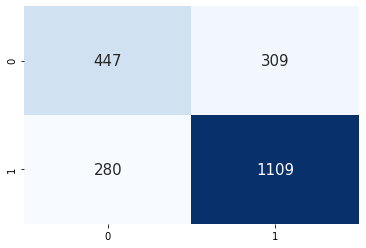

In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier

pa = PassiveAggressiveClassifier()
pa.fit(X_train,y_train)
predict_pac = pa.predict(X_test)

## Accuray e AUC
accuracy = metrics.accuracy_score(y_test, predict_pac)
print("Accuracy (overall correct predictions):",  round(accuracy,2))

recall = metrics.recall_score(y_test, predict_pac)  #= true 1s / all 1s in test (got and missed)
precision = metrics.precision_score(y_test, predict_pac)  #= true 1s / all 1s predicted (true 1s + false 1s)
f1 = metrics.f1_score(y_test, predict_pac)  #=2 * (precision * recall) / (precision + recall)
print("Recall (all 1s predicted right):", round(recall,2))  #true positive rate, how many 1s I got
print("Precision (confidence when predicting a 1):", round(precision,2))  #how many 1s were really 1s
print("F1 score:", round(f1,2))
print("Detail:")
classes = np.unique(y_test)
print(metrics.classification_report(y_test, predict_pac, target_names=[str(i) for i in classes]))

## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predict_pac, labels=classes)
sns.heatmap(cm, annot=True, annot_kws={"size":15}, fmt='d',cmap=plt.cm.Blues, cbar=False)

In [ ]:
X_train, X_test, y_train, y_test = split_data(x_tfidf,df_data['NS'])

Accuracy (overall correct predictions): 0.83
Recall (all 1s predicted right): 0.89
Precision (confidence when predicting a 1): 0.87
F1 score: 0.88
Detail:
              precision    recall  f1-score   support

           0       0.75      0.71      0.73       680
           1       0.87      0.89      0.88      1465

    accuracy                           0.83      2145
   macro avg       0.81      0.80      0.81      2145
weighted avg       0.83      0.83      0.83      2145



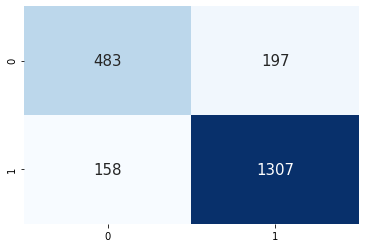

In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier

pa_ns = PassiveAggressiveClassifier()
pa_ns.fit(X_train,y_train)
predict_pac = pa_ns.predict(X_test)

## Accuray e AUC
accuracy = metrics.accuracy_score(y_test, predict_pac)
print("Accuracy (overall correct predictions):",  round(accuracy,2))

recall = metrics.recall_score(y_test, predict_pac)  #= true 1s / all 1s in test (got and missed)
precision = metrics.precision_score(y_test, predict_pac)  #= true 1s / all 1s predicted (true 1s + false 1s)
f1 = metrics.f1_score(y_test, predict_pac)  #=2 * (precision * recall) / (precision + recall)
print("Recall (all 1s predicted right):", round(recall,2))  #true positive rate, how many 1s I got
print("Precision (confidence when predicting a 1):", round(precision,2))  #how many 1s were really 1s
print("F1 score:", round(f1,2))
print("Detail:")
classes = np.unique(y_test)
print(metrics.classification_report(y_test, predict_pac, target_names=[str(i) for i in classes]))

## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predict_pac, labels=classes)
sns.heatmap(cm, annot=True, annot_kws={"size":15}, fmt='d',cmap=plt.cm.Blues, cbar=False)

In [ ]:
X_train, X_test, y_train, y_test = split_data(x_tfidf,df_data['FT'])

Accuracy (overall correct predictions): 0.69
Recall (all 1s predicted right): 0.7
Precision (confidence when predicting a 1): 0.71
F1 score: 0.7
Detail:
              precision    recall  f1-score   support

           0       0.66      0.68      0.67      1007
           1       0.71      0.70      0.70      1138

    accuracy                           0.69      2145
   macro avg       0.69      0.69      0.69      2145
weighted avg       0.69      0.69      0.69      2145



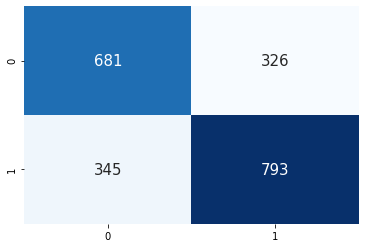

In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier

pa_ft = PassiveAggressiveClassifier()
pa_ft.fit(X_train,y_train)
predict_pac = pa_ft.predict(X_test)

## Accuray e AUC
accuracy = metrics.accuracy_score(y_test, predict_pac)
print("Accuracy (overall correct predictions):",  round(accuracy,2))

recall = metrics.recall_score(y_test, predict_pac)  #= true 1s / all 1s in test (got and missed)
precision = metrics.precision_score(y_test, predict_pac)  #= true 1s / all 1s predicted (true 1s + false 1s)
f1 = metrics.f1_score(y_test, predict_pac)  #=2 * (precision * recall) / (precision + recall)
print("Recall (all 1s predicted right):", round(recall,2))  #true positive rate, how many 1s I got
print("Precision (confidence when predicting a 1):", round(precision,2))  #how many 1s were really 1s
print("F1 score:", round(f1,2))
print("Detail:")
classes = np.unique(y_test)
print(metrics.classification_report(y_test, predict_pac, target_names=[str(i) for i in classes]))

## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predict_pac, labels=classes)
sns.heatmap(cm, annot=True, annot_kws={"size":15}, fmt='d',cmap=plt.cm.Blues, cbar=False)

In [ ]:
X_train, X_test, y_train, y_test = split_data(x_tfidf,df_data['PJ'])

Accuracy (overall correct predictions): 0.61
Recall (all 1s predicted right): 0.66
Precision (confidence when predicting a 1): 0.65
F1 score: 0.65
Detail:
              precision    recall  f1-score   support

           0       0.57      0.56      0.57       965
           1       0.65      0.66      0.65      1180

    accuracy                           0.61      2145
   macro avg       0.61      0.61      0.61      2145
weighted avg       0.61      0.61      0.61      2145



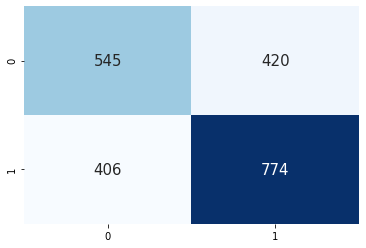

In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier

pa_pj = PassiveAggressiveClassifier()
pa_pj.fit(X_train,y_train)
predict_pac = pa_pj.predict(X_test)

## Accuray e AUC
accuracy = metrics.accuracy_score(y_test, predict_pac)
print("Accuracy (overall correct predictions):",  round(accuracy,2))

recall = metrics.recall_score(y_test, predict_pac)  #= true 1s / all 1s in test (got and missed)
precision = metrics.precision_score(y_test, predict_pac)  #= true 1s / all 1s predicted (true 1s + false 1s)
f1 = metrics.f1_score(y_test, predict_pac)  #=2 * (precision * recall) / (precision + recall)
print("Recall (all 1s predicted right):", round(recall,2))  #true positive rate, how many 1s I got
print("Precision (confidence when predicting a 1):", round(precision,2))  #how many 1s were really 1s
print("F1 score:", round(f1,2))
print("Detail:")
classes = np.unique(y_test)
print(metrics.classification_report(y_test, predict_pac, target_names=[str(i) for i in classes]))

## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predict_pac, labels=classes)
sns.heatmap(cm, annot=True, annot_kws={"size":15}, fmt='d',cmap=plt.cm.Blues, cbar=False)

## **SVM**

In [25]:
X_train, X_test, y_train, y_test = split_data(x_tfidf,df_data['IE'])

Accuracy (overall correct predictions): 0.8
Auc: 0.87
Recall (all 1s predicted right): 0.93
Precision (confidence when predicting a 1): 0.8
F1 score: 0.86
Detail:
              precision    recall  f1-score   support

           0       0.82      0.57      0.67       756
           1       0.80      0.93      0.86      1389

    accuracy                           0.80      2145
   macro avg       0.81      0.75      0.77      2145
weighted avg       0.81      0.80      0.79      2145



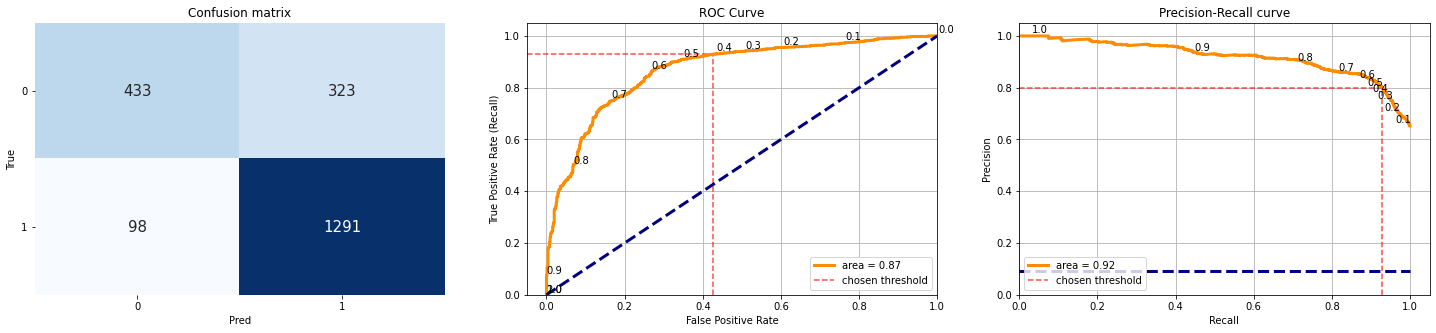

In [ ]:
# implement SVC Classifier
from sklearn.svm import SVC
svc_TF_ie=SVC(probability=True)
svc_TF_ie.fit(X_train,y_train)
predict_svc = svc_TF_ie.predict(X_test)
predicted_prob_svc = svc_TF_ie.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_svc, predicted_prob_svc, figsize=(25,5))

In [ ]:
# implement SVC Classifier
from sklearn.svm import SVC
svc_TF_ie=SVC(probability=True)
svc_TF_ie.fit(X_train,y_train)
predict_svc = svc_TF_ie.predict(X_test)
predicted_prob_svc = svc_TF_ie.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_svc, predicted_prob_svc, figsize=(25,5))

model_name = '/content/drive/My Drive/Outbound/Naya_wala/mbti_TF_IE.joblib.dat'
dump(svc_TF_ie, model_name)

In [ ]:
#naya

In [ ]:
X_train, X_test, y_train, y_test = split_data(x_tfidf,df_data['NS'])

Accuracy (overall correct predictions): 0.88
Auc: 0.91
Recall (all 1s predicted right): 0.99
Precision (confidence when predicting a 1): 0.86
F1 score: 0.92
Detail:
              precision    recall  f1-score   support

           0       0.97      0.64      0.77       680
           1       0.86      0.99      0.92      1465

    accuracy                           0.88      2145
   macro avg       0.91      0.81      0.84      2145
weighted avg       0.89      0.88      0.87      2145



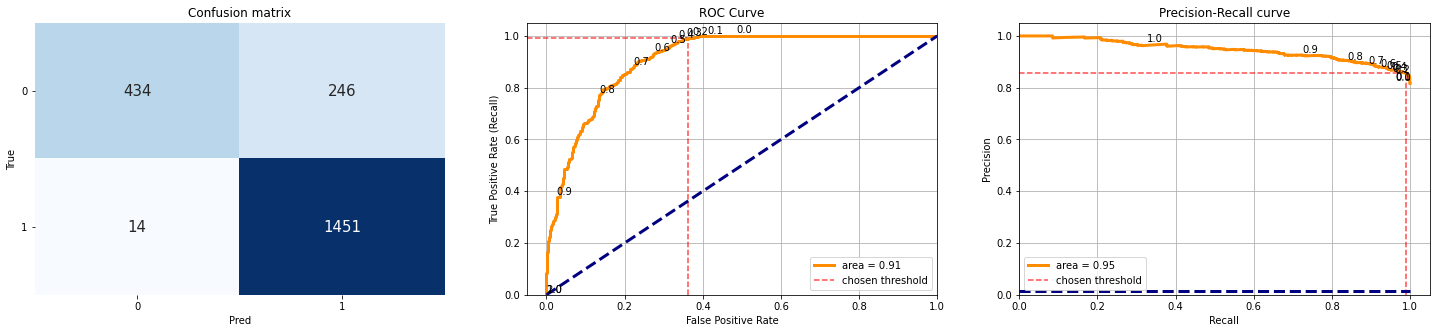

In [ ]:
# implement SVC Classifier
from sklearn.svm import SVC
svc_TF_ns=SVC(probability=True)
svc_TF_ns.fit(X_train,y_train)
predict_svc = svc_TF_ns.predict(X_test)
predicted_prob_svc = svc_TF_ns.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_svc, predicted_prob_svc, figsize=(25,5))

In [ ]:
X_train, X_test, y_train, y_test = split_data(x_tfidf,df_data['FT'])

Accuracy (overall correct predictions): 0.76
Auc: 0.85
Recall (all 1s predicted right): 0.81
Precision (confidence when predicting a 1): 0.75
F1 score: 0.78
Detail:
              precision    recall  f1-score   support

           0       0.77      0.70      0.73      1007
           1       0.75      0.81      0.78      1138

    accuracy                           0.76      2145
   macro avg       0.76      0.76      0.76      2145
weighted avg       0.76      0.76      0.76      2145



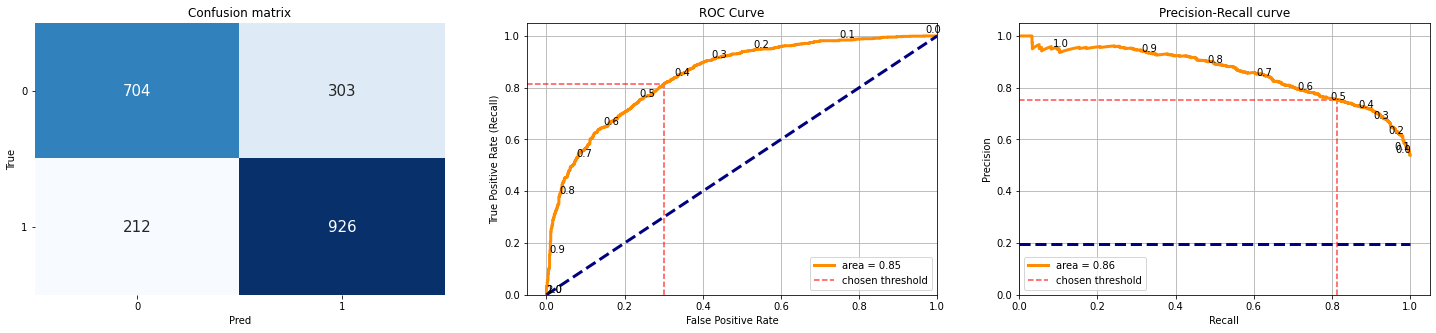

In [ ]:
# implement SVC Classifier
from sklearn.svm import SVC
svc_TF_ft=SVC(probability=True)
svc_TF_ft.fit(X_train,y_train)
predict_svc = svc_TF_ft.predict(X_test)
predicted_prob_svc = svc_TF_ft.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_svc, predicted_prob_svc, figsize=(25,5))

In [ ]:
X_train, X_test, y_train, y_test = split_data(x_tfidf,df_data['PJ'])

Accuracy (overall correct predictions): 0.7
Auc: 0.76
Recall (all 1s predicted right): 0.79
Precision (confidence when predicting a 1): 0.7
F1 score: 0.75
Detail:
              precision    recall  f1-score   support

           0       0.70      0.59      0.64       965
           1       0.70      0.79      0.75      1180

    accuracy                           0.70      2145
   macro avg       0.70      0.69      0.69      2145
weighted avg       0.70      0.70      0.70      2145



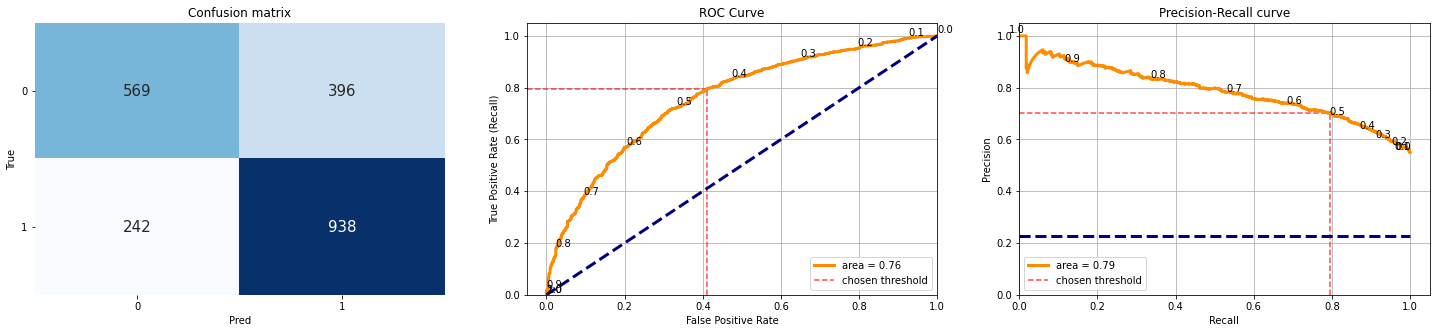

In [ ]:
# implement SVC Classifier
from sklearn.svm import SVC
svc_TF_pj=SVC(probability=True)
svc_TF_pj.fit(X_train,y_train)
predict_svc = svc_TF_pj.predict(X_test)
predicted_prob_svc = svc_TF_pj.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_svc, predicted_prob_svc, figsize=(25,5))

In [ ]:
def predict3(posts):

  #for storing the output
  result = []
  text_do = []
  text_donts = []
  text_ib = []

  #creating the data frame
  df_text = pd.DataFrame(data={'Text': [posts]})

  #data cleaning
  Corpus = text_process(df_text,columns='Text')

  #transforming the feature
  x = transform_feature(Corpus,tech='tfidf')
  
  #predicting the value Introvert / extrovert
  predictions_tfie = svc_TF_ie.predict(x)
  prob_IE = svc_TF_ie.predict_proba(x)
  result.append(predictionstfie[0])

  #predicting the value Introvert / extrovert
  predictions_tfns = svc_TF_ns.predict(x)
  prob_NS = svc_TF_ns.predict_proba(x)
  result.append(predictions_tfns[0])

  #predicting the value Introvert / extrovert
  predictions_tfft = svc_TF_ft.predict(x)
  prob_FT = svc_TF_ft.predict_proba(x)
  result.append(predictions_tfft[0])

  #predicting the value Introvert / extrovert
  predictions_tfpj = svc_TF_pj.predict(x)
  prob_PJ = svc_TF_pj.predict_proba(x)
  result.append(predictions_tfpj[0])
  
  s,t = translate_data_back(result)
   
  if s=='INTP':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ENTP':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='INFJ':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='INTJ':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ENTJ':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ENFJ':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='INFP':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ENFP':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ISFP':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ISTP':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ISFJ':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ISTJ':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ESTP':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ESFP':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ESTJ':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  else:
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')

  draw_graph(prob_IE=prob_IE,prob_NS=prob_NS,prob_FT=prob_FT,prob_PJ=prob_PJ,s=s)
  #print(translate_data_back(result))
  print(s,t)

  return text_do,text_donts,text_ib,prob_IE,prob_NS,prob_FT,prob_PJ

In [ ]:
my_posts  = """It requires belief that is outside of a logical framework and isnâ€™t worth positing because itâ€™s just you affirming your own beliefs which means nothing to anyone."""
a,b,c,d,e,f,g = predict3(my_posts)

## **XGB Classifier**

Introvert / Extrovert

In [ ]:
X_train, X_test, y_train, y_test = split_data(x_tfidf,df_data['IE'])

Accuracy (overall correct predictions): 0.84
Auc: 0.9
Recall (all 1s predicted right): 0.91
Precision (confidence when predicting a 1): 0.85
F1 score: 0.88
Detail:
              precision    recall  f1-score   support

           0       0.81      0.71      0.76       756
           1       0.85      0.91      0.88      1393

    accuracy                           0.84      2149
   macro avg       0.83      0.81      0.82      2149
weighted avg       0.84      0.84      0.84      2149



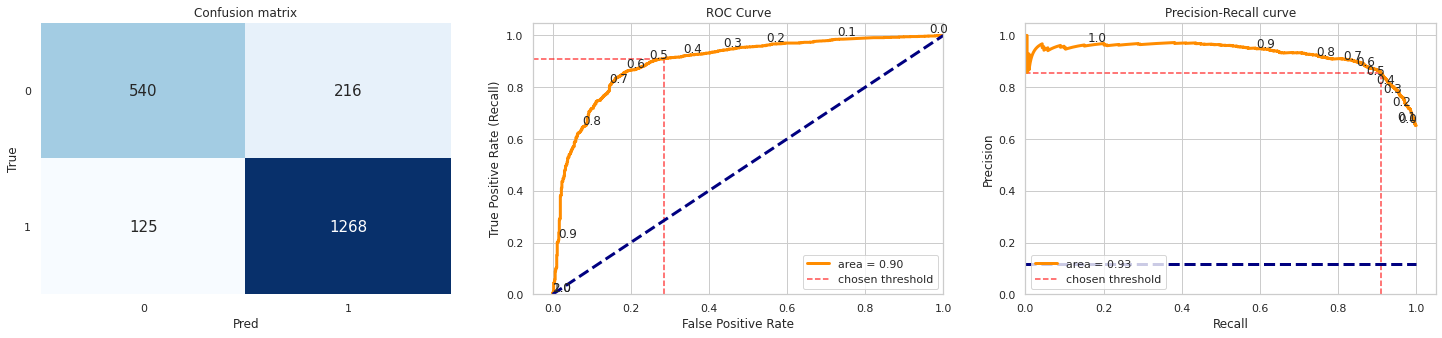

In [ ]:
from xgboost import XGBClassifier

model_ie_tfidf = XGBClassifier(learning_rate=0.2, n_estimators = 200,nthread=8,max_depth = 2)
model_ie_tfidf.fit(X_train, y_train)
predict_xgb = model_ie_tfidf.predict(X_test)
predicted_prob = model_ie_tfidf.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_xgb, predicted_prob, figsize=(25,5))

Intuition / Sensing

In [ ]:
X_train, X_test, y_train, y_test = split_data(x_tfidf,df_data['NS'])

Accuracy (overall correct predictions): 0.91
Auc: 0.95
Recall (all 1s predicted right): 0.97
Precision (confidence when predicting a 1): 0.91
F1 score: 0.94
Detail:
              precision    recall  f1-score   support

           0       0.92      0.78      0.84       656
           1       0.91      0.97      0.94      1493

    accuracy                           0.91      2149
   macro avg       0.92      0.87      0.89      2149
weighted avg       0.91      0.91      0.91      2149



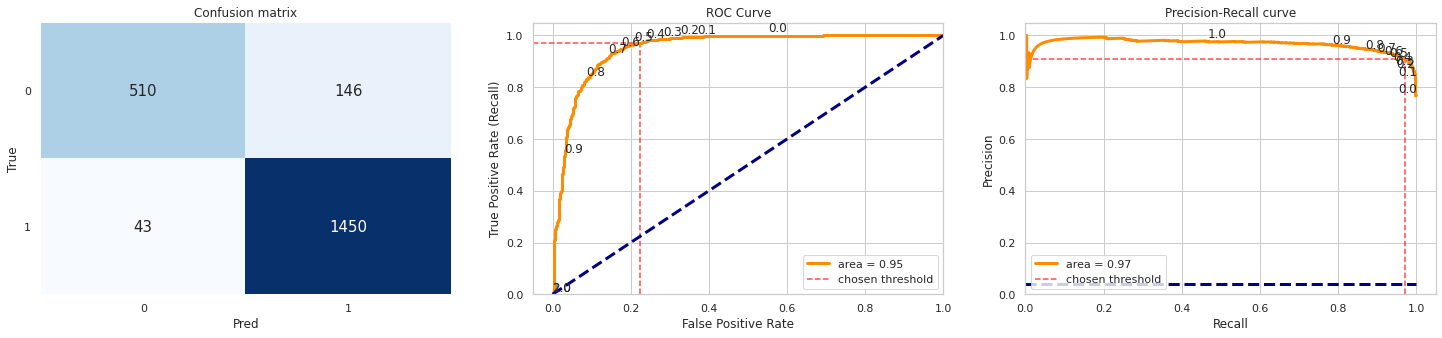

In [ ]:

model_ns_tfidf = XGBClassifier(learning_rate=0.2, n_estimators = 200,nthread=8,max_depth = 2)
model_ns_tfidf.fit(X_train, y_train)
predict_xgb = model_ns_tfidf.predict(X_test)
predicted_prob = model_ns_tfidf.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_xgb, predicted_prob, figsize=(25,5))

Feeling / Thinking

In [ ]:
#getting splited data
X_train, X_test, y_train, y_test = split_data(x,df_data['FT'])

Accuracy (overall correct predictions): 0.8
Auc: 0.88
Recall (all 1s predicted right): 0.86
Precision (confidence when predicting a 1): 0.79
F1 score: 0.82
Detail:
              precision    recall  f1-score   support

           0       0.82      0.74      0.78      1002
           1       0.79      0.86      0.82      1147

    accuracy                           0.80      2149
   macro avg       0.80      0.80      0.80      2149
weighted avg       0.80      0.80      0.80      2149



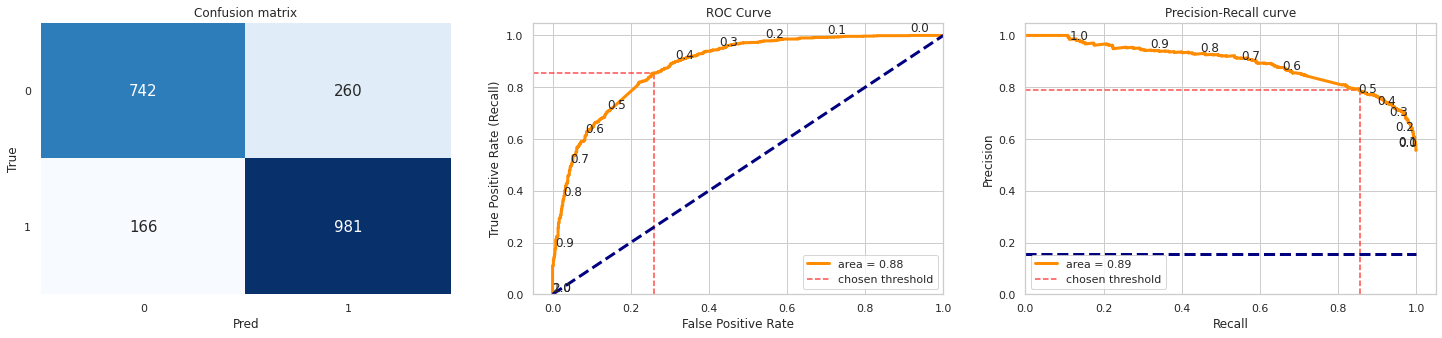

In [ ]:
from xgboost import XGBClassifier

model_ft_tfidf = XGBClassifier(learning_rate=0.2, n_estimators = 200,nthread=8,max_depth = 2)
model_ft_tfidf.fit(X_train, y_train)
predict_xgb = model_ft_tfidf.predict(X_test)
predicted_prob = model_ft_tfidf.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_xgb, predicted_prob, figsize=(25,5))

perceiving / judgemental

In [ ]:
#getting splited data
X_train, X_test, y_train, y_test = split_data(x,df_data['PJ'])

Accuracy (overall correct predictions): 0.77
Auc: 0.84
Recall (all 1s predicted right): 0.78
Precision (confidence when predicting a 1): 0.81
F1 score: 0.79
Detail:
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       948
           1       0.81      0.78      0.79      1201

    accuracy                           0.77      2149
   macro avg       0.77      0.77      0.77      2149
weighted avg       0.77      0.77      0.77      2149



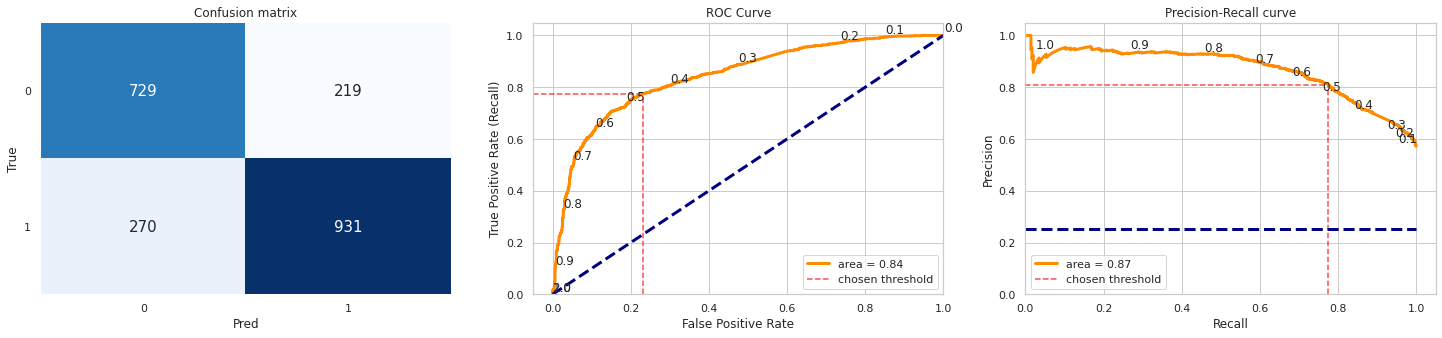

In [ ]:
from xgboost import XGBClassifier

model_pj_tfidf = XGBClassifier(learning_rate=0.2, n_estimators = 200,nthread=8,max_depth = 2)
model_pj_tfidf.fit(X_train, y_train)
predict_xgb = model_pj_tfidf.predict(X_test)
predicted_prob = model_pj_tfidf.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_xgb, predicted_prob, figsize=(25,5))

In [ ]:
def predict(posts):

  #for storing the output
  result = []
  text_do = []
  text_donts = []
  text_ib = []

  #creating the data frame
  df_text = pd.DataFrame(data={'Text': [posts]})

  #data cleaning
  Corpus = text_process(df_text,columns='Text')

  #transforming the feature
  load_bow = load("/content/drive/My Drive/LinkedIn/Models/bow.joblib.dat")
  x = load_bow.transform(Corpus).toarray()

  #loading the model for prediction Introvert / extrovert
  loaded_model_IE = load("/content/drive/My Drive/LinkedIn/Models/mbti_IE.joblib.dat")
  #loading the model for prediction Intuition / sensing
  loaded_model_NS = load("/content/drive/My Drive/LinkedIn/Models/mbti_NS.joblib.dat")
  #loading the model for prediction feeling / thining
  loaded_model_FT = load("/content/drive/My Drive/LinkedIn/Models/mbti_FT.joblib.dat")
  #loading the model for prediction perceiving / judgemental
  loaded_model_PJ = load("/content/drive/My Drive/LinkedIn/Models/mbti_PJ.joblib.dat")

  #predicting the value Introvert / extrovert
  predictions = loaded_model_IE.predict(x)
  prob_IE = loaded_model_IE.predict_proba(x)
  result.append(predictions[0])

  #predicting the value Introvert / extrovert
  predictions = loaded_model_NS.predict(x)
  prob_NS = loaded_model_NS.predict_proba(x)
  result.append(predictions[0])

  #predicting the value Introvert / extrovert
  predictions = loaded_model_FT.predict(x)
  prob_FT = loaded_model_FT.predict_proba(x)
  result.append(predictions[0])

  #predicting the value Introvert / extrovert
  predictions = loaded_model_PJ.predict(x)
  prob_PJ = loaded_model_PJ.predict_proba(x)
  result.append(predictions[0])
  
  s,t = translate_data_back(result)
   
  if s=='INTP':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ENTP':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='INFJ':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='INTJ':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ENTJ':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ENFJ':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='INFP':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ENFP':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ISFP':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ISTP':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ISFJ':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ISTJ':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ESTP':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ESFP':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  elif s=='ESTJ':
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')
  else:
    text_do.append('do')
    text_donts.append("don't")
    text_ib.append('ib')

  draw_graph(prob_IE=prob_IE,prob_NS=prob_NS,prob_FT=prob_FT,prob_PJ=prob_PJ,s=s)
  #print(translate_data_back(result))
  print(s,t)

  return text_do,text_donts,text_ib,prob_IE,prob_NS,prob_FT,prob_PJ

ESTJ Person possesses following personality :-  Extroversion, Sensing, Thinking, Judging


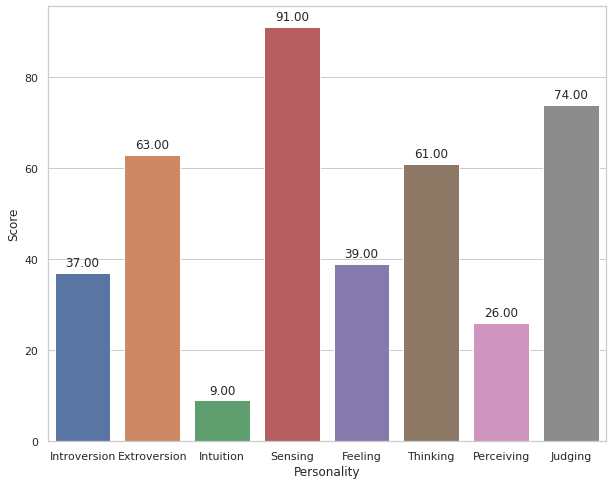

In [ ]:
my_posts  = """Getting started with data science and applying machine learning has never been as simple as it is now. There are many free and paid online tutorials and courses out there to help you to get started. I’ve recently started to learn, play, and work on Data Science & Machine Learning on Kaggle.com. In this brief post, I’d like to share my experience with the Kaggle Python Docker image, which simplifies the Data Scientist’s life.
Awesome #AWS monitoring introduction.
HPE Software (now @MicroFocusSW) won the platinum reader's choice #ITAWARDS 2017 in the new category #CloudMonitoring
Certified as AWS Certified Solutions Architect 
Hi, please have a look at my Udacity interview about online learning and machine learning,
Very interesting to see the  lessons learnt during the HP Operations Orchestration to CloudSlang journey. http://bit.ly/1Xo41ci 
I came across a post on devopsdigest.com and need your input: “70% DevOps organizations Unhappy with DevOps Monitoring Tools”
In a similar investigation I found out that many DevOps organizations use several monitoring tools in parallel. Senu, Nagios, LogStach and SaaS offerings such as DataDog or SignalFX to name a few. However, one element is missing: Consolidation of alerts and status in a single pane of glass, which enables fast remediation of application and infrastructure uptime and performance issues.
Sure, there are commercial tools on the market for exactly this use case but these tools are not necessarily optimized for DevOps.
So, here my question to you: In your DevOps project, have you encountered that the lack of consolidation of alerts and status is a real issue? If yes, how did you approach the problem? Or is an ChatOps approach just right?
You will probably hear more and more about ChatOps - at conferences, DevOps meet-ups or simply from your co-worker at the coffee station. ChatOps is a term and concept coined by GitHub. It's about the conversation-driven development, automation, and operations.
Now the question is: why and how would I, as an ops-focused engineer, implement and use ChatOps in my organization? The next question then is: How to include my tools into the chat conversation?
Let’s begin by having a look at a use case. The Closed Looped Incidents Process (CLIP) can be rejuvenated with ChatOps. The work from the incident detection runs through monitoring until the resolution of issues in your application or infrastructure can be accelerated with improved, cross-team communication and collaboration.
In this blog post, I am going to describe and share my experience with deploying HP Operations Manager i 10.0 (OMi) on HP Helion Public Cloud. An Infrastructure as a Service platform such as HP Helion Public Cloud Compute is a great place to quickly spin-up a Linux server and install HP Operations Manager i for various use scenarios. An example of a good use case is monitoring workloads across public clouds such as AWS and Azure."""

a,b,c = predict(my_posts)

ESFJ Person possesses following personality :-  Extroversion, Sensing, Feeling, Judging


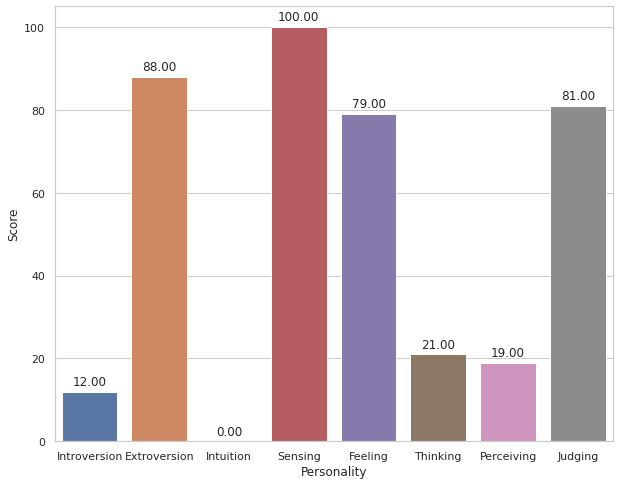

In [ ]:
my_posts ="""A Software Developer with a passion for Machine Learning and Artificial Intelligence, specifically Computer Vision in Healthcare. Viridiana is an active member in Latinas in Tech and Women Techmakers communities. She enjoys creating data-driven projects and sharing what she learn to the world! Self-Learning is key."""
df_prob = predict(my_posts)

ESFJ Person possesses following personality :-  Extroversion, Sensing, Feeling, Judging


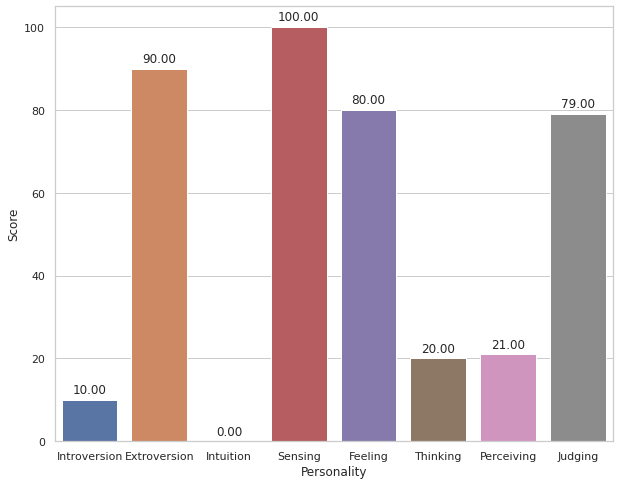

In [ ]:
my_posts ="""It’ll be fun, it’ll be a thrill. something stupid, something bad for you. Just something different"""
df_prob = predict(my_posts)

ESFJ Person possesses following personality :-  Extroversion, Sensing, Feeling, Judging


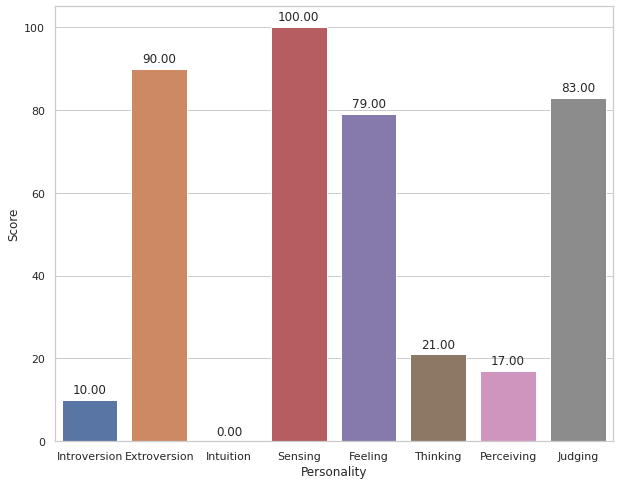

In [ ]:
my_posts ="""Hey, I’m not looking for social contacts. I have friends. I’m fine"""
df_prob = predict(my_posts)

ESFJ Person possesses following personality :-  Extroversion, Sensing, Feeling, Judging


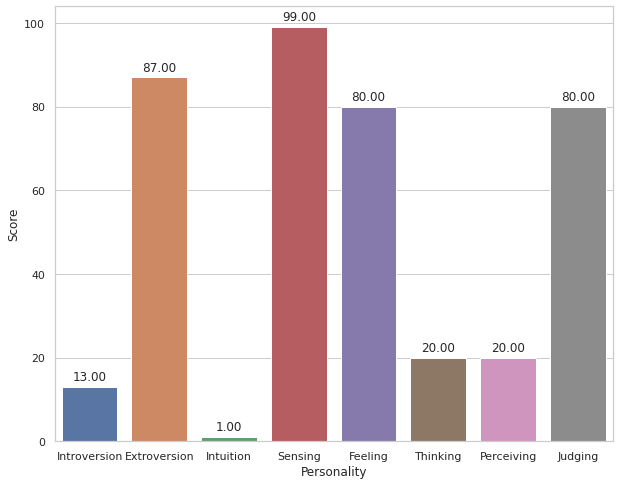

In [ ]:
my_posts ="""Quiet, friendly, sensitive, and kind. Enjoy the present moment, what’s going on around them. Like to have their own space and to work within their own time frame. Loyal and committed to their values and to people who are important to them. Dislike disagreements and conflicts, do not force their opinions or values on others."""

df_prob = predict(my_posts)

## Paul

ESFJ Person possesses following personality :-  Extroversion, Sensing, Feeling, Judging


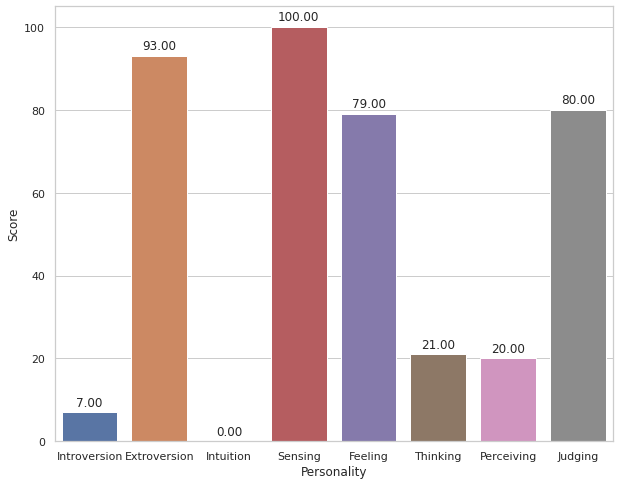

In [ ]:
my_posts = "Sales Tech focused, I'm super passionate about helping companies instantly access their ideal customer by automating the entire digital sales process working along side your CRM.Enabling sales teams to focus on what really matters closing deals, increasing revenue and growing faster."
#data cleaningre
df_prob = predict(my_posts)

Akshat profile

ESFJ Person possesses following personality :-  Extroversion, Sensing, Feeling, Judging


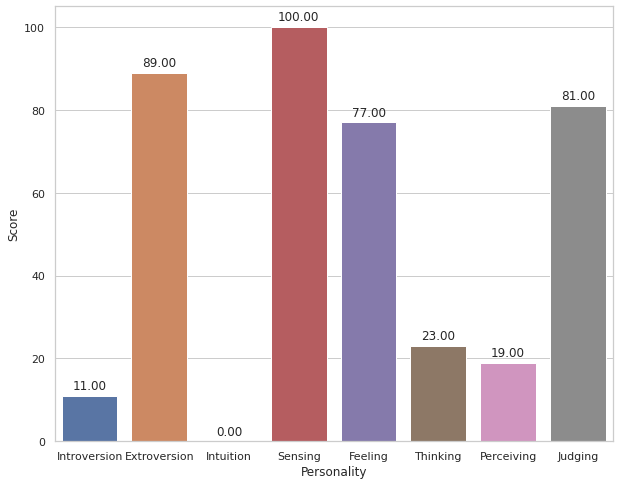

In [ ]:
my_posts = """Emerging technologies enthusiast, currently pursuing masters in the field of Image Processing and Analysis (Computer Vision, Machine Learning, GAN). Ex Intern at DRDO CAIR (Centre for Artificial Intelligence & Robotics, Defence Research & Development Organisation). Hands of experience with C++, Python, MatLab, Html5, Java"""
#data cleaningre
predict(my_posts)

Ajit 

ESFJ Person possesses following personality :-  Extroversion, Sensing, Feeling, Judging


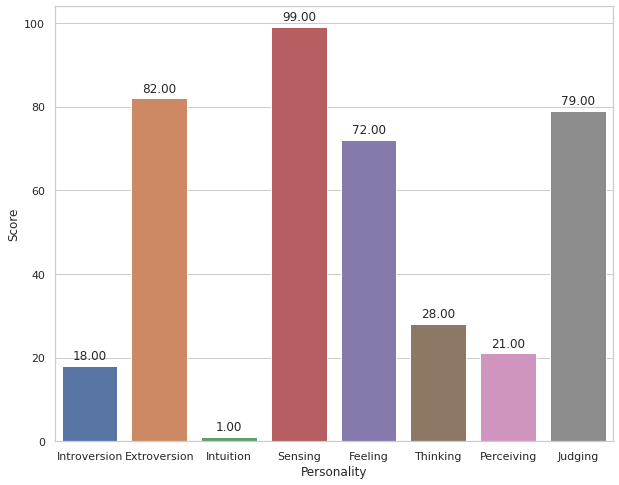

In [ ]:
my_posts = """Eligible to work in Ireland on Stamp 1G Visa

Pursued Msc. in Computing(Data Analytics) from Dublin City University. Passionate and quick learner with comprehensive expertise in ETL, Data Mining, Machine learning, R, Software Modeling, Data Visualization, Tableau.

Programming language: - Python, R(Statistical analysis), SQL, OPENSQL, ABAP, ABAP ON HANA, C/C++(Basics)
Tools: Jupyter notebook, Pycharm, google collab, R studio, Git, Eclipse, SAP, HANA Studio
Big data: Hadoop, hive, pig
Machine Learning: Pandas, sci-kit-learn, Supervised, Unsupervised, Classification, Regression, Clustering, Modeling, Dimensionality reduction, Model selection, Preprocessing

I worked as an SAP ABAP Consultant and have worked on various SAP opportunities and has experience in working for clients in various Industries like Steel, Wire, Ropes, Paper & power.
I have work experience of 3 years 11 months in SAP ABAP in different modules such as SD, MM, PP, PM, PS, APO, QM, and HR.
I have worked on 2 ECC implementations, 2 S4 Hana implementations, 2 rollouts, and 1 GST implementation to date.
Have experience in a client-facing role, understanding the requirement, analyzing and providing effective technical solutions for complex requirements catering to different clients.
I have good analytical and communication skills with problem detection/solving abilities and excellent temperament to multi-task and coordinate various activities under high pressure and time constraints. """

#data cleaningre
predict(my_posts)

**Leonor**

ESFJ Person possesses following personality :-  Extroversion, Sensing, Feeling, Judging


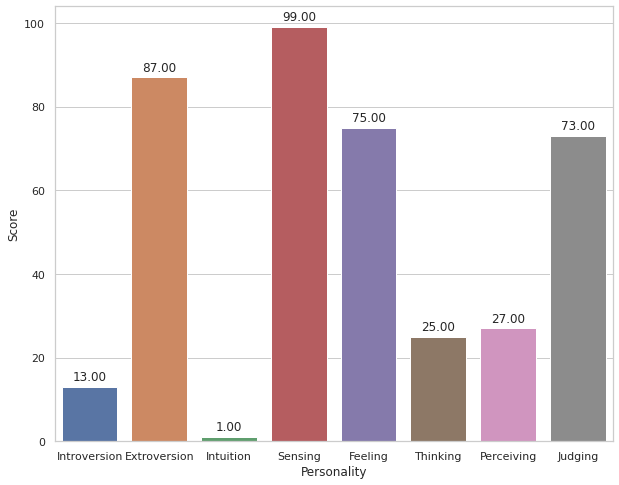

In [ ]:
my_posts = """ Actress and writer gone business woman and absolutely love it!
From accounting to sales and operations, I never say no to a challenge and approach every job with determination and a can-do attitude.
The ones who are crazy enough to think they can change the world, are the ones that do."""

#data cleaningre
predict(my_posts)

JD

ESFJ Person possesses following personality :-  Extroversion, Sensing, Feeling, Judging


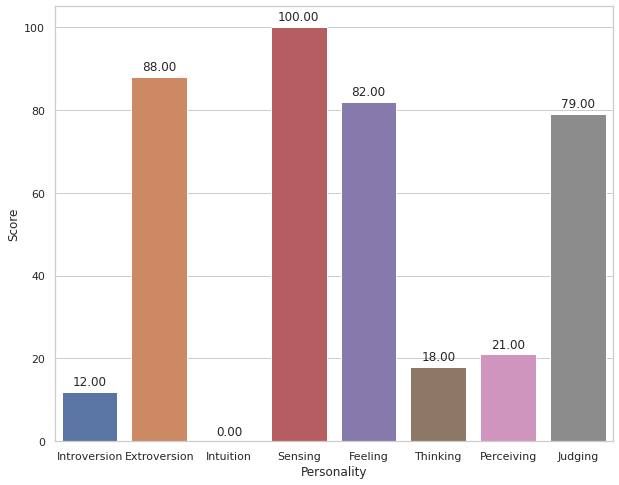

In [ ]:
my_posts = """A quick-thinking, creative and dedicated asset to any organization, love to be challenged and gain experience by getting involved with any and all opportunities put forward. Marketing professional with an M.Sc in Sales and Marketing from NUIG. I have over 3 years of work experience in sales and customer service working with reputed companies around the world."""

#data cleaningre
predict(my_posts)

Testing

INFJ Person possesses following personality :- Introversion, Intuition, Feeling, Judging


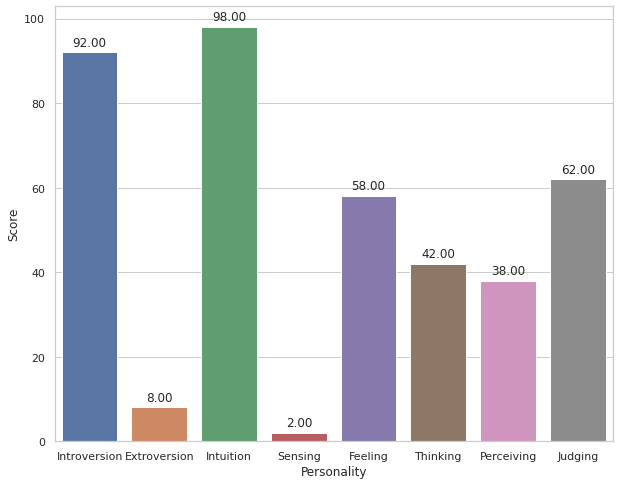

In [ ]:
my_posts = """ http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...|||Welcome and stuff.|||http://playeressence.com/wp-content/uploads/2013/08/RED-red-the-pokemon-master-32560474-450-338.jpg  Game. Set. Match.|||Prozac, wellbrutin, at least thirty minutes of moving your legs (and I don't mean moving them while sitting in your same desk chair), weed in moderation (maybe try edibles as a healthier alternative...|||Basically come up with three items you've determined that each type (or whichever types you want to do) would more than likely use, given each types' cognitive functions and whatnot, when left by...|||All things in moderation.  Sims is indeed a video game, and a good one at that. Note: a good one at that is somewhat subjective in that I am not completely promoting the death of any given Sim...|||Dear ENFP:  What were your favorite video games growing up and what are your now, current favorite video games? :cool:|||https://www.youtube.com/watch?v=QyPqT8umzmY|||It appears to be too late. :sad:|||There's someone out there for everyone.|||Wait... I thought confidence was a good thing.|||I just cherish the time of solitude b/c i revel within my inner world more whereas most other time i'd be workin... just enjoy the me time while you can. Don't worry, people will always be around to...|||Yo entp ladies... if you're into a complimentary personality,well, hey.|||... when your main social outlet is xbox live conversations and even then you verbally fatigue quickly.|||http://www.youtube.com/watch?v=gDhy7rdfm14  I really dig the part from 1:46 to 2:50|||http://www.youtube.com/watch?v=msqXffgh7b8|||Banned because this thread requires it of me.|||Get high in backyard, roast and eat marshmellows in backyard while conversing over something intellectual, followed by massages and kisses.|||http://www.youtube.com/watch?v=Mw7eoU3BMbE|||http://www.youtube.com/watch?v=4V2uYORhQOk|||http://www.youtube.com/watch?v=SlVmgFQQ0TI|||Banned for too many b's in that sentence. How could you! Think of the B!|||Banned for watching movies in the corner with the dunces.|||Banned because Health class clearly taught you nothing about peer pressure.|||Banned for a whole host of reasons!|||http://www.youtube.com/watch?v=IRcrv41hgz4|||1) Two baby deer on left and right munching on a beetle in the middle.  2) Using their own blood, two cavemen diary today's latest happenings on their designated cave diary wall.  3) I see it as...|||a pokemon world  an infj society  everyone becomes an optimist|||49142|||http://www.youtube.com/watch?v=ZRCEq_JFeFM|||http://discovermagazine.com/2012/jul-aug/20-things-you-didnt-know-about-deserts/desert.jpg|||http://oyster.ignimgs.com/mediawiki/apis.ign.com/pokemon-silver-version/d/dd/Ditto.gif|||http://www.serebii.net/potw-dp/Scizor.jpg|||Not all artists are artists because they draw. It's the idea that counts in forming something of your own... like a signature.|||Welcome to the robot ranks, person who downed my self-esteem cuz I'm not an avid signature artist like herself. :proud:|||Banned for taking all the room under my bed. Ya gotta learn to share with the roaches.|||http://www.youtube.com/watch?v=w8IgImn57aQ|||Banned for being too much of a thundering, grumbling kind of storm... yep.|||Ahh... old high school music I haven't heard in ages.   http://www.youtube.com/watch?v=dcCRUPCdB1w|||I failed a public speaking class a few years ago and I've sort of learned what I could do better were I to be in that position again. A big part of my failure was just overloading myself with too...|||I like this person's mentality. He's a confirmed INTJ by the way. http://www.youtube.com/watch?v=hGKLI-GEc6M|||Move to the Denver area and start a new life for myself."""
#data cleaningre
predict(my_posts)

Testing 2

ENFP Person possesses following personality :-  Extroversion, Intuition, Feeling, Perceiving


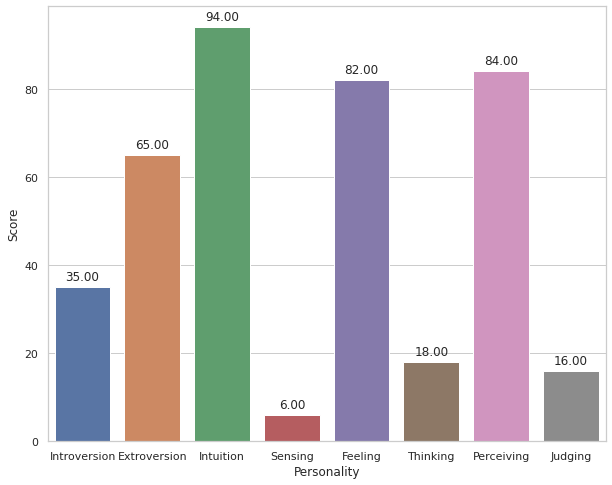

In [ ]:
my_posts = """He doesn't want to go on the trip without me, so me staying behind wouldn't be an option for him. I think he really does believe that I'm the one being unreasonable. He still continues to say that...|||I'm still completely in AWE and I'm AMAZED that he doesn't think twice about leaving one of them and how that will make them feel. He said he wants to tell them that I'm not willing to work extra for...|||Thanks, everyone. I'm struggling with being selfish and not just going ahead and working to pay for the rest. I don't want my husband to feel unloved or like I don't care about his feelings......but...|||My husband works an extra job each year to pay for a Disney World trip for the two of us, our son together and my two boys ages 12 and 13. He says the vacation is extremely important to him and...|||He said that it's not like he's asking me to do the 90 percent and he is only willing to do 10, but that it's the other way around. He's doing all the sacrificing and once again I'm  not willing to...|||My husband would rather that I be skinny with smaller boobs than heavier with slightly larger boobs, though I'm sure if he had his way he'd prefer skinny with larger boobs. Oh well.  I can't...|||.                Oh my gosh....this has me laughing my head off!!!|||As naive and short sighted as this sounds....I use to think that everyone thought and felt  the same way that I did. How I went for 30 something years before I realized that people are different and...|||I've also always been drawn to leasing agents and apartment management.|||I was a stay at home mom until around 6 years ago. I always had my hand in some kind of entrepreneur venture during that time though,  and found that I really loved training and speaking in front of...|||Hi guys, thought I'd update for anyone curious as to what's been going on.....  We've agreed that I would bring in x amount of money a month no matter how often I have to work for it, and that if...|||I've asked him to go to counseling with me in the past, and he said that he would. I began making arrangements for us to go and when I asked him if he had any preferences on some things, he backed...|||My husband would say, Should I just be okay with her weight and let it go even though it's important to me and should I just work my life away for the things I want extra just so she can be at  home...|||Am I in the wrong? Sometimes I feel as though I should just go ahead and work full time so that we can have a better lifestyle because that's what it takes these days and what it takes for my...|||I am not concerned with getting my feelings hurt by others who post things straight forward, harsh and the way they see it. I would prefer straight talk so that I can get to the bottom of things....|||All of that being said, he makes more than I do. Our bills are more than covered on the budget we have set up, but we like to eat out often and go to movies and take vacations and some spur of the...|||I could completely do without the extras until the kids are older. He says he doesn't mind working extra for the extras, but I am stealing from him if I don't make my half of the bills. Sooooo......I...|||I was supporting myself when we got together and saw myself financially fine down the road before I met him. He makes enough money to cover his own bills and a little bit more for a few extra things...|||He is only insisting on a weight around 117 or so because that probably IS my healthy weight. I'm 5'0. So I would have to lose about 15 pounds to reach my healthy weight.|||It is WAY easier to open up to strangers....and also to keep your personal business out of everyone else's close to you.   I kind of feel like the second bold statement....kind of. I do tell him...|||I certainly tend to shut down. I'm trying not to in this situation...  .....I guess the last sentence is true for me....I'm looking into whether or not this is normal acceptable behavior and if...|||This feels like  very good and practical advice. I believe I'm emotionally stable and mature enough to see through what I feel is negative raw emotion and glean from the rest.|||His hobby pays for vacation every year. He probably wouldn't lose that client, but he would have to pack up his studio twice a year and he says it's a real pain to do. And there is no guarantee that...|||He  waits tables for a living, so the money could be different. Right now, I  work 3 sometimes 4 nights a week myself so I could pick up extra  shifts. I believe he wants me to commit to at least 5...|||Hello everyone.....I have the dilemma again of only having about 10  minutes alone on the computer. I'm off over the weekend, so I'm still  hoping to be able to address individual posts here. I...|||My husband asked me how it's fair that my ex gets to pursue his dreams and I'm asking him to follow my ex, yet he has to leave behind his dreams.|||I realize this is kind of all over the place and there isn't nearly enough to go on here. I've seen comments about people reading posts and leaving their marriage because of it.....I can assure you...|||He waits tables for a living, so the money could be different. Right now, I work 3 sometimes 4 nights a week myself so I could pick up extra shifts. I believe he wants me to commit to at least 5 days...|||Hello everyone.....I have the dilemma again of only having about 10 minutes alone on the computer. I'm off over the weekend, so I'm still hoping to be able to address individual posts here. I wanted...|||I have to run now.....but I have so much more I'd like to respond to  from each of you. Again....I genuinely appreciate and value every point  of view. It helps me to learn more about him and more...|||I've  found myself wishing that my husband would be more loving toward me.  I've found myself feeling like I live with someone who is trying to get  what he wants out of this...|||Hi everyone! I've had a minute to post some thoughts, and I hope it's okay to copy them here. I haven't had a chance to get on the computer and my time is very limited.....also, as someone...|||I haven't read your PM yet....thank you so much for your input! :happy:|||I agree....it could ALWAYS be worse! And yes, if he constantly checked up on me and didn't trust me, that would be difficult, too. As for the promise being the biggest thing he's frustrated...|||I have to run now.....but I have so much more I'd like to respond to from each of you. Again....I genuinely appreciate and value every point of view. It helps me to learn more about him and more...|||Being honest with myself, I think that I find myself longing for him to  be concerned with how his words and actions affect me. Instead I feel as though he will use whatever tactic he needs until he...|||I've found myself wishing that my husband would be more loving toward me. I've found myself feeling like I live with someone who is trying to get what he wants out of this relationship...........and...|||I haven't been able to get on the computer until now......thank you to everyone who has taken the time and effort to respond! :) I've read through each and every response and have a few minutes to...|||Thank you so much for all of your advice! Ironically, I've watched SO many documentaries about our foods that you would think I would grow my own garden and only eat from that! It's ALL about...|||If I'm being honest, the extra 15 pounds probably isn't healthy. I'm 5'0  and it shows up more on me than a taller frame. It's just harder to  lose than the last time I did it. It's really not a...|||Thank you for your kind words! :)  I genuinely DO want him to be happy with me, but it IS a lot of pressure knowing that my weight is the key to him being happy with me. I know his personality type...|||He says  respectfully and kindly doesn't get him anywhere with me. He feels he has to be harsh or I won't get on the ball and do it. I totally agree that he has a selfish nature. But he also says...|||I honestly don't think he genuinely  cares. When I've told him that it makes me feel unloved and that it subconsciously has the opposite effect on me when he  pressures me, he just says Well, I've...|||I like SparkPeople. :)  Actually, if I worked out about 4 times a week and also lowered my calorie intake with healthier foods I would probably lose at least 10 of the 15 pounds. It's being...|||I'm 5'0 exactly, so the 15  pounds do show up on me in a couple of areas....mainly my mid-section and I just look a little heavier in general. The problem is that when we met, I had already had 4...|||Hello Everyone! I posted this in the ESTJ forum and got a few responses and would also like to know how any ENFP's would handle/feel about this situation:  :)  Thank you!   I'm an ENFP married 5...|||I'm 5'0 exactly, so the 15 or so pounds show up easily on me. I still look at pictures and think, well I'm not THAT big, but he wants me to be small like I use to be. Just his preference. It...|||While I do believe it has a whole lot to do with keeping my word.....I also believe the weight is still a huge issue. He still doesn't understand why I won't give him the one thing that's most...|||Thank you for your response. I'm just now beginning to understand how he operates so I'm trying not to get my feelings hurt. He absolutely won't tolerate lying and I can understand that, but  it has...|||Hi everyone. I'm an ENFP married 5 years to an ESTJ. Before we were married he asked me to agree that we would both do whatever it takes to stay basically our same weight for each other. My sincere..."""

#data cleaningre
predict(my_posts)

ISFP Person possesses following personality :- Introversion, Sensing, Feeling, Perceiving


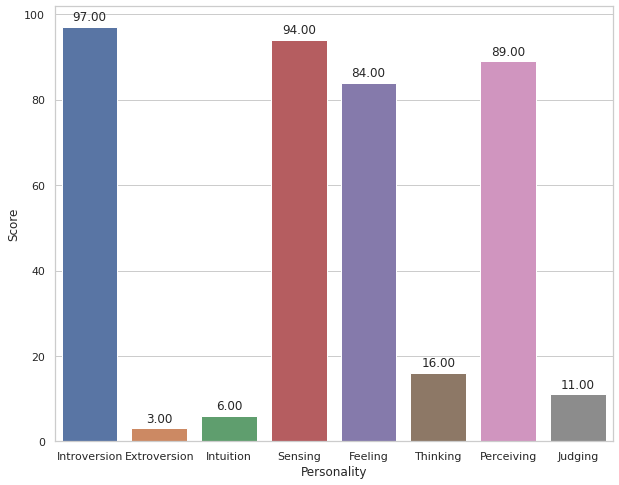

In [ ]:
my_posts = """'They paint without numbers|||I'd guess at istp too|||My best bud is ESFP, very funny, entertaining and a big softy. He can be draining, yapping away at everything, and often it's a one way conversation with him, yap yap yap lol. Would not be good to be...|||I used to smoke weed alot, everyday from morning till night for 3/4 years. It screwed my head up even when I stopped smoking it for good. I call it a head f*ck up. I went to docs then was passed onto...|||Jimi Hendrix - The Wind Cries Mary.  After all the jacks are in their boxes And the clowns have all gone to  bed You can hear happiness staggering on down the street ( My favorite line )...|||Gardening/Landscape designer or environmental conservation. Great practical work, very hands on, varied, rewarding and enjoyable.|||I loved This is England, Lol's a great character! 10/10 :D|||.|||Cogs|||infpaul haha.. erm cheers!|||namiki Well I reckon she trust you enough in private to share her inamost thoughts and opinions. I think the inconsistantcy in how she reacts to people who she's been slating,  is more to do with...|||Liontiger Thanks for your input although I'm not seeking answers on the net or from anyone really. I know my own mind and life desires. I just wonderd if any other women were in the same boat and...|||Sensitive enough to pick up on subtle cues. How I deal with them depends, it'll either crush me a little or I think ah bollocks. But yeah I'm sensitive to others.|||@BooksandButterflies  You sound totally like a fellow isfp to me :) I'm around the same age as you, and I reckon it's the age of the tertinery function springy out on us..|||Tick tock !|||So are any of you considering this route ? I'm nearing upto to 36.. I'm single n got no kids..no potential partner as of yet.  Really would love to have a child/ren. Any of you's in same boat?...|||So what you reckon ? Tim possibly one of you boys ? I'm guessing  Daisy ENFP Mike ISTP Brian INFP Marsha ESFJ Twist ENFJ Dwane INTJ Colin the dog ISFP lol|||Prince Harry not flipping likey ! Those some say people tut tut to you.|||A cartoonist for The Beano :)|||Howdo ValK have fun ere ! :)|||I'm just watching the morning weather report, gonna rain this afternoon|||ISFJ Coz of yer 6w7|||Moody, Bipolar energy traits, music loving loner.|||Mind, Body and Soul :)|||Edgy isfp|||4/10 Looks like he's squating having a crap lol|||http://youtu.be/lmsbHGEB6UU  Lissie ( deffo an isfp )  live at Brighton UK with the Kid Cudi cover... Pursuit of Happiness. Excellent :) Worth a gander !|||Yeah I agree with all the posts above. Also I wouldn't want to lose the valuable close connection we have as friends when it all eventually goes tits up.|||F orgiving I ntrospective V ivid E asy - going  W anderer O ptimistic R esourceful D impled ( Cheeky ) S implified life|||I totally agree with all the posts, I'm very much like this. It's very selfish in some ways tho.|||Not much if anything to go on for Little Cloud . Based on ya user name I'd say isfj|||British realistic films, drama, pyschologigal, good comedy. Realistic films really, can't stand sci-fi|||Yeah tis true. 'n well i'm abit like ya mum lol each to their own style eh|||I'd be the one to clean up first and I'm isfp. I know an isfj really quite well 'n she is lovely but a right scruffy, dirty bugger, house a right tip.|||Agree with jimmers, but I'm 35|||I like the feeling when my gaff is all spick n span. I can relax more and enjoy my living space. I'm a clean 'n tidy person anyway 'n kinda like cleaning up cause of the end result.  Do a room by...|||Depends on what caused the apology. Yeah they prob accepted it, but maybe see your actions and you in another light. Not much you can do about that if that's the case. Just try build up trust again,...|||Opps a dasiey, sorry to be so harsh!  Had I known it was yourself I would have not said owt about ya 'tash. You rock the mush fluff ;). Revised score 7/10 for putting yer self out there !  All in...|||N's conversations can go off on extreme tangents, can be hard to keep track with what they're on about . Bit tiring 'n frustrating at times.|||Some dude with dodgy facial hair..no idea who he is.. I like the tree 'n if i was sat there, i'd use the rock to steady my pose too. 2/10|||He he maybe soo ! Well with your patter you gotta be a yo- yoing ENTP ! :)|||Your pic is soo istp !  alternative i'd guess for you is intj|||1: What's your MBTI Type? ISFP  2: What's your Gender? female  3: Are you the eldest child, middle child, or youngest child? youngest child  4: How do you learn: Hands-on, seeing, or auditory?...|||No not at all, no interest in computers, gadgets n the like.|||You jumped wagon from isfp to infj.....|||You can be whatever you want to be love ! Have ya cake, eat it then go for a dump.|||infp.  Based on ya picture of king infp - Mr Cobain. Also ya user name is lyrical :)|||Entp|||Yeah i agree, hence why I apologised in the post above yours. I'm more of a donkey, eeeee-orrr|||amatsuki Yeah I'm sorry reading it back now I was quite harsh. Hope I havn't offended you too much.'"""
#data cleaningre
predict(my_posts)

INTP Person possesses following personality :- Introversion, Intuition, Thinking, Perceiving


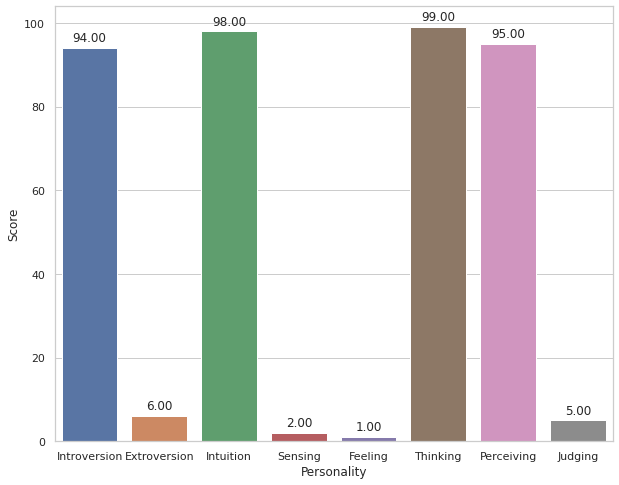

In [ ]:
my_posts = """I'm seriously considering marriage to my longtime ENFP girlfriend. But do you think she'll be able to give me a little more space when we are settled down in marriage? My two biggest problems with...|||I'll revive this in the rare event anyone else wants to comment.|||While I certainly can agree with the crux of what you're saying in your post, particularly the summary above (and yes, INTPs do question these seemingly meaningless conventions for what they are), I...|||It seems that I can never achieve the kind of satisfaction in my career that other people experience (although my career is solid and does use many of my talents). Not completely sure if it's...|||Nice insight. I totally agree that it seems like a match up destined for clashes.|||Dad:  ISTJ Mom: ISFJ Younger brother:  ESFP  Me:  INTP|||sometimes they ask candidates to take the test.|||How big of a role does MBTI play in many HR departments? Are candidates ever eliminated solely by MBTI type?|||Newer show....but Rosa Diaz from Brooklyn Nine-Nine.  yeah, the female feeler is a popular archetype.|||Lol that sounds right.|||Any further analysis on why these two would be good in a relationship?|||Cultural norms and so-called ideals.|||Why in theory is an ESTJ so good with INTP? I've heard this often, and can think of several reasons why, but I'd like to hear further analysis of this.|||Fair enough. :tongue:|||I was positive someone would quickly provide a response of this nature. If you look at my first post, I specified that I was going to focus on the preference of a heterosexual male ESTJ. That's all....|||I thought that disclaimer goes without saying. MBTI is about generalizations and stereotypes by nature.|||Absolutely right. Bad word choice. I will change it.|||As you know, the stereotypical male is a T type--rational and logical--while the stereotypical female is the F type--sensitive and emotional. Considering these longstanding cultural views, when a...|||Let me first provide the disclaimer that this, of course, is not definitive, but my generalized opinion.   ESTJs strongly uphold societal traditions. I believe that their faith in these cultural...|||Two of my closest friends for over 10 years are INFPs. I'd say one comical (and well-known) trait they share is their lack of precision in certain statements. They remember the details of past...|||ESTJs are best with other SJs. In my opinion, they have a VERY difficult time with NFs. For a male ESTJ, I believe the best match is a female ISFJ.|||I'm not even sure this is possibly measurable. If so, it would obviously have to be a J or some sort. Perhaps SJ.   What do you think?|||I'm absolutely 100% sure that I'm an INTP. But I can sometimes fake being an ENTP socially when I'm out. But I still need serious re-charging time afterwards.  I should also mention that these ESFJ...|||An ESFJ is supposed to be a complete opposite of me. Yet somehow I keep becoming attracted to (and eventually dating) these sweet ESFJs. What's going on? And are these relationships sustainable? I...|||That's exactly what I would expect and believe it is generally accurate. Personally, I'm an independent who votes Republican.|||Haha! As an INTP, I find that response is hilarious. Yet so true and familiar for me...|||Yeah it's always seemed like a fairly incompatible group to me. In general, of course, because it depends on the individuals involved.|||INTPs can definitely be goal oriented. In fact, all of them are to some extent. We all set goals and accomplish them (to varying degrees). The intp goals may not be as traditional as those other...|||One of my best friends is INFP, another is ESTJ. They seem to think the opposite on every issue (though they hardly know each other). Do you think these types would conflict as much as just about any...|||As I said in the ESFP area, Don't Stop the Party for ESFPs.|||INTPs are the most mysterious in general. ENTJs are the most mysterious to me.|||Hahaha! Having a best friend for the last 15 years who is an ESTJ, I can say that paraphrase is essentially accurate.|||I have to say that the N/S thing has really been getting to me lately too. I love a lot of S type women at first, but it just doesn't seem workable. I miss that deeper intellectual connection and we...|||Interesting...good point.   I know this requires a great deal of knowledge on an artist from a while back now, so not everyone will know WTF is going on. But feel free to chime in if you know the...|||Yeah I know know what you mean. I believe that Neo from the Matrix is a rare lead character INTP. But that has a lot to do with the unusual philosophical nature of the movie and the fact that the...|||Calvin I can see what you mean about your types. Paul I can definitely see as ESTJ. I may disagree on John the apostle being INTP though. Although he does have that kind of calm/detached tendency, he...|||Is it possible that Beach Boys composer legend Brian Wilson is an INTP? I never would have considered this as even a possibility until someone argued for it. In the 60s he achieved autonomy and...|||INTPs are generally big picture logical thinkers. So they would create the architectural ideas and leave implementation to others. Lol.|||Troll thread? It may be a dumb thread, or moronically phrased, but I'm serious about the topic. I have the tendency to get extremely attracted to ESFJs, which never seems to end ideally. And yet here...|||In the case of Solomon I'm not positive whether or not he would be an INTP, but I would probably say he was (if I had to guess). He was certainly motivated by the pursuit of wisdom and knowledge. In...|||I'm not sure that I can explain it better than other resources. So I'll just send a few links:  INTP personality | 16 Personality Types  Portrait of an INTP  A few excerpts:  --Accumulated...|||I greatly appreciated your relationship analysis, for the record.|||Interesting thread. I definitely see some truth in it. Not sure if it is completely universal, or effected by T and F as well. But I'd like to hear more opinions..|||You think Solomon was INTP? Was it his interest in knowledge/wisdom that makes you think that?|||Good point. I sometime morph into being perceived as ENTP and feel a certain kinship with that type.|||Yes, this may be kind of theoretical topic. But can you somewhat alter your type if you wanted to? Obviously I don't think you can change your cognitive preferences. But can you transform yourself,...|||Hahaha! Yeah I've honestly thought about giving extremely absurdist answers like that. Frankly they come to my head more often than normal answers. Answering that I'm a CIA special agent and my job...|||Hahaha!|||This may just be a personal quirk and not necessarily an INTP thing. But I always hate having to catch up with casual acquaintances with these type of questions. Do you?  One reason I probably...|||Judging by your photo, the INTJ men wouldn't mind getting to know you either. :wink:"""

#data cleaningre
predict(my_posts)

Abhisekh Shukla

ESFJ Person possesses following personality :-  Extroversion, Sensing, Feeling, Judging


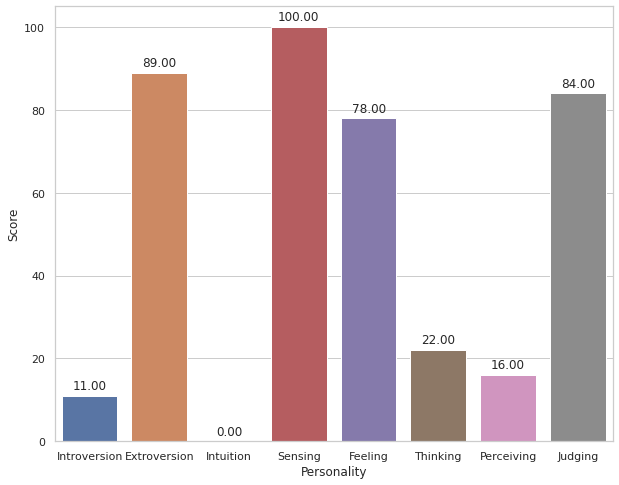

In [ ]:
my_posts = """Dynamic and motivated professional with 3+ years of Procurement experience in Manufacturing and Service (FMCG) Operations. Skilled in Demand planning/forecasting, Procurement, strategic sourcing and negotiation, inventory management, vendor management, invoicing and procuring MRO items. Strong functional experience in SAP -MM model for end to end procurement operation. I was awarded best employee and best team award."""

#data cleaningre
predict(my_posts)

Devesh Gupta

ESFJ Person possesses following personality :-  Extroversion, Sensing, Feeling, Judging


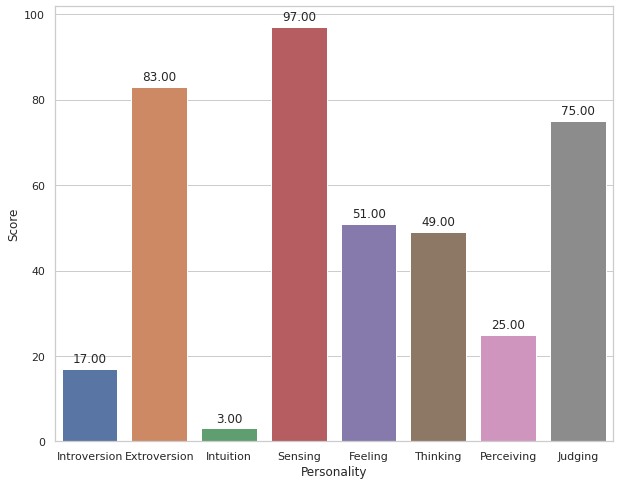

In [ ]:
my_posts = """As an organized and motivated recent graduate with 2+ years of experience in customer relationship management, I am seeking position within roles that will utilize my skills and knowledge gained through extensive academic and professional background and help the company in analyzing issues, taking effective decisions and making clients realize the business value from IT.

Fascinated by the power of data, currently I am learning data analysis using Python. I have completed M.Sc. in Operations & Supply Chain Management from Trinity College Dublin where I gained solid understanding on the concepts of project management, logistics, operations, inventory management and other supply chain concepts. In addition, I developed good knowledge on statistical data analysis, building dashboards, visualizations, analyzing risks associated with decision making and performing forecasting using error analysis techniques.

While working as a back end developer (.Net) in my previous role, I developed ability to write clean and efficient code using C# programming language and build web applications using ASP.NET, ADO.NET and MVC. Moreover, I developed strong comprehension of object-oriented programming concepts and proficiency in writing and performing SQL queries.

Technical Skills-
• Data Analysis Tools: MS Excel, SPSS.
• Visualization Tools: Tableau.
• Database: Oracle, Microsoft SQL Server.
• Programming Language: C, C#.
• Web Technology: ASP.NET, MVC, ADO.NET.
• Others: SAP, Advanced Excel, Microsoft Word, PowerPoint, @Risk, Precision Tree, Visual Studio."""


#data cleaningre
predict(my_posts)

ESFJ Person possesses following personality :-  Extroversion, Sensing, Feeling, Judging


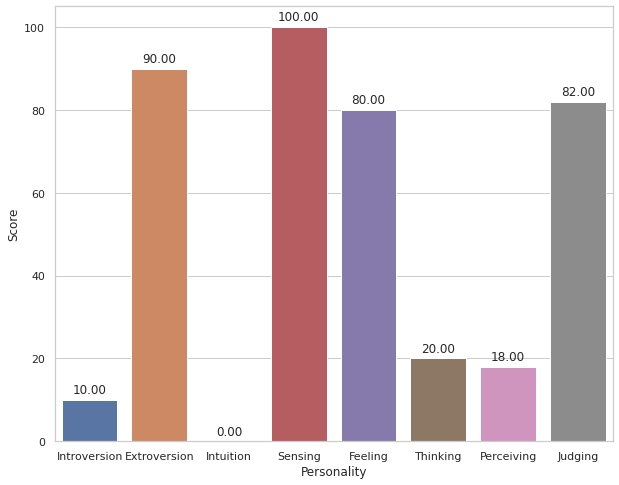

In [ ]:
my_posts = """Building long lasting Relationships and delivering strong Profitability."""

#data cleaningre
predict(my_posts)

ESFJ Person possesses following personality :-  Extroversion, Sensing, Feeling, Judging


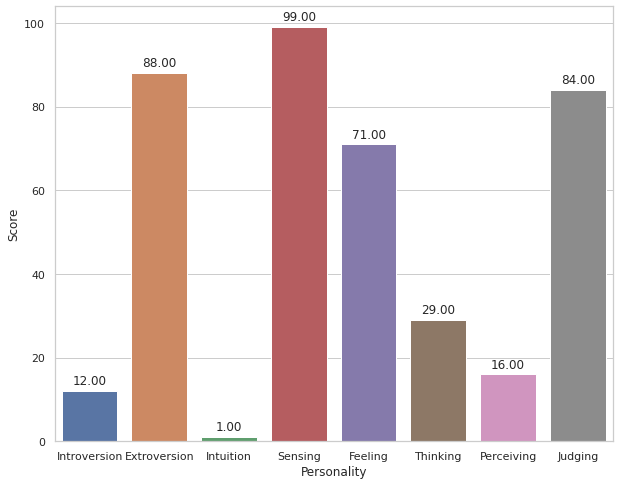

In [ ]:
my_posts = """Data Engineer/Software Developer with Masters in Data Analytics from Dublin City University having 5+ years of work experience in Data Pipelines, Core Development, Reporting, Visualizations, DB & Data Technologies with progressive growth. I believe in taking ownership of projects and proactively contributing towards the enhancement of the overall business solution. Actively looking for opportunities to sharpen and enhance my skills and knowledge by being a part of a progressive and leading organization, which would offer me opportunities as well as challenges to utilize my technical and decision making skills to the best of my efforts. """

#data cleaningre
predict(my_posts)

## Sushil

ESFJ Person possesses following personality :-  Extroversion, Sensing, Feeling, Judging


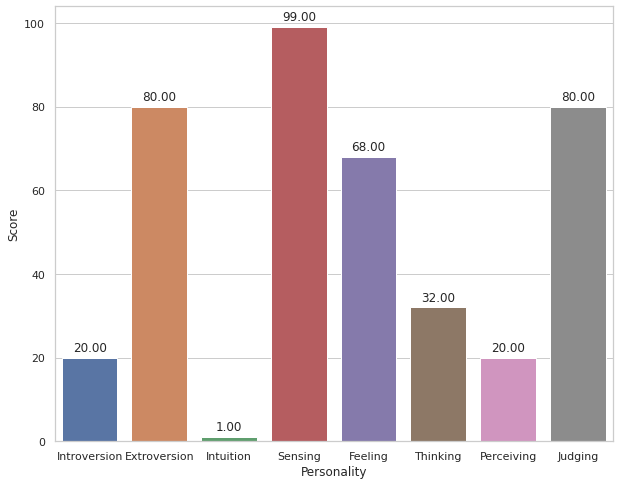

In [ ]:
my_posts = """Strong DevOps professional having 3.9 years of experience with skills in Release and Configuration management. Have rich experience in a client-facing role.

Completed Masters in Data Analytics from the National College of Ireland and Bachelors in Computers Science from the University of Pune, India.

Strong skills in Linux, Configuration Management activities and Build/Release Management.

Experience in creating fully automated CI/CD infrastructure for applications using Jenkins. Good Experience of version control tools like GIT and SVN, build tools like Maven and Ant. Corporate experience in configuring environments with Chef and Docker Swarm.

Good understanding of networking protocols like DNS, SSH, and telnet. Awareness of GDPR compliances.

Handled daily deployments to critical Live environment with minimum downtime. """

#data cleaningre
predict(my_posts)

## Aadesh

ESFJ Person possesses following personality :-  Extroversion, Sensing, Feeling, Judging


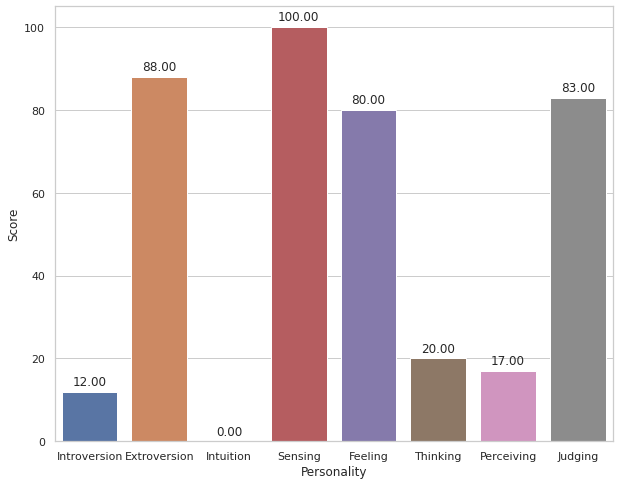

In [ ]:
my_posts = """Experience of building Machine learning pipelines. 4+ years of experience in Data Science field. """

#data cleaningre
predict(my_posts)